In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [78]:
cm_target[1]

'case1cm_blade1.csv'

In [11]:
str(cm_target[0])

'NACA0018cm_blade1.csv'

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    #total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    file = cm_target
    df = pd.DataFrame()

    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

    time = df.iloc[:,0].values
    cm = df.iloc[:,1].values

    time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
    cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]

    # Handle the time that is duplicated because of digits
    # Also, outliers are regulated at the second conditional statement.
    time_beUsed = handler_time(time_beUsed)
    cm_beUsed = handler_cm(cm_beUsed)

    linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                       bounds_error=False,kind='quadratic',
                                       fill_value='extrapolate')
    time_interp = np.arange(10, 15, t_interval).reshape((-1,1))

    cm_interp=linear_func(time_interp).reshape((-1,1))

    cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[1], n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (5000, 2)
Dimension - x:  (5000, 1)
Dimension - y:  (5000, 1)


In [21]:
x -=10

In [22]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [24]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [25]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221226_flap1_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221226unsteadyPrediction_MLP_flap1_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.2047 - rmse: 0.4523
Epoch 1: val_loss improved from inf to 0.15025, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 1s 117ms/step - loss: 0.1789 - rmse: 0.4229 - val_loss: 0.1502 - val_rmse: 0.3875 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1355 - rmse: 0.3680
Epoch 2: val_loss improved from 0.15025 to 0.11988, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 39ms/step - loss: 0.1254 - rmse: 0.3540 - val_loss: 0.1199 - val_rmse: 0.3461 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1112 - rmse: 0.3332
Epoch 3: val_loss improved from 0.

3/3 [==============================] - 0s 47ms/step - loss: 0.0823 - rmse: 0.2867 - val_loss: 0.0900 - val_rmse: 0.2999 - lr: 1.0000e-04
Epoch 21/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0787 - rmse: 0.2803
Epoch 21: val_loss improved from 0.09003 to 0.08918, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 42ms/step - loss: 0.0847 - rmse: 0.2909 - val_loss: 0.0892 - val_rmse: 0.2985 - lr: 1.0000e-04
Epoch 22/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0824 - rmse: 0.2868
Epoch 22: val_loss improved from 0.08918 to 0.08794, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0793 - rmse: 0.2814 - val_loss: 0.0879 - val_rmse: 0.296

3/3 [==============================] - 0s 46ms/step - loss: 0.0694 - rmse: 0.2632 - val_loss: 0.0754 - val_rmse: 0.2744 - lr: 1.0000e-04
Epoch 40/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0759 - rmse: 0.2753
Epoch 40: val_loss improved from 0.07539 to 0.07531, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0701 - rmse: 0.2646 - val_loss: 0.0753 - val_rmse: 0.2742 - lr: 1.0000e-04
Epoch 41/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0775 - rmse: 0.2781
Epoch 41: val_loss improved from 0.07531 to 0.07516, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0701 - rmse: 0.2645 - val_loss: 0.0752 - val_rmse: 0.274

Epoch 60/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0693 - rmse: 0.2630
Epoch 60: val_loss did not improve from 0.07354
3/3 [==============================] - 0s 22ms/step - loss: 0.0671 - rmse: 0.2588 - val_loss: 0.0736 - val_rmse: 0.2711 - lr: 1.0000e-04
Epoch 61/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0696 - rmse: 0.2637
Epoch 61: val_loss improved from 0.07354 to 0.07333, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0685 - rmse: 0.2615 - val_loss: 0.0733 - val_rmse: 0.2706 - lr: 1.0000e-04
Epoch 62/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0660 - rmse: 0.2567
Epoch 62: val_loss improved from 0.07333 to 0.07326, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_random

Epoch 81/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0630 - rmse: 0.2508
Epoch 81: val_loss improved from 0.07214 to 0.07209, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0661 - rmse: 0.2569 - val_loss: 0.0721 - val_rmse: 0.2683 - lr: 1.0000e-04
Epoch 82/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0696 - rmse: 0.2637
Epoch 82: val_loss did not improve from 0.07209
3/3 [==============================] - 0s 21ms/step - loss: 0.0648 - rmse: 0.2544 - val_loss: 0.0721 - val_rmse: 0.2683 - lr: 1.0000e-04
Epoch 83/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0688 - rmse: 0.2621
Epoch 83: val_loss improved from 0.07209 to 0.07201, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_random

Epoch 102/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0623 - rmse: 0.2494
Epoch 102: val_loss improved from 0.07062 to 0.07051, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0627 - rmse: 0.2502 - val_loss: 0.0705 - val_rmse: 0.2653 - lr: 1.0000e-04
Epoch 103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0663 - rmse: 0.2574
Epoch 103: val_loss improved from 0.07051 to 0.07048, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0624 - rmse: 0.2496 - val_loss: 0.0705 - val_rmse: 0.2653 - lr: 1.0000e-04
Epoch 104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0725 - rmse: 0.2691
Epoch 104: val_loss i

1/3 [=========>....................] - ETA: 0s - loss: 0.0619 - rmse: 0.2485
Epoch 124: val_loss improved from 0.06856 to 0.06840, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0622 - rmse: 0.2491 - val_loss: 0.0684 - val_rmse: 0.2613 - lr: 1.0000e-04
Epoch 125/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0584 - rmse: 0.2414
Epoch 125: val_loss improved from 0.06840 to 0.06816, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0607 - rmse: 0.2461 - val_loss: 0.0682 - val_rmse: 0.2609 - lr: 1.0000e-04
Epoch 126/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0666 - rmse: 0.2578
Epoch 126: val_loss improved from 0.0

3/3 [==============================] - 0s 46ms/step - loss: 0.0604 - rmse: 0.2455 - val_loss: 0.0666 - val_rmse: 0.2578 - lr: 1.0000e-04
Epoch 144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0619 - rmse: 0.2486
Epoch 144: val_loss did not improve from 0.06656
3/3 [==============================] - 0s 21ms/step - loss: 0.0575 - rmse: 0.2397 - val_loss: 0.0666 - val_rmse: 0.2578 - lr: 1.0000e-04
Epoch 145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0596 - rmse: 0.2439
Epoch 145: val_loss did not improve from 0.06656
3/3 [==============================] - 0s 22ms/step - loss: 0.0580 - rmse: 0.2407 - val_loss: 0.0668 - val_rmse: 0.2583 - lr: 1.0000e-04
Epoch 146/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0664 - rmse: 0.2574
Epoch 146: val_loss improved from 0.06656 to 0.06646, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5

Epoch 166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0659 - rmse: 0.2565
Epoch 166: val_loss did not improve from 0.06532
3/3 [==============================] - 0s 22ms/step - loss: 0.0593 - rmse: 0.2432 - val_loss: 0.0653 - val_rmse: 0.2554 - lr: 1.0000e-04
Epoch 167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0578 - rmse: 0.2401
Epoch 167: val_loss did not improve from 0.06532
3/3 [==============================] - 0s 21ms/step - loss: 0.0562 - rmse: 0.2368 - val_loss: 0.0654 - val_rmse: 0.2555 - lr: 1.0000e-04
Epoch 168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0595 - rmse: 0.2437
Epoch 168: val_loss improved from 0.06532 to 0.06519, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0587 - rmse: 0.2422 - val_loss: 0.0652 - val_rmse: 0.2551 - lr: 1.0000e-04

1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2362
Epoch 188: val_loss improved from 0.06460 to 0.06457, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.0565 - rmse: 0.2376 - val_loss: 0.0646 - val_rmse: 0.2539 - lr: 1.0000e-04
Epoch 189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0598 - rmse: 0.2442
Epoch 189: val_loss did not improve from 0.06457
3/3 [==============================] - 0s 21ms/step - loss: 0.0564 - rmse: 0.2373 - val_loss: 0.0647 - val_rmse: 0.2542 - lr: 1.0000e-04
Epoch 190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0587 - rmse: 0.2420
Epoch 190: val_loss improved from 0.06457 to 0.06454, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_ch

Epoch 212/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2333
Epoch 212: val_loss improved from 0.06418 to 0.06407, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0539 - rmse: 0.2320 - val_loss: 0.0641 - val_rmse: 0.2529 - lr: 1.0000e-04
Epoch 213/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0555 - rmse: 0.2353
Epoch 213: val_loss improved from 0.06407 to 0.06400, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0546 - rmse: 0.2335 - val_loss: 0.0640 - val_rmse: 0.2528 - lr: 1.0000e-04
Epoch 214/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0654 - rmse: 0.2555
Epoch 214: val_loss d

1/3 [=========>....................] - ETA: 0s - loss: 0.0526 - rmse: 0.2291
Epoch 236: val_loss improved from 0.06367 to 0.06360, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0563 - rmse: 0.2371 - val_loss: 0.0636 - val_rmse: 0.2520 - lr: 1.0000e-04
Epoch 237/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0600 - rmse: 0.2448
Epoch 237: val_loss did not improve from 0.06360
3/3 [==============================] - 0s 21ms/step - loss: 0.0562 - rmse: 0.2369 - val_loss: 0.0638 - val_rmse: 0.2523 - lr: 1.0000e-04
Epoch 238/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0539 - rmse: 0.2319
Epoch 238: val_loss did not improve from 0.06360
3/3 [==============================] - 0s 22ms/step - loss: 0.0577 - rmse: 0.2399 - val_loss: 0.0638 - val_rmse: 0.2524 - lr: 1.0000e-04
Epoch 239/10000

3/3 [==============================] - 0s 22ms/step - loss: 0.0566 - rmse: 0.2377 - val_loss: 0.0635 - val_rmse: 0.2518 - lr: 1.0000e-04
Epoch 263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0519 - rmse: 0.2277
Epoch 263: val_loss did not improve from 0.06340
3/3 [==============================] - 0s 21ms/step - loss: 0.0534 - rmse: 0.2308 - val_loss: 0.0636 - val_rmse: 0.2520 - lr: 1.0000e-04
Epoch 264/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0583 - rmse: 0.2413
Epoch 264: val_loss improved from 0.06340 to 0.06338, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.0569 - rmse: 0.2383 - val_loss: 0.0634 - val_rmse: 0.2516 - lr: 1.0000e-04
Epoch 265/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0576 - rmse: 0.2398
Epoch 265: val_loss improved from 0.06338 to 0.0

3/3 [==============================] - 0s 22ms/step - loss: 0.0563 - rmse: 0.2370 - val_loss: 0.0649 - val_rmse: 0.2546 - lr: 1.0000e-04
Epoch 289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0561 - rmse: 0.2367
Epoch 289: val_loss did not improve from 0.06321
3/3 [==============================] - 0s 21ms/step - loss: 0.0566 - rmse: 0.2377 - val_loss: 0.0634 - val_rmse: 0.2516 - lr: 1.0000e-04
Epoch 290/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0572 - rmse: 0.2389
Epoch 290: val_loss improved from 0.06321 to 0.06316, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0572 - rmse: 0.2390 - val_loss: 0.0632 - val_rmse: 0.2511 - lr: 1.0000e-04
Epoch 291/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0547 - rmse: 0.2338
Epoch 291: val_loss did not improve from 0.06316

Epoch 316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0550 - rmse: 0.2343
Epoch 316: val_loss did not improve from 0.06298
3/3 [==============================] - 0s 21ms/step - loss: 0.0541 - rmse: 0.2323 - val_loss: 0.0644 - val_rmse: 0.2536 - lr: 1.0000e-04
Epoch 317/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0485 - rmse: 0.2200
Epoch 317: val_loss did not improve from 0.06298
3/3 [==============================] - 0s 22ms/step - loss: 0.0537 - rmse: 0.2316 - val_loss: 0.0630 - val_rmse: 0.2509 - lr: 1.0000e-04
Epoch 318/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0692 - rmse: 0.2630
Epoch 318: val_loss did not improve from 0.06298
3/3 [==============================] - 0s 21ms/step - loss: 0.0610 - rmse: 0.2468 - val_loss: 0.0630 - val_rmse: 0.2508 - lr: 1.0000e-04
Epoch 319/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0564 - rmse: 0.2373
Epoch 319: val_loss did not improve from 0.06298
3/3 [================

3/3 [==============================] - 0s 45ms/step - loss: 0.0560 - rmse: 0.2365 - val_loss: 0.0627 - val_rmse: 0.2502 - lr: 1.0000e-04
Epoch 342/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0526 - rmse: 0.2291
Epoch 342: val_loss did not improve from 0.06270
3/3 [==============================] - 0s 21ms/step - loss: 0.0539 - rmse: 0.2321 - val_loss: 0.0633 - val_rmse: 0.2515 - lr: 1.0000e-04
Epoch 343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0560 - rmse: 0.2365
Epoch 343: val_loss did not improve from 0.06270
3/3 [==============================] - 0s 21ms/step - loss: 0.0556 - rmse: 0.2357 - val_loss: 0.0633 - val_rmse: 0.2514 - lr: 1.0000e-04
Epoch 344/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0586 - rmse: 0.2418
Epoch 344: val_loss did not improve from 0.06270
3/3 [==============================] - 0s 22ms/step - loss: 0.0568 - rmse: 0.2381 - val_loss: 0.0635 - val_rmse: 0.2518 - lr: 1.0000e-04
Epoch 345/10000
1/3 [=====

Epoch 369/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2362
Epoch 369: val_loss improved from 0.06252 to 0.06249, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0557 - rmse: 0.2359 - val_loss: 0.0625 - val_rmse: 0.2498 - lr: 1.0000e-04
Epoch 370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0534 - rmse: 0.2309
Epoch 370: val_loss did not improve from 0.06249
3/3 [==============================] - 0s 22ms/step - loss: 0.0561 - rmse: 0.2367 - val_loss: 0.0626 - val_rmse: 0.2500 - lr: 1.0000e-04
Epoch 371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2346
Epoch 371: val_loss did not improve from 0.06249
3/3 [==============================] - 0s 21ms/step - loss: 0.0535 - rmse: 0.2312 - val_loss: 0.0633 - val_rmse: 0.2514 - lr: 1.0000e-04

1/3 [=========>....................] - ETA: 0s - loss: 0.0605 - rmse: 0.2457
Epoch 393: val_loss did not improve from 0.06232
3/3 [==============================] - 0s 21ms/step - loss: 0.0544 - rmse: 0.2330 - val_loss: 0.0624 - val_rmse: 0.2495 - lr: 1.0000e-04
Epoch 394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0594 - rmse: 0.2435
Epoch 394: val_loss did not improve from 0.06232
3/3 [==============================] - 0s 21ms/step - loss: 0.0578 - rmse: 0.2401 - val_loss: 0.0623 - val_rmse: 0.2495 - lr: 1.0000e-04
Epoch 395/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0542 - rmse: 0.2326
Epoch 395: val_loss did not improve from 0.06232
3/3 [==============================] - 0s 21ms/step - loss: 0.0536 - rmse: 0.2314 - val_loss: 0.0624 - val_rmse: 0.2495 - lr: 1.0000e-04
Epoch 396/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0541 - rmse: 0.2323
Epoch 396: val_loss improved from 0.06232 to 0.06227, saving model to D:\TrainedModels

Epoch 418/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0575 - rmse: 0.2397
Epoch 418: val_loss did not improve from 0.06204
3/3 [==============================] - 0s 21ms/step - loss: 0.0555 - rmse: 0.2355 - val_loss: 0.0621 - val_rmse: 0.2490 - lr: 1.0000e-04
Epoch 419/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0522 - rmse: 0.2283
Epoch 419: val_loss improved from 0.06204 to 0.06197, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0562 - rmse: 0.2369 - val_loss: 0.0620 - val_rmse: 0.2488 - lr: 1.0000e-04
Epoch 420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0544 - rmse: 0.2330
Epoch 420: val_loss did not improve from 0.06197
3/3 [==============================] - 0s 21ms/step - loss: 0.0536 - rmse: 0.2314 - val_loss: 0.0621 - val_rmse: 0.2490 - lr: 1.0000e-04

3/3 [==============================] - 0s 21ms/step - loss: 0.0544 - rmse: 0.2331 - val_loss: 0.0619 - val_rmse: 0.2487 - lr: 1.0000e-04
Epoch 445/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0583 - rmse: 0.2412
Epoch 445: val_loss improved from 0.06181 to 0.06178, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0559 - rmse: 0.2362 - val_loss: 0.0618 - val_rmse: 0.2484 - lr: 1.0000e-04
Epoch 446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0486 - rmse: 0.2203
Epoch 446: val_loss did not improve from 0.06178
3/3 [==============================] - 0s 21ms/step - loss: 0.0555 - rmse: 0.2353 - val_loss: 0.0620 - val_rmse: 0.2489 - lr: 1.0000e-04
Epoch 447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2304
Epoch 447: val_loss did not improve from 0.06178

3/3 [==============================] - 0s 50ms/step - loss: 0.0549 - rmse: 0.2340 - val_loss: 0.0615 - val_rmse: 0.2478 - lr: 1.0000e-04
Epoch 469/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - rmse: 0.2310
Epoch 469: val_loss improved from 0.06151 to 0.06148, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0546 - rmse: 0.2334 - val_loss: 0.0615 - val_rmse: 0.2478 - lr: 1.0000e-04
Epoch 470/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2304
Epoch 470: val_loss did not improve from 0.06148
3/3 [==============================] - 0s 21ms/step - loss: 0.0506 - rmse: 0.2246 - val_loss: 0.0620 - val_rmse: 0.2487 - lr: 1.0000e-04
Epoch 471/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0597 - rmse: 0.2441
Epoch 471: val_loss did not improve from 0.06148

1/3 [=========>....................] - ETA: 0s - loss: 0.0548 - rmse: 0.2338
Epoch 496: val_loss improved from 0.06128 to 0.06117, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0551 - rmse: 0.2346 - val_loss: 0.0612 - val_rmse: 0.2472 - lr: 1.0000e-04
Epoch 497/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0485 - rmse: 0.2201
Epoch 497: val_loss did not improve from 0.06117
3/3 [==============================] - 0s 21ms/step - loss: 0.0534 - rmse: 0.2309 - val_loss: 0.0612 - val_rmse: 0.2472 - lr: 1.0000e-04
Epoch 498/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0588 - rmse: 0.2423
Epoch 498: val_loss did not improve from 0.06117
3/3 [==============================] - 0s 22ms/step - loss: 0.0540 - rmse: 0.2322 - val_loss: 0.0613 - val_rmse: 0.2473 - lr: 1.0000e-04
Epoch 499/10000

1/3 [=========>....................] - ETA: 0s - loss: 0.0563 - rmse: 0.2370
Epoch 521: val_loss did not improve from 0.06085
3/3 [==============================] - 0s 21ms/step - loss: 0.0542 - rmse: 0.2326 - val_loss: 0.0609 - val_rmse: 0.2465 - lr: 1.0000e-04
Epoch 522/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0525 - rmse: 0.2290
Epoch 522: val_loss did not improve from 0.06085
3/3 [==============================] - 0s 22ms/step - loss: 0.0550 - rmse: 0.2343 - val_loss: 0.0610 - val_rmse: 0.2468 - lr: 1.0000e-04
Epoch 523/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0483 - rmse: 0.2196
Epoch 523: val_loss improved from 0.06085 to 0.06079, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0534 - rmse: 0.2310 - val_loss: 0.0608 - val_rmse: 0.2464 - lr: 1.0000e-04
Epoch 524/10000

1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2346
Epoch 548: val_loss did not improve from 0.06059
3/3 [==============================] - 0s 20ms/step - loss: 0.0550 - rmse: 0.2343 - val_loss: 0.0608 - val_rmse: 0.2465 - lr: 1.0000e-04
Epoch 549/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2281
Epoch 549: val_loss improved from 0.06059 to 0.06056, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0532 - rmse: 0.2305 - val_loss: 0.0606 - val_rmse: 0.2459 - lr: 1.0000e-04
Epoch 550/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0565 - rmse: 0.2376
Epoch 550: val_loss did not improve from 0.06056
3/3 [==============================] - 0s 21ms/step - loss: 0.0536 - rmse: 0.2314 - val_loss: 0.0606 - val_rmse: 0.2461 - lr: 1.0000e-04
Epoch 551/10000

3/3 [==============================] - 0s 52ms/step - loss: 0.0541 - rmse: 0.2325 - val_loss: 0.0601 - val_rmse: 0.2451 - lr: 1.0000e-04
Epoch 573/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0518 - rmse: 0.2273
Epoch 573: val_loss did not improve from 0.06014
3/3 [==============================] - 0s 21ms/step - loss: 0.0534 - rmse: 0.2309 - val_loss: 0.0602 - val_rmse: 0.2452 - lr: 1.0000e-04
Epoch 574/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0529 - rmse: 0.2299
Epoch 574: val_loss did not improve from 0.06014
3/3 [==============================] - 0s 22ms/step - loss: 0.0541 - rmse: 0.2324 - val_loss: 0.0603 - val_rmse: 0.2454 - lr: 1.0000e-04
Epoch 575/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0566 - rmse: 0.2377
Epoch 575: val_loss did not improve from 0.06014
3/3 [==============================] - 0s 21ms/step - loss: 0.0525 - rmse: 0.2289 - val_loss: 0.0604 - val_rmse: 0.2455 - lr: 1.0000e-04
Epoch 576/10000
1/3 [=====

3/3 [==============================] - 0s 21ms/step - loss: 0.0528 - rmse: 0.2295 - val_loss: 0.0600 - val_rmse: 0.2447 - lr: 1.0000e-04
Epoch 599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0531 - rmse: 0.2303
Epoch 599: val_loss did not improve from 0.05982
3/3 [==============================] - 0s 21ms/step - loss: 0.0533 - rmse: 0.2306 - val_loss: 0.0599 - val_rmse: 0.2445 - lr: 1.0000e-04
Epoch 600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0518 - rmse: 0.2273
Epoch 600: val_loss did not improve from 0.05982
3/3 [==============================] - 0s 21ms/step - loss: 0.0529 - rmse: 0.2297 - val_loss: 0.0599 - val_rmse: 0.2447 - lr: 1.0000e-04
Epoch 601/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0506 - rmse: 0.2248
Epoch 601: val_loss did not improve from 0.05982
3/3 [==============================] - 0s 21ms/step - loss: 0.0521 - rmse: 0.2281 - val_loss: 0.0599 - val_rmse: 0.2445 - lr: 1.0000e-04
Epoch 602/10000
1/3 [=====

3/3 [==============================] - 0s 54ms/step - loss: 0.0538 - rmse: 0.2317 - val_loss: 0.0594 - val_rmse: 0.2436 - lr: 1.0000e-04
Epoch 625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0538 - rmse: 0.2319
Epoch 625: val_loss did not improve from 0.05943
3/3 [==============================] - 0s 21ms/step - loss: 0.0539 - rmse: 0.2320 - val_loss: 0.0595 - val_rmse: 0.2438 - lr: 1.0000e-04
Epoch 626/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0471 - rmse: 0.2168
Epoch 626: val_loss did not improve from 0.05943
3/3 [==============================] - 0s 21ms/step - loss: 0.0511 - rmse: 0.2260 - val_loss: 0.0598 - val_rmse: 0.2443 - lr: 1.0000e-04
Epoch 627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2304
Epoch 627: val_loss did not improve from 0.05943
3/3 [==============================] - 0s 21ms/step - loss: 0.0540 - rmse: 0.2322 - val_loss: 0.0595 - val_rmse: 0.2437 - lr: 1.0000e-04
Epoch 628/10000
1/3 [=====

3/3 [==============================] - 0s 22ms/step - loss: 0.0518 - rmse: 0.2274 - val_loss: 0.0593 - val_rmse: 0.2434 - lr: 1.0000e-04
Epoch 651/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2305
Epoch 651: val_loss did not improve from 0.05898
3/3 [==============================] - 0s 22ms/step - loss: 0.0551 - rmse: 0.2346 - val_loss: 0.0593 - val_rmse: 0.2434 - lr: 1.0000e-04
Epoch 652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0514 - rmse: 0.2264
Epoch 652: val_loss did not improve from 0.05898
3/3 [==============================] - 0s 22ms/step - loss: 0.0510 - rmse: 0.2257 - val_loss: 0.0590 - val_rmse: 0.2427 - lr: 1.0000e-04
Epoch 653/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0488 - rmse: 0.2206
Epoch 653: val_loss did not improve from 0.05898
3/3 [==============================] - 0s 22ms/step - loss: 0.0527 - rmse: 0.2294 - val_loss: 0.0590 - val_rmse: 0.2428 - lr: 1.0000e-04
Epoch 654/10000
1/3 [=====

3/3 [==============================] - 0s 48ms/step - loss: 0.0507 - rmse: 0.2249 - val_loss: 0.0584 - val_rmse: 0.2416 - lr: 1.0000e-04
Epoch 677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2226
Epoch 677: val_loss did not improve from 0.05843
3/3 [==============================] - 0s 22ms/step - loss: 0.0511 - rmse: 0.2258 - val_loss: 0.0586 - val_rmse: 0.2418 - lr: 1.0000e-04
Epoch 678/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0570 - rmse: 0.2386
Epoch 678: val_loss did not improve from 0.05843
3/3 [==============================] - 0s 21ms/step - loss: 0.0523 - rmse: 0.2285 - val_loss: 0.0586 - val_rmse: 0.2418 - lr: 1.0000e-04
Epoch 679/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0527 - rmse: 0.2294
Epoch 679: val_loss did not improve from 0.05843
3/3 [==============================] - 0s 22ms/step - loss: 0.0506 - rmse: 0.2247 - val_loss: 0.0589 - val_rmse: 0.2425 - lr: 1.0000e-04
Epoch 680/10000
1/3 [=====

3/3 [==============================] - 0s 22ms/step - loss: 0.0514 - rmse: 0.2265 - val_loss: 0.0582 - val_rmse: 0.2411 - lr: 1.0000e-04
Epoch 703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0528 - rmse: 0.2297
Epoch 703: val_loss improved from 0.05797 to 0.05786, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0513 - rmse: 0.2262 - val_loss: 0.0579 - val_rmse: 0.2404 - lr: 1.0000e-04
Epoch 704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0483 - rmse: 0.2197
Epoch 704: val_loss did not improve from 0.05786
3/3 [==============================] - 0s 21ms/step - loss: 0.0515 - rmse: 0.2269 - val_loss: 0.0579 - val_rmse: 0.2405 - lr: 1.0000e-04
Epoch 705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0504 - rmse: 0.2243
Epoch 705: val_loss did not improve from 0.05786

3/3 [==============================] - 0s 49ms/step - loss: 0.0528 - rmse: 0.2296 - val_loss: 0.0572 - val_rmse: 0.2390 - lr: 1.0000e-04
Epoch 727/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0471 - rmse: 0.2168
Epoch 727: val_loss improved from 0.05718 to 0.05711, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0526 - rmse: 0.2291 - val_loss: 0.0571 - val_rmse: 0.2388 - lr: 1.0000e-04
Epoch 728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0507 - rmse: 0.2249
Epoch 728: val_loss did not improve from 0.05711
3/3 [==============================] - 0s 21ms/step - loss: 0.0493 - rmse: 0.2218 - val_loss: 0.0575 - val_rmse: 0.2396 - lr: 1.0000e-04
Epoch 729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0498 - rmse: 0.2231
Epoch 729: val_loss did not improve from 0.05711

Epoch 752/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0510 - rmse: 0.2257
Epoch 752: val_loss did not improve from 0.05618
3/3 [==============================] - 0s 21ms/step - loss: 0.0480 - rmse: 0.2189 - val_loss: 0.0583 - val_rmse: 0.2413 - lr: 1.0000e-04
Epoch 753/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0564 - rmse: 0.2372
Epoch 753: val_loss did not improve from 0.05618
3/3 [==============================] - 0s 21ms/step - loss: 0.0520 - rmse: 0.2279 - val_loss: 0.0572 - val_rmse: 0.2390 - lr: 1.0000e-04
Epoch 754/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0449 - rmse: 0.2117
Epoch 754: val_loss did not improve from 0.05618
3/3 [==============================] - 0s 21ms/step - loss: 0.0482 - rmse: 0.2194 - val_loss: 0.0579 - val_rmse: 0.2405 - lr: 1.0000e-04
Epoch 755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0550 - rmse: 0.2343
Epoch 755: val_loss did not improve from 0.05618
3/3 [================

Epoch 778/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0468 - rmse: 0.2161
Epoch 778: val_loss did not improve from 0.05520
3/3 [==============================] - 0s 21ms/step - loss: 0.0477 - rmse: 0.2183 - val_loss: 0.0564 - val_rmse: 0.2374 - lr: 1.0000e-04
Epoch 779/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0538 - rmse: 0.2318
Epoch 779: val_loss did not improve from 0.05520
3/3 [==============================] - 0s 21ms/step - loss: 0.0514 - rmse: 0.2266 - val_loss: 0.0553 - val_rmse: 0.2349 - lr: 1.0000e-04
Epoch 780/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0466 - rmse: 0.2158
Epoch 780: val_loss did not improve from 0.05520
3/3 [==============================] - 0s 21ms/step - loss: 0.0480 - rmse: 0.2189 - val_loss: 0.0552 - val_rmse: 0.2349 - lr: 1.0000e-04
Epoch 781/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0486 - rmse: 0.2204
Epoch 781: val_loss improved from 0.05520 to 0.05512, saving model to 

Epoch 801/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0495 - rmse: 0.2223
Epoch 801: val_loss did not improve from 0.05403
3/3 [==============================] - 0s 21ms/step - loss: 0.0488 - rmse: 0.2208 - val_loss: 0.0542 - val_rmse: 0.2326 - lr: 1.0000e-04
Epoch 802/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0456 - rmse: 0.2133
Epoch 802: val_loss improved from 0.05403 to 0.05393, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0481 - rmse: 0.2190 - val_loss: 0.0539 - val_rmse: 0.2321 - lr: 1.0000e-04
Epoch 803/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0473 - rmse: 0.2172
Epoch 803: val_loss improved from 0.05393 to 0.05386, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_

Epoch 826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0454 - rmse: 0.2128
Epoch 826: val_loss improved from 0.05301 to 0.05283, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0443 - rmse: 0.2102 - val_loss: 0.0528 - val_rmse: 0.2297 - lr: 1.0000e-04
Epoch 827/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0550 - rmse: 0.2343
Epoch 827: val_loss improved from 0.05283 to 0.05280, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0496 - rmse: 0.2226 - val_loss: 0.0528 - val_rmse: 0.2296 - lr: 1.0000e-04
Epoch 828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0495 - rmse: 0.2223
Epoch 828: val_loss i

1/3 [=========>....................] - ETA: 0s - loss: 0.0491 - rmse: 0.2213
Epoch 848: val_loss did not improve from 0.05165
3/3 [==============================] - 0s 22ms/step - loss: 0.0459 - rmse: 0.2140 - val_loss: 0.0528 - val_rmse: 0.2296 - lr: 1.0000e-04
Epoch 849/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0439 - rmse: 0.2094
Epoch 849: val_loss did not improve from 0.05165
3/3 [==============================] - 0s 21ms/step - loss: 0.0463 - rmse: 0.2151 - val_loss: 0.0531 - val_rmse: 0.2302 - lr: 1.0000e-04
Epoch 850/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0501 - rmse: 0.2238
Epoch 850: val_loss did not improve from 0.05165
3/3 [==============================] - 0s 21ms/step - loss: 0.0496 - rmse: 0.2226 - val_loss: 0.0518 - val_rmse: 0.2273 - lr: 1.0000e-04
Epoch 851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0418 - rmse: 0.2043
Epoch 851: val_loss improved from 0.05165 to 0.05142, saving model to D:\TrainedModels

Epoch 874/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0479 - rmse: 0.2186
Epoch 874: val_loss improved from 0.05055 to 0.05042, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0476 - rmse: 0.2179 - val_loss: 0.0504 - val_rmse: 0.2244 - lr: 1.0000e-04
Epoch 875/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0442 - rmse: 0.2101
Epoch 875: val_loss did not improve from 0.05042
3/3 [==============================] - 0s 21ms/step - loss: 0.0450 - rmse: 0.2118 - val_loss: 0.0507 - val_rmse: 0.2251 - lr: 1.0000e-04
Epoch 876/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0439 - rmse: 0.2094
Epoch 876: val_loss improved from 0.05042 to 0.05022, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_

3/3 [==============================] - 0s 66ms/step - loss: 0.0447 - rmse: 0.2112 - val_loss: 0.0494 - val_rmse: 0.2220 - lr: 1.0000e-04
Epoch 898/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0459 - rmse: 0.2141
Epoch 898: val_loss did not improve from 0.04935
3/3 [==============================] - 0s 22ms/step - loss: 0.0425 - rmse: 0.2060 - val_loss: 0.0494 - val_rmse: 0.2221 - lr: 1.0000e-04
Epoch 899/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0461 - rmse: 0.2145
Epoch 899: val_loss improved from 0.04935 to 0.04931, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0478 - rmse: 0.2184 - val_loss: 0.0493 - val_rmse: 0.2219 - lr: 1.0000e-04
Epoch 900/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0425 - rmse: 0.2059
Epoch 900: val_loss improved from 0.04931 to 0.0

3/3 [==============================] - 0s 21ms/step - loss: 0.0467 - rmse: 0.2160 - val_loss: 0.0496 - val_rmse: 0.2225 - lr: 1.0000e-04
Epoch 921/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0445 - rmse: 0.2108
Epoch 921: val_loss did not improve from 0.04790
3/3 [==============================] - 0s 22ms/step - loss: 0.0440 - rmse: 0.2097 - val_loss: 0.0481 - val_rmse: 0.2190 - lr: 1.0000e-04
Epoch 922/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0499 - rmse: 0.2232
Epoch 922: val_loss did not improve from 0.04790
3/3 [==============================] - 0s 21ms/step - loss: 0.0456 - rmse: 0.2133 - val_loss: 0.0483 - val_rmse: 0.2197 - lr: 1.0000e-04
Epoch 923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0452 - rmse: 0.2125
Epoch 923: val_loss did not improve from 0.04790
3/3 [==============================] - 0s 21ms/step - loss: 0.0445 - rmse: 0.2107 - val_loss: 0.0486 - val_rmse: 0.2202 - lr: 1.0000e-04
Epoch 924/10000
1/3 [=====

1/3 [=========>....................] - ETA: 0s - loss: 0.0421 - rmse: 0.2051
Epoch 945: val_loss did not improve from 0.04670
3/3 [==============================] - 0s 22ms/step - loss: 0.0425 - rmse: 0.2061 - val_loss: 0.0471 - val_rmse: 0.2168 - lr: 1.0000e-04
Epoch 946/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0434 - rmse: 0.2083
Epoch 946: val_loss did not improve from 0.04670
3/3 [==============================] - 0s 21ms/step - loss: 0.0442 - rmse: 0.2101 - val_loss: 0.0473 - val_rmse: 0.2173 - lr: 1.0000e-04
Epoch 947/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0397 - rmse: 0.1990
Epoch 947: val_loss did not improve from 0.04670
3/3 [==============================] - 0s 21ms/step - loss: 0.0423 - rmse: 0.2056 - val_loss: 0.0472 - val_rmse: 0.2171 - lr: 1.0000e-04
Epoch 948/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0417 - rmse: 0.2040
Epoch 948: val_loss did not improve from 0.04670
3/3 [==============================] 

1/3 [=========>....................] - ETA: 0s - loss: 0.0420 - rmse: 0.2048
Epoch 970: val_loss did not improve from 0.04558
3/3 [==============================] - 0s 22ms/step - loss: 0.0431 - rmse: 0.2075 - val_loss: 0.0457 - val_rmse: 0.2136 - lr: 1.0000e-04
Epoch 971/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0372 - rmse: 0.1926
Epoch 971: val_loss improved from 0.04558 to 0.04543, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0407 - rmse: 0.2014 - val_loss: 0.0454 - val_rmse: 0.2130 - lr: 1.0000e-04
Epoch 972/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0391 - rmse: 0.1975
Epoch 972: val_loss improved from 0.04543 to 0.04538, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_ch

Epoch 994/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0401 - rmse: 0.2000
Epoch 994: val_loss did not improve from 0.04464
3/3 [==============================] - 0s 22ms/step - loss: 0.0432 - rmse: 0.2077 - val_loss: 0.0449 - val_rmse: 0.2117 - lr: 1.0000e-04
Epoch 995/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0398 - rmse: 0.1993
Epoch 995: val_loss did not improve from 0.04464
3/3 [==============================] - 0s 22ms/step - loss: 0.0394 - rmse: 0.1982 - val_loss: 0.0452 - val_rmse: 0.2125 - lr: 1.0000e-04
Epoch 996/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0405 - rmse: 0.2011
Epoch 996: val_loss did not improve from 0.04464
3/3 [==============================] - 0s 21ms/step - loss: 0.0423 - rmse: 0.2054 - val_loss: 0.0452 - val_rmse: 0.2125 - lr: 1.0000e-04
Epoch 997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0426 - rmse: 0.2061
Epoch 997: val_loss did not improve from 0.04464
3/3 [================

Epoch 1019/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0369 - rmse: 0.1919
Epoch 1019: val_loss did not improve from 0.04380
3/3 [==============================] - 0s 22ms/step - loss: 0.0398 - rmse: 0.1993 - val_loss: 0.0442 - val_rmse: 0.2101 - lr: 1.0000e-04
Epoch 1020/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0408 - rmse: 0.2018
Epoch 1020: val_loss did not improve from 0.04380
3/3 [==============================] - 0s 22ms/step - loss: 0.0401 - rmse: 0.2001 - val_loss: 0.0451 - val_rmse: 0.2123 - lr: 1.0000e-04
Epoch 1021/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0382 - rmse: 0.1954
Epoch 1021: val_loss did not improve from 0.04380
3/3 [==============================] - 0s 22ms/step - loss: 0.0404 - rmse: 0.2008 - val_loss: 0.0443 - val_rmse: 0.2103 - lr: 1.0000e-04
Epoch 1022/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0429 - rmse: 0.2069
Epoch 1022: val_loss did not improve from 0.04380
3/3 [========

3/3 [==============================] - 0s 48ms/step - loss: 0.0398 - rmse: 0.1992 - val_loss: 0.0429 - val_rmse: 0.2068 - lr: 1.0000e-04
Epoch 1043/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0384 - rmse: 0.1957
Epoch 1043: val_loss did not improve from 0.04285
3/3 [==============================] - 0s 21ms/step - loss: 0.0396 - rmse: 0.1988 - val_loss: 0.0431 - val_rmse: 0.2073 - lr: 1.0000e-04
Epoch 1044/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0373 - rmse: 0.1929
Epoch 1044: val_loss did not improve from 0.04285
3/3 [==============================] - 0s 21ms/step - loss: 0.0387 - rmse: 0.1965 - val_loss: 0.0429 - val_rmse: 0.2069 - lr: 1.0000e-04
Epoch 1045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0390 - rmse: 0.1972
Epoch 1045: val_loss did not improve from 0.04285
3/3 [==============================] - 0s 22ms/step - loss: 0.0393 - rmse: 0.1981 - val_loss: 0.0429 - val_rmse: 0.2070 - lr: 1.0000e-04
Epoch 1046/10000
1/3

Epoch 1069/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0415 - rmse: 0.2034
Epoch 1069: val_loss did not improve from 0.04229
3/3 [==============================] - 0s 21ms/step - loss: 0.0402 - rmse: 0.2003 - val_loss: 0.0425 - val_rmse: 0.2059 - lr: 1.0000e-04
Epoch 1070/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0338 - rmse: 0.1837
Epoch 1070: val_loss improved from 0.04229 to 0.04216, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0394 - rmse: 0.1984 - val_loss: 0.0422 - val_rmse: 0.2051 - lr: 1.0000e-04
Epoch 1071/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0367 - rmse: 0.1913
Epoch 1071: val_loss did not improve from 0.04216
3/3 [==============================] - 0s 21ms/step - loss: 0.0364 - rmse: 0.1906 - val_loss: 0.0426 - val_rmse: 0.2061 - lr: 1.00

Epoch 1095/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0379 - rmse: 0.1944
Epoch 1095: val_loss did not improve from 0.04168
3/3 [==============================] - 0s 21ms/step - loss: 0.0389 - rmse: 0.1971 - val_loss: 0.0419 - val_rmse: 0.2046 - lr: 1.0000e-04
Epoch 1096/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0386 - rmse: 0.1963
Epoch 1096: val_loss did not improve from 0.04168
3/3 [==============================] - 0s 21ms/step - loss: 0.0388 - rmse: 0.1967 - val_loss: 0.0420 - val_rmse: 0.2047 - lr: 1.0000e-04
Epoch 1097/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0415 - rmse: 0.2035
Epoch 1097: val_loss did not improve from 0.04168
3/3 [==============================] - 0s 21ms/step - loss: 0.0392 - rmse: 0.1979 - val_loss: 0.0425 - val_rmse: 0.2061 - lr: 1.0000e-04
Epoch 1098/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0354 - rmse: 0.1880
Epoch 1098: val_loss did not improve from 0.04168
3/3 [========

Epoch 1121/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1895
Epoch 1121: val_loss did not improve from 0.04118
3/3 [==============================] - 0s 22ms/step - loss: 0.0384 - rmse: 0.1956 - val_loss: 0.0415 - val_rmse: 0.2036 - lr: 1.0000e-04
Epoch 1122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0361 - rmse: 0.1899
Epoch 1122: val_loss improved from 0.04118 to 0.04108, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0378 - rmse: 0.1942 - val_loss: 0.0411 - val_rmse: 0.2025 - lr: 1.0000e-04
Epoch 1123/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0348 - rmse: 0.1864
Epoch 1123: val_loss improved from 0.04108 to 0.04083, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256

Epoch 1147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0408 - rmse: 0.2019
Epoch 1147: val_loss did not improve from 0.04057
3/3 [==============================] - 0s 22ms/step - loss: 0.0389 - rmse: 0.1970 - val_loss: 0.0426 - val_rmse: 0.2061 - lr: 1.0000e-04
Epoch 1148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0391 - rmse: 0.1976
Epoch 1148: val_loss did not improve from 0.04057
3/3 [==============================] - 0s 21ms/step - loss: 0.0395 - rmse: 0.1986 - val_loss: 0.0414 - val_rmse: 0.2033 - lr: 1.0000e-04
Epoch 1149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0387 - rmse: 0.1966
Epoch 1149: val_loss improved from 0.04057 to 0.04030, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0386 - rmse: 0.1962 - val_loss: 0.0403 - val_rmse: 0.2006 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0417 - rmse: 0.2040
Epoch 1173: val_loss did not improve from 0.03996
3/3 [==============================] - 0s 21ms/step - loss: 0.0389 - rmse: 0.1970 - val_loss: 0.0410 - val_rmse: 0.2024 - lr: 1.0000e-04
Epoch 1174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0327 - rmse: 0.1806
Epoch 1174: val_loss did not improve from 0.03996
3/3 [==============================] - 0s 21ms/step - loss: 0.0378 - rmse: 0.1943 - val_loss: 0.0404 - val_rmse: 0.2009 - lr: 1.0000e-04
Epoch 1175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0353 - rmse: 0.1878
Epoch 1175: val_loss improved from 0.03996 to 0.03985, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0365 - rmse: 0.1908 - val_loss: 0.0398 - val_rmse: 0.1994 - lr: 1.0000e-04
Epoch 1176

1/3 [=========>....................] - ETA: 0s - loss: 0.0403 - rmse: 0.2007
Epoch 1198: val_loss did not improve from 0.03940
3/3 [==============================] - 0s 21ms/step - loss: 0.0372 - rmse: 0.1928 - val_loss: 0.0399 - val_rmse: 0.1995 - lr: 1.0000e-04
Epoch 1199/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0368 - rmse: 0.1917
Epoch 1199: val_loss did not improve from 0.03940
3/3 [==============================] - 0s 22ms/step - loss: 0.0364 - rmse: 0.1905 - val_loss: 0.0400 - val_rmse: 0.1997 - lr: 1.0000e-04
Epoch 1200/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0399 - rmse: 0.1995
Epoch 1200: val_loss did not improve from 0.03940
3/3 [==============================] - 0s 21ms/step - loss: 0.0385 - rmse: 0.1961 - val_loss: 0.0396 - val_rmse: 0.1988 - lr: 1.0000e-04
Epoch 1201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0356 - rmse: 0.1886
Epoch 1201: val_loss did not improve from 0.03940
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0344 - rmse: 0.1853
Epoch 1223: val_loss did not improve from 0.03891
3/3 [==============================] - 0s 21ms/step - loss: 0.0335 - rmse: 0.1828 - val_loss: 0.0390 - val_rmse: 0.1973 - lr: 1.0000e-04
Epoch 1224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0363 - rmse: 0.1902
Epoch 1224: val_loss did not improve from 0.03891
3/3 [==============================] - 0s 21ms/step - loss: 0.0385 - rmse: 0.1960 - val_loss: 0.0397 - val_rmse: 0.1991 - lr: 1.0000e-04
Epoch 1225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0378 - rmse: 0.1943
Epoch 1225: val_loss did not improve from 0.03891
3/3 [==============================] - 0s 21ms/step - loss: 0.0367 - rmse: 0.1915 - val_loss: 0.0405 - val_rmse: 0.2011 - lr: 1.0000e-04
Epoch 1226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0380 - rmse: 0.1946
Epoch 1226: val_loss did not improve from 0.03891
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0367 - rmse: 0.1915 - val_loss: 0.0393 - val_rmse: 0.1979 - lr: 1.0000e-04
Epoch 1251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0354 - rmse: 0.1880
Epoch 1251: val_loss did not improve from 0.03845
3/3 [==============================] - 0s 21ms/step - loss: 0.0374 - rmse: 0.1931 - val_loss: 0.0413 - val_rmse: 0.2031 - lr: 1.0000e-04
Epoch 1252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0396 - rmse: 0.1989
Epoch 1252: val_loss improved from 0.03845 to 0.03838, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 67ms/step - loss: 0.0374 - rmse: 0.1931 - val_loss: 0.0384 - val_rmse: 0.1957 - lr: 1.0000e-04
Epoch 1253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0369 - rmse: 0.1919
Epoch 1253: val_loss did not improve from 0

1/3 [=========>....................] - ETA: 0s - loss: 0.0353 - rmse: 0.1876
Epoch 1276: val_loss did not improve from 0.03813
3/3 [==============================] - 0s 22ms/step - loss: 0.0354 - rmse: 0.1881 - val_loss: 0.0386 - val_rmse: 0.1963 - lr: 1.0000e-04
Epoch 1277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0400 - rmse: 0.1997
Epoch 1277: val_loss did not improve from 0.03813
3/3 [==============================] - 0s 21ms/step - loss: 0.0371 - rmse: 0.1925 - val_loss: 0.0397 - val_rmse: 0.1991 - lr: 1.0000e-04
Epoch 1278/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0378 - rmse: 0.1942
Epoch 1278: val_loss did not improve from 0.03813
3/3 [==============================] - 0s 21ms/step - loss: 0.0366 - rmse: 0.1910 - val_loss: 0.0392 - val_rmse: 0.1978 - lr: 1.0000e-04
Epoch 1279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0381 - rmse: 0.1951
Epoch 1279: val_loss did not improve from 0.03813
3/3 [=========================

Epoch 1303/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1883
Epoch 1303: val_loss did not improve from 0.03761
3/3 [==============================] - 0s 21ms/step - loss: 0.0350 - rmse: 0.1870 - val_loss: 0.0382 - val_rmse: 0.1951 - lr: 1.0000e-04
Epoch 1304/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0371 - rmse: 0.1925
Epoch 1304: val_loss did not improve from 0.03761
3/3 [==============================] - 0s 21ms/step - loss: 0.0359 - rmse: 0.1893 - val_loss: 0.0377 - val_rmse: 0.1941 - lr: 1.0000e-04
Epoch 1305/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - rmse: 0.1883
Epoch 1305: val_loss did not improve from 0.03761
3/3 [==============================] - 0s 21ms/step - loss: 0.0349 - rmse: 0.1867 - val_loss: 0.0382 - val_rmse: 0.1952 - lr: 1.0000e-04
Epoch 1306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0387 - rmse: 0.1964
Epoch 1306: val_loss did not improve from 0.03761
3/3 [========

Epoch 1330/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0328 - rmse: 0.1810
Epoch 1330: val_loss did not improve from 0.03722
3/3 [==============================] - 0s 22ms/step - loss: 0.0348 - rmse: 0.1862 - val_loss: 0.0379 - val_rmse: 0.1944 - lr: 1.0000e-04
Epoch 1331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0376 - rmse: 0.1937
Epoch 1331: val_loss improved from 0.03722 to 0.03714, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0361 - rmse: 0.1898 - val_loss: 0.0371 - val_rmse: 0.1925 - lr: 1.0000e-04
Epoch 1332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0375 - rmse: 0.1936
Epoch 1332: val_loss did not improve from 0.03714
3/3 [==============================] - 0s 21ms/step - loss: 0.0363 - rmse: 0.1904 - val_loss: 0.0413 - val_rmse: 0.2030 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0346 - rmse: 0.1859
Epoch 1356: val_loss did not improve from 0.03678
3/3 [==============================] - 0s 21ms/step - loss: 0.0350 - rmse: 0.1870 - val_loss: 0.0368 - val_rmse: 0.1917 - lr: 1.0000e-04
Epoch 1357/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0352 - rmse: 0.1875
Epoch 1357: val_loss did not improve from 0.03678
3/3 [==============================] - 0s 22ms/step - loss: 0.0341 - rmse: 0.1845 - val_loss: 0.0374 - val_rmse: 0.1932 - lr: 1.0000e-04
Epoch 1358/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0392 - rmse: 0.1979
Epoch 1358: val_loss did not improve from 0.03678
3/3 [==============================] - 0s 21ms/step - loss: 0.0364 - rmse: 0.1905 - val_loss: 0.0368 - val_rmse: 0.1917 - lr: 1.0000e-04
Epoch 1359/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1831
Epoch 1359: val_loss improved from 0.03678 to 0.03676, saving model to D:\Traine

3/3 [==============================] - 0s 21ms/step - loss: 0.0352 - rmse: 0.1874 - val_loss: 0.0373 - val_rmse: 0.1928 - lr: 1.0000e-04
Epoch 1384/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1895
Epoch 1384: val_loss did not improve from 0.03647
3/3 [==============================] - 0s 21ms/step - loss: 0.0354 - rmse: 0.1881 - val_loss: 0.0365 - val_rmse: 0.1908 - lr: 1.0000e-04
Epoch 1385/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0317 - rmse: 0.1779
Epoch 1385: val_loss did not improve from 0.03647
3/3 [==============================] - 0s 22ms/step - loss: 0.0354 - rmse: 0.1879 - val_loss: 0.0375 - val_rmse: 0.1935 - lr: 1.0000e-04
Epoch 1386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0344 - rmse: 0.1854
Epoch 1386: val_loss did not improve from 0.03647
3/3 [==============================] - 0s 22ms/step - loss: 0.0350 - rmse: 0.1869 - val_loss: 0.0368 - val_rmse: 0.1916 - lr: 1.0000e-04
Epoch 1387/10000
1/3

3/3 [==============================] - 0s 48ms/step - loss: 0.0343 - rmse: 0.1850 - val_loss: 0.0358 - val_rmse: 0.1891 - lr: 1.0000e-04
Epoch 1411/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0337 - rmse: 0.1833
Epoch 1411: val_loss did not improve from 0.03583
3/3 [==============================] - 0s 21ms/step - loss: 0.0340 - rmse: 0.1842 - val_loss: 0.0361 - val_rmse: 0.1897 - lr: 1.0000e-04
Epoch 1412/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1832
Epoch 1412: val_loss improved from 0.03583 to 0.03582, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0327 - rmse: 0.1806 - val_loss: 0.0358 - val_rmse: 0.1891 - lr: 1.0000e-04
Epoch 1413/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0354 - rmse: 0.1881
Epoch 1413: val_loss did not improve from 0

3/3 [==============================] - 0s 21ms/step - loss: 0.0338 - rmse: 0.1838 - val_loss: 0.0360 - val_rmse: 0.1895 - lr: 1.0000e-04
Epoch 1438/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0307 - rmse: 0.1750
Epoch 1438: val_loss did not improve from 0.03545
3/3 [==============================] - 0s 21ms/step - loss: 0.0339 - rmse: 0.1839 - val_loss: 0.0360 - val_rmse: 0.1896 - lr: 1.0000e-04
Epoch 1439/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1832
Epoch 1439: val_loss did not improve from 0.03545
3/3 [==============================] - 0s 21ms/step - loss: 0.0327 - rmse: 0.1805 - val_loss: 0.0355 - val_rmse: 0.1881 - lr: 1.0000e-04
Epoch 1440/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0332 - rmse: 0.1821
Epoch 1440: val_loss did not improve from 0.03545
3/3 [==============================] - 0s 20ms/step - loss: 0.0334 - rmse: 0.1827 - val_loss: 0.0355 - val_rmse: 0.1881 - lr: 1.0000e-04
Epoch 1441/10000
1/3

Epoch 1465/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0331 - rmse: 0.1817
Epoch 1465: val_loss did not improve from 0.03485
3/3 [==============================] - 0s 21ms/step - loss: 0.0331 - rmse: 0.1818 - val_loss: 0.0350 - val_rmse: 0.1868 - lr: 1.0000e-04
Epoch 1466/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0326 - rmse: 0.1803
Epoch 1466: val_loss did not improve from 0.03485
3/3 [==============================] - 0s 21ms/step - loss: 0.0321 - rmse: 0.1789 - val_loss: 0.0356 - val_rmse: 0.1885 - lr: 1.0000e-04
Epoch 1467/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0359 - rmse: 0.1893
Epoch 1467: val_loss did not improve from 0.03485
3/3 [==============================] - 0s 21ms/step - loss: 0.0348 - rmse: 0.1865 - val_loss: 0.0350 - val_rmse: 0.1870 - lr: 1.0000e-04
Epoch 1468/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0324 - rmse: 0.1799
Epoch 1468: val_loss did not improve from 0.03485
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0337 - rmse: 0.1833
Epoch 1491: val_loss did not improve from 0.03454
3/3 [==============================] - 0s 21ms/step - loss: 0.0327 - rmse: 0.1805 - val_loss: 0.0347 - val_rmse: 0.1862 - lr: 1.0000e-04
Epoch 1492/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - rmse: 0.1790
Epoch 1492: val_loss did not improve from 0.03454
3/3 [==============================] - 0s 21ms/step - loss: 0.0337 - rmse: 0.1834 - val_loss: 0.0348 - val_rmse: 0.1863 - lr: 1.0000e-04
Epoch 1493/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0322 - rmse: 0.1792
Epoch 1493: val_loss did not improve from 0.03454
3/3 [==============================] - 0s 21ms/step - loss: 0.0333 - rmse: 0.1824 - val_loss: 0.0355 - val_rmse: 0.1881 - lr: 1.0000e-04
Epoch 1494/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0324 - rmse: 0.1799
Epoch 1494: val_loss did not improve from 0.03454
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - rmse: 0.1773
Epoch 1516: val_loss did not improve from 0.03391
3/3 [==============================] - 0s 21ms/step - loss: 0.0316 - rmse: 0.1776 - val_loss: 0.0343 - val_rmse: 0.1850 - lr: 1.0000e-04
Epoch 1517/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0313 - rmse: 0.1768
Epoch 1517: val_loss did not improve from 0.03391
3/3 [==============================] - 0s 21ms/step - loss: 0.0319 - rmse: 0.1783 - val_loss: 0.0343 - val_rmse: 0.1850 - lr: 1.0000e-04
Epoch 1518/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - rmse: 0.1830
Epoch 1518: val_loss did not improve from 0.03391
3/3 [==============================] - 0s 21ms/step - loss: 0.0337 - rmse: 0.1833 - val_loss: 0.0339 - val_rmse: 0.1841 - lr: 1.0000e-04
Epoch 1519/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0300 - rmse: 0.1731
Epoch 1519: val_loss did not improve from 0.03391
3/3 [=========================

Epoch 1543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0326 - rmse: 0.1804
Epoch 1543: val_loss did not improve from 0.03343
3/3 [==============================] - 0s 21ms/step - loss: 0.0333 - rmse: 0.1823 - val_loss: 0.0335 - val_rmse: 0.1830 - lr: 1.0000e-04
Epoch 1544/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0322 - rmse: 0.1792
Epoch 1544: val_loss did not improve from 0.03343
3/3 [==============================] - 0s 22ms/step - loss: 0.0304 - rmse: 0.1741 - val_loss: 0.0341 - val_rmse: 0.1844 - lr: 1.0000e-04
Epoch 1545/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0306 - rmse: 0.1749
Epoch 1545: val_loss did not improve from 0.03343
3/3 [==============================] - 0s 21ms/step - loss: 0.0320 - rmse: 0.1787 - val_loss: 0.0336 - val_rmse: 0.1831 - lr: 1.0000e-04
Epoch 1546/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1783
Epoch 1546: val_loss did not improve from 0.03343
3/3 [========

3/3 [==============================] - 0s 50ms/step - loss: 0.0302 - rmse: 0.1737 - val_loss: 0.0329 - val_rmse: 0.1813 - lr: 1.0000e-04
Epoch 1571/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1784
Epoch 1571: val_loss did not improve from 0.03292
3/3 [==============================] - 0s 21ms/step - loss: 0.0318 - rmse: 0.1781 - val_loss: 0.0333 - val_rmse: 0.1824 - lr: 1.0000e-04
Epoch 1572/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0322 - rmse: 0.1793
Epoch 1572: val_loss did not improve from 0.03292
3/3 [==============================] - 0s 22ms/step - loss: 0.0315 - rmse: 0.1772 - val_loss: 0.0329 - val_rmse: 0.1813 - lr: 1.0000e-04
Epoch 1573/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - rmse: 0.1830
Epoch 1573: val_loss did not improve from 0.03292
3/3 [==============================] - 0s 22ms/step - loss: 0.0312 - rmse: 0.1764 - val_loss: 0.0330 - val_rmse: 0.1814 - lr: 1.0000e-04
Epoch 1574/10000
1/3

3/3 [==============================] - 0s 48ms/step - loss: 0.0301 - rmse: 0.1734 - val_loss: 0.0323 - val_rmse: 0.1796 - lr: 1.0000e-04
Epoch 1597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0323 - rmse: 0.1795
Epoch 1597: val_loss improved from 0.03231 to 0.03226, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0311 - rmse: 0.1761 - val_loss: 0.0323 - val_rmse: 0.1794 - lr: 1.0000e-04
Epoch 1598/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0275 - rmse: 0.1658
Epoch 1598: val_loss did not improve from 0.03226
3/3 [==============================] - 0s 21ms/step - loss: 0.0296 - rmse: 0.1719 - val_loss: 0.0324 - val_rmse: 0.1799 - lr: 1.0000e-04
Epoch 1599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0327 - rmse: 0.1807
Epoch 1599: val_loss did not improve from 0

Epoch 1623/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0304 - rmse: 0.1743
Epoch 1623: val_loss did not improve from 0.03186
3/3 [==============================] - 0s 22ms/step - loss: 0.0315 - rmse: 0.1773 - val_loss: 0.0321 - val_rmse: 0.1791 - lr: 1.0000e-04
Epoch 1624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0298 - rmse: 0.1724
Epoch 1624: val_loss did not improve from 0.03186
3/3 [==============================] - 0s 22ms/step - loss: 0.0306 - rmse: 0.1747 - val_loss: 0.0321 - val_rmse: 0.1791 - lr: 1.0000e-04
Epoch 1625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1728
Epoch 1625: val_loss improved from 0.03186 to 0.03184, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0301 - rmse: 0.1732 - val_loss: 0.0318 - val_rmse: 0.1783 - lr: 1.00

3/3 [==============================] - 0s 21ms/step - loss: 0.0312 - rmse: 0.1765 - val_loss: 0.0320 - val_rmse: 0.1787 - lr: 1.0000e-04
Epoch 1651/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1692
Epoch 1651: val_loss did not improve from 0.03145
3/3 [==============================] - 0s 22ms/step - loss: 0.0325 - rmse: 0.1800 - val_loss: 0.0351 - val_rmse: 0.1872 - lr: 1.0000e-04
Epoch 1652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0341 - rmse: 0.1845
Epoch 1652: val_loss improved from 0.03145 to 0.03129, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0302 - rmse: 0.1735 - val_loss: 0.0313 - val_rmse: 0.1767 - lr: 1.0000e-04
Epoch 1653/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0281 - rmse: 0.1674
Epoch 1653: val_loss did not improve from 0

1/3 [=========>....................] - ETA: 0s - loss: 0.0296 - rmse: 0.1718
Epoch 1676: val_loss did not improve from 0.03096
3/3 [==============================] - 0s 21ms/step - loss: 0.0287 - rmse: 0.1692 - val_loss: 0.0314 - val_rmse: 0.1770 - lr: 1.0000e-04
Epoch 1677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0291 - rmse: 0.1704
Epoch 1677: val_loss did not improve from 0.03096
3/3 [==============================] - 0s 21ms/step - loss: 0.0293 - rmse: 0.1710 - val_loss: 0.0313 - val_rmse: 0.1767 - lr: 1.0000e-04
Epoch 1678/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0311 - rmse: 0.1762
Epoch 1678: val_loss improved from 0.03096 to 0.03090, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0314 - rmse: 0.1771 - val_loss: 0.0309 - val_rmse: 0.1756 - lr: 1.0000e-04
Epoch 1679

1/3 [=========>....................] - ETA: 0s - loss: 0.0270 - rmse: 0.1641
Epoch 1701: val_loss did not improve from 0.03036
3/3 [==============================] - 0s 21ms/step - loss: 0.0300 - rmse: 0.1730 - val_loss: 0.0325 - val_rmse: 0.1800 - lr: 1.0000e-04
Epoch 1702/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0305 - rmse: 0.1746
Epoch 1702: val_loss did not improve from 0.03036
3/3 [==============================] - 0s 21ms/step - loss: 0.0302 - rmse: 0.1737 - val_loss: 0.0318 - val_rmse: 0.1782 - lr: 1.0000e-04
Epoch 1703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0306 - rmse: 0.1747
Epoch 1703: val_loss did not improve from 0.03036
3/3 [==============================] - 0s 21ms/step - loss: 0.0310 - rmse: 0.1759 - val_loss: 0.0307 - val_rmse: 0.1750 - lr: 1.0000e-04
Epoch 1704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0289 - rmse: 0.1697
Epoch 1704: val_loss did not improve from 0.03036
3/3 [=========================

3/3 [==============================] - 0s 58ms/step - loss: 0.0286 - rmse: 0.1688 - val_loss: 0.0300 - val_rmse: 0.1731 - lr: 1.0000e-04
Epoch 1729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0302 - rmse: 0.1735
Epoch 1729: val_loss did not improve from 0.03002
3/3 [==============================] - 0s 22ms/step - loss: 0.0288 - rmse: 0.1696 - val_loss: 0.0309 - val_rmse: 0.1757 - lr: 1.0000e-04
Epoch 1730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0288 - rmse: 0.1695
Epoch 1730: val_loss improved from 0.03002 to 0.02979, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 60ms/step - loss: 0.0283 - rmse: 0.1679 - val_loss: 0.0298 - val_rmse: 0.1724 - lr: 1.0000e-04
Epoch 1731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1711
Epoch 1731: val_loss did not improve from 0

Epoch 1755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0280 - rmse: 0.1671
Epoch 1755: val_loss did not improve from 0.02935
3/3 [==============================] - 0s 21ms/step - loss: 0.0283 - rmse: 0.1679 - val_loss: 0.0294 - val_rmse: 0.1712 - lr: 1.0000e-04
Epoch 1756/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - rmse: 0.1772
Epoch 1756: val_loss did not improve from 0.02935
3/3 [==============================] - 0s 21ms/step - loss: 0.0277 - rmse: 0.1662 - val_loss: 0.0295 - val_rmse: 0.1717 - lr: 1.0000e-04
Epoch 1757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0307 - rmse: 0.1749
Epoch 1757: val_loss did not improve from 0.02935
3/3 [==============================] - 0s 21ms/step - loss: 0.0281 - rmse: 0.1675 - val_loss: 0.0294 - val_rmse: 0.1711 - lr: 1.0000e-04
Epoch 1758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0260 - rmse: 0.1610
Epoch 1758: val_loss improved from 0.02935 to 0.02917, saving m

Epoch 1781/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0277 - rmse: 0.1662
Epoch 1781: val_loss improved from 0.02895 to 0.02889, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0275 - rmse: 0.1658 - val_loss: 0.0289 - val_rmse: 0.1698 - lr: 1.0000e-04
Epoch 1782/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0255 - rmse: 0.1593
Epoch 1782: val_loss did not improve from 0.02889
3/3 [==============================] - 0s 23ms/step - loss: 0.0268 - rmse: 0.1635 - val_loss: 0.0291 - val_rmse: 0.1704 - lr: 1.0000e-04
Epoch 1783/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0285 - rmse: 0.1685
Epoch 1783: val_loss did not improve from 0.02889
3/3 [==============================] - 0s 21ms/step - loss: 0.0273 - rmse: 0.1650 - val_loss: 0.0293 - val_rmse: 0.1708 - lr: 1.00

Epoch 1805/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1728
Epoch 1805: val_loss improved from 0.02847 to 0.02841, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0286 - rmse: 0.1689 - val_loss: 0.0284 - val_rmse: 0.1684 - lr: 1.0000e-04
Epoch 1806/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0297 - rmse: 0.1720
Epoch 1806: val_loss did not improve from 0.02841
3/3 [==============================] - 0s 21ms/step - loss: 0.0290 - rmse: 0.1701 - val_loss: 0.0337 - val_rmse: 0.1833 - lr: 1.0000e-04
Epoch 1807/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0325 - rmse: 0.1801
Epoch 1807: val_loss did not improve from 0.02841
3/3 [==============================] - 0s 22ms/step - loss: 0.0330 - rmse: 0.1815 - val_loss: 0.0285 - val_rmse: 0.1686 - lr: 1.00

3/3 [==============================] - 0s 23ms/step - loss: 0.0279 - rmse: 0.1668 - val_loss: 0.0283 - val_rmse: 0.1682 - lr: 1.0000e-04
Epoch 1833/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0275 - rmse: 0.1656
Epoch 1833: val_loss did not improve from 0.02800
3/3 [==============================] - 0s 22ms/step - loss: 0.0277 - rmse: 0.1662 - val_loss: 0.0300 - val_rmse: 0.1730 - lr: 1.0000e-04
Epoch 1834/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0292 - rmse: 0.1706
Epoch 1834: val_loss did not improve from 0.02800
3/3 [==============================] - 0s 21ms/step - loss: 0.0266 - rmse: 0.1629 - val_loss: 0.0303 - val_rmse: 0.1739 - lr: 1.0000e-04
Epoch 1835/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0290 - rmse: 0.1701
Epoch 1835: val_loss improved from 0.02800 to 0.02797, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 50ms/step - loss: 0.0257 - rmse: 0.1601 - val_loss: 0.0273 - val_rmse: 0.1651 - lr: 1.0000e-04
Epoch 1859/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0244 - rmse: 0.1559
Epoch 1859: val_loss improved from 0.02732 to 0.02720, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0263 - rmse: 0.1619 - val_loss: 0.0272 - val_rmse: 0.1647 - lr: 1.0000e-04
Epoch 1860/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0228 - rmse: 0.1507
Epoch 1860: val_loss did not improve from 0.02720
3/3 [==============================] - 0s 21ms/step - loss: 0.0258 - rmse: 0.1604 - val_loss: 0.0279 - val_rmse: 0.1668 - lr: 1.0000e-04
Epoch 1861/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1619
Epoch 1861: val_loss did not improve from 0

3/3 [==============================] - 0s 22ms/step - loss: 0.0249 - rmse: 0.1577 - val_loss: 0.0270 - val_rmse: 0.1642 - lr: 1.0000e-04
Epoch 1887/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0241 - rmse: 0.1551
Epoch 1887: val_loss did not improve from 0.02698
3/3 [==============================] - 0s 22ms/step - loss: 0.0260 - rmse: 0.1611 - val_loss: 0.0270 - val_rmse: 0.1642 - lr: 1.0000e-04
Epoch 1888/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0264 - rmse: 0.1623
Epoch 1888: val_loss did not improve from 0.02698
3/3 [==============================] - 0s 22ms/step - loss: 0.0259 - rmse: 0.1607 - val_loss: 0.0283 - val_rmse: 0.1680 - lr: 1.0000e-04
Epoch 1889/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1619
Epoch 1889: val_loss did not improve from 0.02698
3/3 [==============================] - 0s 21ms/step - loss: 0.0263 - rmse: 0.1620 - val_loss: 0.0277 - val_rmse: 0.1664 - lr: 1.0000e-04
Epoch 1890/10000
1/3

Epoch 1914/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0268 - rmse: 0.1634
Epoch 1914: val_loss did not improve from 0.02636
3/3 [==============================] - 0s 21ms/step - loss: 0.0257 - rmse: 0.1602 - val_loss: 0.0270 - val_rmse: 0.1641 - lr: 1.0000e-04
Epoch 1915/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1618
Epoch 1915: val_loss did not improve from 0.02636
3/3 [==============================] - 0s 22ms/step - loss: 0.0266 - rmse: 0.1628 - val_loss: 0.0272 - val_rmse: 0.1647 - lr: 1.0000e-04
Epoch 1916/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0241 - rmse: 0.1552
Epoch 1916: val_loss did not improve from 0.02636
3/3 [==============================] - 0s 21ms/step - loss: 0.0253 - rmse: 0.1590 - val_loss: 0.0268 - val_rmse: 0.1634 - lr: 1.0000e-04
Epoch 1917/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0267 - rmse: 0.1633
Epoch 1917: val_loss did not improve from 0.02636
3/3 [========

Epoch 1941/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0238 - rmse: 0.1541
Epoch 1941: val_loss did not improve from 0.02594
3/3 [==============================] - 0s 21ms/step - loss: 0.0248 - rmse: 0.1572 - val_loss: 0.0276 - val_rmse: 0.1660 - lr: 1.0000e-04
Epoch 1942/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0261 - rmse: 0.1613
Epoch 1942: val_loss did not improve from 0.02594
3/3 [==============================] - 0s 22ms/step - loss: 0.0270 - rmse: 0.1640 - val_loss: 0.0260 - val_rmse: 0.1611 - lr: 1.0000e-04
Epoch 1943/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0238 - rmse: 0.1541
Epoch 1943: val_loss did not improve from 0.02594
3/3 [==============================] - 0s 21ms/step - loss: 0.0248 - rmse: 0.1572 - val_loss: 0.0282 - val_rmse: 0.1676 - lr: 1.0000e-04
Epoch 1944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0249 - rmse: 0.1575
Epoch 1944: val_loss did not improve from 0.02594
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0242 - rmse: 0.1552 - val_loss: 0.0268 - val_rmse: 0.1634 - lr: 1.0000e-04
Epoch 1969/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0233 - rmse: 0.1525
Epoch 1969: val_loss did not improve from 0.02559
3/3 [==============================] - 0s 21ms/step - loss: 0.0244 - rmse: 0.1560 - val_loss: 0.0267 - val_rmse: 0.1631 - lr: 1.0000e-04
Epoch 1970/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1618
Epoch 1970: val_loss did not improve from 0.02559
3/3 [==============================] - 0s 21ms/step - loss: 0.0241 - rmse: 0.1551 - val_loss: 0.0264 - val_rmse: 0.1622 - lr: 1.0000e-04
Epoch 1971/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0276 - rmse: 0.1660
Epoch 1971: val_loss did not improve from 0.02559
3/3 [==============================] - 0s 21ms/step - loss: 0.0255 - rmse: 0.1595 - val_loss: 0.0263 - val_rmse: 0.1618 - lr: 1.0000e-04
Epoch 1972/10000
1/3

Epoch 1996/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0273 - rmse: 0.1652
Epoch 1996: val_loss did not improve from 0.02515
3/3 [==============================] - 0s 21ms/step - loss: 0.0266 - rmse: 0.1628 - val_loss: 0.0263 - val_rmse: 0.1621 - lr: 1.0000e-04
Epoch 1997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0251 - rmse: 0.1581
Epoch 1997: val_loss did not improve from 0.02515
3/3 [==============================] - 0s 21ms/step - loss: 0.0255 - rmse: 0.1594 - val_loss: 0.0256 - val_rmse: 0.1598 - lr: 1.0000e-04
Epoch 1998/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0227 - rmse: 0.1505
Epoch 1998: val_loss did not improve from 0.02515
3/3 [==============================] - 0s 22ms/step - loss: 0.0254 - rmse: 0.1591 - val_loss: 0.0285 - val_rmse: 0.1688 - lr: 1.0000e-04
Epoch 1999/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0278 - rmse: 0.1666
Epoch 1999: val_loss improved from 0.02515 to 0.02514, saving m

3/3 [==============================] - 0s 56ms/step - loss: 0.0235 - rmse: 0.1532 - val_loss: 0.0248 - val_rmse: 0.1573 - lr: 1.0000e-04
Epoch 2023/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1501
Epoch 2023: val_loss did not improve from 0.02481
3/3 [==============================] - 0s 22ms/step - loss: 0.0225 - rmse: 0.1498 - val_loss: 0.0267 - val_rmse: 0.1631 - lr: 1.0000e-04
Epoch 2024/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0271 - rmse: 0.1645
Epoch 2024: val_loss did not improve from 0.02481
3/3 [==============================] - 0s 21ms/step - loss: 0.0256 - rmse: 0.1598 - val_loss: 0.0253 - val_rmse: 0.1590 - lr: 1.0000e-04
Epoch 2025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0236 - rmse: 0.1535
Epoch 2025: val_loss did not improve from 0.02481
3/3 [==============================] - 0s 21ms/step - loss: 0.0242 - rmse: 0.1554 - val_loss: 0.0253 - val_rmse: 0.1590 - lr: 1.0000e-04
Epoch 2026/10000
1/3

Epoch 2050/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1511
Epoch 2050: val_loss did not improve from 0.02446
3/3 [==============================] - 0s 22ms/step - loss: 0.0223 - rmse: 0.1490 - val_loss: 0.0245 - val_rmse: 0.1562 - lr: 1.0000e-04
Epoch 2051/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - rmse: 0.1580
Epoch 2051: val_loss did not improve from 0.02446
3/3 [==============================] - 0s 21ms/step - loss: 0.0243 - rmse: 0.1557 - val_loss: 0.0254 - val_rmse: 0.1591 - lr: 1.0000e-04
Epoch 2052/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0265 - rmse: 0.1627
Epoch 2052: val_loss did not improve from 0.02446
3/3 [==============================] - 0s 21ms/step - loss: 0.0236 - rmse: 0.1534 - val_loss: 0.0250 - val_rmse: 0.1579 - lr: 1.0000e-04
Epoch 2053/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0254 - rmse: 0.1591
Epoch 2053: val_loss did not improve from 0.02446
3/3 [========

Epoch 2077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1466
Epoch 2077: val_loss did not improve from 0.02392
3/3 [==============================] - 0s 21ms/step - loss: 0.0227 - rmse: 0.1503 - val_loss: 0.0244 - val_rmse: 0.1559 - lr: 1.0000e-04
Epoch 2078/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1501
Epoch 2078: val_loss did not improve from 0.02392
3/3 [==============================] - 0s 21ms/step - loss: 0.0221 - rmse: 0.1485 - val_loss: 0.0252 - val_rmse: 0.1586 - lr: 1.0000e-04
Epoch 2079/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0271 - rmse: 0.1646
Epoch 2079: val_loss did not improve from 0.02392
3/3 [==============================] - 0s 21ms/step - loss: 0.0254 - rmse: 0.1590 - val_loss: 0.0240 - val_rmse: 0.1546 - lr: 1.0000e-04
Epoch 2080/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0220 - rmse: 0.1480
Epoch 2080: val_loss did not improve from 0.02392
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0232 - rmse: 0.1522
Epoch 2103: val_loss did not improve from 0.02368
3/3 [==============================] - 0s 21ms/step - loss: 0.0207 - rmse: 0.1435 - val_loss: 0.0240 - val_rmse: 0.1548 - lr: 1.0000e-04
Epoch 2104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1502
Epoch 2104: val_loss improved from 0.02368 to 0.02355, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0238 - rmse: 0.1540 - val_loss: 0.0236 - val_rmse: 0.1533 - lr: 1.0000e-04
Epoch 2105/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0210 - rmse: 0.1447
Epoch 2105: val_loss did not improve from 0.02355
3/3 [==============================] - 0s 22ms/step - loss: 0.0218 - rmse: 0.1476 - val_loss: 0.0245 - val_rmse: 0.1562 - lr: 1.0000e-04
Epoch 2106

Epoch 2130/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1417
Epoch 2130: val_loss did not improve from 0.02312
3/3 [==============================] - 0s 22ms/step - loss: 0.0224 - rmse: 0.1494 - val_loss: 0.0238 - val_rmse: 0.1540 - lr: 1.0000e-04
Epoch 2131/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1495
Epoch 2131: val_loss did not improve from 0.02312
3/3 [==============================] - 0s 21ms/step - loss: 0.0214 - rmse: 0.1460 - val_loss: 0.0235 - val_rmse: 0.1530 - lr: 1.0000e-04
Epoch 2132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1467
Epoch 2132: val_loss did not improve from 0.02312
3/3 [==============================] - 0s 21ms/step - loss: 0.0230 - rmse: 0.1514 - val_loss: 0.0241 - val_rmse: 0.1551 - lr: 1.0000e-04
Epoch 2133/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - rmse: 0.1439
Epoch 2133: val_loss did not improve from 0.02312
3/3 [========

Epoch 2157/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0198 - rmse: 0.1406
Epoch 2157: val_loss did not improve from 0.02293
3/3 [==============================] - 0s 22ms/step - loss: 0.0220 - rmse: 0.1480 - val_loss: 0.0254 - val_rmse: 0.1590 - lr: 1.0000e-04
Epoch 2158/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0233 - rmse: 0.1524
Epoch 2158: val_loss did not improve from 0.02293
3/3 [==============================] - 0s 21ms/step - loss: 0.0218 - rmse: 0.1473 - val_loss: 0.0230 - val_rmse: 0.1515 - lr: 1.0000e-04
Epoch 2159/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0210 - rmse: 0.1447
Epoch 2159: val_loss did not improve from 0.02293
3/3 [==============================] - 0s 22ms/step - loss: 0.0231 - rmse: 0.1516 - val_loss: 0.0256 - val_rmse: 0.1598 - lr: 1.0000e-04
Epoch 2160/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - rmse: 0.1484
Epoch 2160: val_loss did not improve from 0.02293
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0224 - rmse: 0.1495 - val_loss: 0.0229 - val_rmse: 0.1512 - lr: 1.0000e-04
Epoch 2185/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1494
Epoch 2185: val_loss did not improve from 0.02259
3/3 [==============================] - 0s 21ms/step - loss: 0.0214 - rmse: 0.1461 - val_loss: 0.0226 - val_rmse: 0.1503 - lr: 1.0000e-04
Epoch 2186/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1398
Epoch 2186: val_loss did not improve from 0.02259
3/3 [==============================] - 0s 21ms/step - loss: 0.0211 - rmse: 0.1449 - val_loss: 0.0227 - val_rmse: 0.1504 - lr: 1.0000e-04
Epoch 2187/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1412
Epoch 2187: val_loss did not improve from 0.02259
3/3 [==============================] - 0s 21ms/step - loss: 0.0210 - rmse: 0.1447 - val_loss: 0.0227 - val_rmse: 0.1505 - lr: 1.0000e-04
Epoch 2188/10000
1/3

3/3 [==============================] - 0s 53ms/step - loss: 0.0208 - rmse: 0.1441 - val_loss: 0.0222 - val_rmse: 0.1489 - lr: 1.0000e-04
Epoch 2213/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0232 - rmse: 0.1521
Epoch 2213: val_loss did not improve from 0.02224
3/3 [==============================] - 0s 21ms/step - loss: 0.0211 - rmse: 0.1452 - val_loss: 0.0224 - val_rmse: 0.1494 - lr: 1.0000e-04
Epoch 2214/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1403
Epoch 2214: val_loss did not improve from 0.02224
3/3 [==============================] - 0s 21ms/step - loss: 0.0206 - rmse: 0.1432 - val_loss: 0.0224 - val_rmse: 0.1494 - lr: 1.0000e-04
Epoch 2215/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1360
Epoch 2215: val_loss did not improve from 0.02224
3/3 [==============================] - 0s 22ms/step - loss: 0.0211 - rmse: 0.1450 - val_loss: 0.0228 - val_rmse: 0.1508 - lr: 1.0000e-04
Epoch 2216/10000
1/3

Epoch 2240/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0213 - rmse: 0.1457
Epoch 2240: val_loss did not improve from 0.02190
3/3 [==============================] - 0s 22ms/step - loss: 0.0223 - rmse: 0.1492 - val_loss: 0.0248 - val_rmse: 0.1574 - lr: 1.0000e-04
Epoch 2241/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0220 - rmse: 0.1482
Epoch 2241: val_loss did not improve from 0.02190
3/3 [==============================] - 0s 21ms/step - loss: 0.0219 - rmse: 0.1479 - val_loss: 0.0225 - val_rmse: 0.1499 - lr: 1.0000e-04
Epoch 2242/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0228 - rmse: 0.1508
Epoch 2242: val_loss did not improve from 0.02190
3/3 [==============================] - 0s 22ms/step - loss: 0.0222 - rmse: 0.1487 - val_loss: 0.0244 - val_rmse: 0.1560 - lr: 1.0000e-04
Epoch 2243/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1618
Epoch 2243: val_loss did not improve from 0.02190
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0206 - rmse: 0.1432 - val_loss: 0.0223 - val_rmse: 0.1492 - lr: 1.0000e-04
Epoch 2268/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0210 - rmse: 0.1445
Epoch 2268: val_loss did not improve from 0.02167
3/3 [==============================] - 0s 21ms/step - loss: 0.0216 - rmse: 0.1469 - val_loss: 0.0221 - val_rmse: 0.1485 - lr: 1.0000e-04
Epoch 2269/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0192 - rmse: 0.1382
Epoch 2269: val_loss did not improve from 0.02167
3/3 [==============================] - 0s 21ms/step - loss: 0.0201 - rmse: 0.1417 - val_loss: 0.0223 - val_rmse: 0.1492 - lr: 1.0000e-04
Epoch 2270/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0202 - rmse: 0.1419
Epoch 2270: val_loss improved from 0.02167 to 0.02156, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpo

Epoch 2295/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1400
Epoch 2295: val_loss improved from 0.02140 to 0.02134, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 0.0199 - rmse: 0.1408 - val_loss: 0.0213 - val_rmse: 0.1459 - lr: 1.0000e-04
Epoch 2296/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0210 - rmse: 0.1447
Epoch 2296: val_loss did not improve from 0.02134
3/3 [==============================] - 0s 21ms/step - loss: 0.0202 - rmse: 0.1418 - val_loss: 0.0228 - val_rmse: 0.1508 - lr: 1.0000e-04
Epoch 2297/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1468
Epoch 2297: val_loss did not improve from 0.02134
3/3 [==============================] - 0s 21ms/step - loss: 0.0205 - rmse: 0.1431 - val_loss: 0.0215 - val_rmse: 0.1464 - lr: 1.00

Epoch 2322/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0248 - rmse: 0.1572
Epoch 2322: val_loss did not improve from 0.02111
3/3 [==============================] - 0s 21ms/step - loss: 0.0219 - rmse: 0.1478 - val_loss: 0.0226 - val_rmse: 0.1501 - lr: 1.0000e-04
Epoch 2323/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0189 - rmse: 0.1374
Epoch 2323: val_loss improved from 0.02111 to 0.02105, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0199 - rmse: 0.1410 - val_loss: 0.0210 - val_rmse: 0.1449 - lr: 1.0000e-04
Epoch 2324/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - rmse: 0.1350
Epoch 2324: val_loss improved from 0.02105 to 0.02089, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256

1/3 [=========>....................] - ETA: 0s - loss: 0.0222 - rmse: 0.1489
Epoch 2348: val_loss did not improve from 0.02081
3/3 [==============================] - 0s 21ms/step - loss: 0.0204 - rmse: 0.1425 - val_loss: 0.0217 - val_rmse: 0.1471 - lr: 1.0000e-04
Epoch 2349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - rmse: 0.1400
Epoch 2349: val_loss did not improve from 0.02081
3/3 [==============================] - 0s 21ms/step - loss: 0.0209 - rmse: 0.1442 - val_loss: 0.0241 - val_rmse: 0.1551 - lr: 1.0000e-04
Epoch 2350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1399
Epoch 2350: val_loss did not improve from 0.02081
3/3 [==============================] - 0s 21ms/step - loss: 0.0214 - rmse: 0.1462 - val_loss: 0.0209 - val_rmse: 0.1444 - lr: 1.0000e-04
Epoch 2351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - rmse: 0.1340
Epoch 2351: val_loss did not improve from 0.02081
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0188 - rmse: 0.1368 - val_loss: 0.0210 - val_rmse: 0.1447 - lr: 1.0000e-04
Epoch 2376/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - rmse: 0.1390
Epoch 2376: val_loss did not improve from 0.02049
3/3 [==============================] - 0s 21ms/step - loss: 0.0205 - rmse: 0.1428 - val_loss: 0.0208 - val_rmse: 0.1439 - lr: 1.0000e-04
Epoch 2377/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1399
Epoch 2377: val_loss did not improve from 0.02049
3/3 [==============================] - 0s 22ms/step - loss: 0.0188 - rmse: 0.1370 - val_loss: 0.0211 - val_rmse: 0.1452 - lr: 1.0000e-04
Epoch 2378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1411
Epoch 2378: val_loss did not improve from 0.02049
3/3 [==============================] - 0s 21ms/step - loss: 0.0205 - rmse: 0.1428 - val_loss: 0.0205 - val_rmse: 0.1429 - lr: 1.0000e-04
Epoch 2379/10000
1/3

Epoch 2402/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0184 - rmse: 0.1353
Epoch 2402: val_loss did not improve from 0.02022
3/3 [==============================] - 0s 21ms/step - loss: 0.0183 - rmse: 0.1351 - val_loss: 0.0203 - val_rmse: 0.1423 - lr: 1.0000e-04
Epoch 2403/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0188 - rmse: 0.1368
Epoch 2403: val_loss did not improve from 0.02022
3/3 [==============================] - 0s 21ms/step - loss: 0.0187 - rmse: 0.1366 - val_loss: 0.0205 - val_rmse: 0.1428 - lr: 1.0000e-04
Epoch 2404/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1424
Epoch 2404: val_loss did not improve from 0.02022
3/3 [==============================] - 0s 21ms/step - loss: 0.0181 - rmse: 0.1344 - val_loss: 0.0210 - val_rmse: 0.1449 - lr: 1.0000e-04
Epoch 2405/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0210 - rmse: 0.1448
Epoch 2405: val_loss did not improve from 0.02022
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - rmse: 0.1393
Epoch 2428: val_loss did not improve from 0.01999
3/3 [==============================] - 0s 21ms/step - loss: 0.0200 - rmse: 0.1411 - val_loss: 0.0228 - val_rmse: 0.1509 - lr: 1.0000e-04
Epoch 2429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - rmse: 0.1364
Epoch 2429: val_loss did not improve from 0.01999
3/3 [==============================] - 0s 22ms/step - loss: 0.0204 - rmse: 0.1425 - val_loss: 0.0215 - val_rmse: 0.1466 - lr: 1.0000e-04
Epoch 2430/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0188 - rmse: 0.1367
Epoch 2430: val_loss did not improve from 0.01999
3/3 [==============================] - 0s 23ms/step - loss: 0.0184 - rmse: 0.1356 - val_loss: 0.0205 - val_rmse: 0.1429 - lr: 1.0000e-04
Epoch 2431/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0188 - rmse: 0.1368
Epoch 2431: val_loss did not improve from 0.01999
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0181 - rmse: 0.1345 - val_loss: 0.0198 - val_rmse: 0.1405 - lr: 1.0000e-04
Epoch 2456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0175 - rmse: 0.1319
Epoch 2456: val_loss did not improve from 0.01968
3/3 [==============================] - 0s 21ms/step - loss: 0.0190 - rmse: 0.1378 - val_loss: 0.0210 - val_rmse: 0.1447 - lr: 1.0000e-04
Epoch 2457/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1398
Epoch 2457: val_loss did not improve from 0.01968
3/3 [==============================] - 0s 22ms/step - loss: 0.0187 - rmse: 0.1366 - val_loss: 0.0214 - val_rmse: 0.1462 - lr: 1.0000e-04
Epoch 2458/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0207 - rmse: 0.1436
Epoch 2458: val_loss did not improve from 0.01968
3/3 [==============================] - 0s 21ms/step - loss: 0.0195 - rmse: 0.1393 - val_loss: 0.0204 - val_rmse: 0.1427 - lr: 1.0000e-04
Epoch 2459/10000
1/3

3/3 [==============================] - 0s 66ms/step - loss: 0.0187 - rmse: 0.1365 - val_loss: 0.0195 - val_rmse: 0.1396 - lr: 1.0000e-04
Epoch 2485/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1311
Epoch 2485: val_loss did not improve from 0.01955
3/3 [==============================] - 0s 23ms/step - loss: 0.0180 - rmse: 0.1341 - val_loss: 0.0204 - val_rmse: 0.1426 - lr: 1.0000e-04
Epoch 2486/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0204 - rmse: 0.1427
Epoch 2486: val_loss did not improve from 0.01955
3/3 [==============================] - 0s 21ms/step - loss: 0.0191 - rmse: 0.1379 - val_loss: 0.0200 - val_rmse: 0.1411 - lr: 1.0000e-04
Epoch 2487/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1323
Epoch 2487: val_loss did not improve from 0.01955
3/3 [==============================] - 0s 21ms/step - loss: 0.0179 - rmse: 0.1335 - val_loss: 0.0199 - val_rmse: 0.1410 - lr: 1.0000e-04
Epoch 2488/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0207 - rmse: 0.1437 - val_loss: 0.0196 - val_rmse: 0.1396 - lr: 1.0000e-04
Epoch 2512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0179 - rmse: 0.1335
Epoch 2512: val_loss did not improve from 0.01924
3/3 [==============================] - 0s 21ms/step - loss: 0.0195 - rmse: 0.1394 - val_loss: 0.0222 - val_rmse: 0.1488 - lr: 1.0000e-04
Epoch 2513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - rmse: 0.1411
Epoch 2513: val_loss did not improve from 0.01924
3/3 [==============================] - 0s 21ms/step - loss: 0.0194 - rmse: 0.1391 - val_loss: 0.0194 - val_rmse: 0.1390 - lr: 1.0000e-04
Epoch 2514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1293
Epoch 2514: val_loss did not improve from 0.01924
3/3 [==============================] - 0s 21ms/step - loss: 0.0174 - rmse: 0.1315 - val_loss: 0.0201 - val_rmse: 0.1416 - lr: 1.0000e-04
Epoch 2515/10000
1/3

Epoch 2538/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1227
Epoch 2538: val_loss did not improve from 0.01889
3/3 [==============================] - 0s 21ms/step - loss: 0.0175 - rmse: 0.1322 - val_loss: 0.0216 - val_rmse: 0.1469 - lr: 1.0000e-04
Epoch 2539/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1416
Epoch 2539: val_loss did not improve from 0.01889
3/3 [==============================] - 0s 22ms/step - loss: 0.0197 - rmse: 0.1400 - val_loss: 0.0189 - val_rmse: 0.1374 - lr: 1.0000e-04
Epoch 2540/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0158 - rmse: 0.1255
Epoch 2540: val_loss did not improve from 0.01889
3/3 [==============================] - 0s 22ms/step - loss: 0.0175 - rmse: 0.1322 - val_loss: 0.0242 - val_rmse: 0.1552 - lr: 1.0000e-04
Epoch 2541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1494
Epoch 2541: val_loss did not improve from 0.01889
3/3 [========

Epoch 2565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0177 - rmse: 0.1329
Epoch 2565: val_loss did not improve from 0.01863
3/3 [==============================] - 0s 22ms/step - loss: 0.0166 - rmse: 0.1287 - val_loss: 0.0188 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 2566/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1363
Epoch 2566: val_loss did not improve from 0.01863
3/3 [==============================] - 0s 21ms/step - loss: 0.0177 - rmse: 0.1328 - val_loss: 0.0188 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 2567/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1226
Epoch 2567: val_loss did not improve from 0.01863
3/3 [==============================] - 0s 22ms/step - loss: 0.0175 - rmse: 0.1320 - val_loss: 0.0194 - val_rmse: 0.1389 - lr: 1.0000e-04
Epoch 2568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - rmse: 0.1342
Epoch 2568: val_loss did not improve from 0.01863
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1288
Epoch 2591: val_loss did not improve from 0.01837
3/3 [==============================] - 0s 22ms/step - loss: 0.0165 - rmse: 0.1283 - val_loss: 0.0190 - val_rmse: 0.1378 - lr: 1.0000e-04
Epoch 2592/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1265
Epoch 2592: val_loss did not improve from 0.01837
3/3 [==============================] - 0s 22ms/step - loss: 0.0173 - rmse: 0.1314 - val_loss: 0.0188 - val_rmse: 0.1368 - lr: 1.0000e-04
Epoch 2593/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0170 - rmse: 0.1303
Epoch 2593: val_loss did not improve from 0.01837
3/3 [==============================] - 0s 21ms/step - loss: 0.0173 - rmse: 0.1314 - val_loss: 0.0207 - val_rmse: 0.1437 - lr: 1.0000e-04
Epoch 2594/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - rmse: 0.1391
Epoch 2594: val_loss did not improve from 0.01837
3/3 [=========================

3/3 [==============================] - 0s 47ms/step - loss: 0.0169 - rmse: 0.1296 - val_loss: 0.0182 - val_rmse: 0.1348 - lr: 1.0000e-04
Epoch 2619/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0164 - rmse: 0.1279
Epoch 2619: val_loss improved from 0.01822 to 0.01813, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0160 - rmse: 0.1262 - val_loss: 0.0181 - val_rmse: 0.1344 - lr: 1.0000e-04
Epoch 2620/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1285
Epoch 2620: val_loss did not improve from 0.01813
3/3 [==============================] - 0s 21ms/step - loss: 0.0167 - rmse: 0.1292 - val_loss: 0.0185 - val_rmse: 0.1357 - lr: 1.0000e-04
Epoch 2621/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1240
Epoch 2621: val_loss did not improve from 0

Epoch 2646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1257
Epoch 2646: val_loss did not improve from 0.01797
3/3 [==============================] - 0s 22ms/step - loss: 0.0167 - rmse: 0.1292 - val_loss: 0.0183 - val_rmse: 0.1350 - lr: 1.0000e-04
Epoch 2647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0165 - rmse: 0.1282
Epoch 2647: val_loss did not improve from 0.01797
3/3 [==============================] - 0s 22ms/step - loss: 0.0163 - rmse: 0.1273 - val_loss: 0.0183 - val_rmse: 0.1351 - lr: 1.0000e-04
Epoch 2648/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0170 - rmse: 0.1303
Epoch 2648: val_loss did not improve from 0.01797
3/3 [==============================] - 0s 21ms/step - loss: 0.0162 - rmse: 0.1272 - val_loss: 0.0182 - val_rmse: 0.1347 - lr: 1.0000e-04
Epoch 2649/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1267
Epoch 2649: val_loss improved from 0.01797 to 0.01785, saving m

Epoch 2674/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1157
Epoch 2674: val_loss did not improve from 0.01776
3/3 [==============================] - 0s 21ms/step - loss: 0.0166 - rmse: 0.1285 - val_loss: 0.0181 - val_rmse: 0.1344 - lr: 1.0000e-04
Epoch 2675/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1237
Epoch 2675: val_loss did not improve from 0.01776
3/3 [==============================] - 0s 21ms/step - loss: 0.0142 - rmse: 0.1189 - val_loss: 0.0179 - val_rmse: 0.1337 - lr: 1.0000e-04
Epoch 2676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1297
Epoch 2676: val_loss did not improve from 0.01776
3/3 [==============================] - 0s 21ms/step - loss: 0.0168 - rmse: 0.1293 - val_loss: 0.0184 - val_rmse: 0.1353 - lr: 1.0000e-04
Epoch 2677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0165 - rmse: 0.1282
Epoch 2677: val_loss did not improve from 0.01776
3/3 [========

Epoch 2701/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1380
Epoch 2701: val_loss did not improve from 0.01743
3/3 [==============================] - 0s 22ms/step - loss: 0.0165 - rmse: 0.1283 - val_loss: 0.0182 - val_rmse: 0.1348 - lr: 1.0000e-04
Epoch 2702/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0190 - rmse: 0.1377
Epoch 2702: val_loss did not improve from 0.01743
3/3 [==============================] - 0s 22ms/step - loss: 0.0167 - rmse: 0.1292 - val_loss: 0.0177 - val_rmse: 0.1328 - lr: 1.0000e-04
Epoch 2703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1252
Epoch 2703: val_loss did not improve from 0.01743
3/3 [==============================] - 0s 21ms/step - loss: 0.0162 - rmse: 0.1270 - val_loss: 0.0185 - val_rmse: 0.1359 - lr: 1.0000e-04
Epoch 2704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1316
Epoch 2704: val_loss did not improve from 0.01743
3/3 [========

3/3 [==============================] - 0s 49ms/step - loss: 0.0157 - rmse: 0.1251 - val_loss: 0.0171 - val_rmse: 0.1307 - lr: 1.0000e-04
Epoch 2729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1235
Epoch 2729: val_loss did not improve from 0.01713
3/3 [==============================] - 0s 22ms/step - loss: 0.0156 - rmse: 0.1248 - val_loss: 0.0172 - val_rmse: 0.1311 - lr: 1.0000e-04
Epoch 2730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0158 - rmse: 0.1257
Epoch 2730: val_loss did not improve from 0.01713
3/3 [==============================] - 0s 21ms/step - loss: 0.0158 - rmse: 0.1255 - val_loss: 0.0176 - val_rmse: 0.1325 - lr: 1.0000e-04
Epoch 2731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1260
Epoch 2731: val_loss did not improve from 0.01713
3/3 [==============================] - 0s 22ms/step - loss: 0.0145 - rmse: 0.1204 - val_loss: 0.0174 - val_rmse: 0.1318 - lr: 1.0000e-04
Epoch 2732/10000
1/3

Epoch 2756/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1234
Epoch 2756: val_loss did not improve from 0.01699
3/3 [==============================] - 0s 21ms/step - loss: 0.0158 - rmse: 0.1255 - val_loss: 0.0174 - val_rmse: 0.1316 - lr: 1.0000e-04
Epoch 2757/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1300
Epoch 2757: val_loss did not improve from 0.01699
3/3 [==============================] - 0s 21ms/step - loss: 0.0149 - rmse: 0.1219 - val_loss: 0.0173 - val_rmse: 0.1312 - lr: 1.0000e-04
Epoch 2758/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0170 - rmse: 0.1303
Epoch 2758: val_loss did not improve from 0.01699
3/3 [==============================] - 0s 24ms/step - loss: 0.0146 - rmse: 0.1207 - val_loss: 0.0175 - val_rmse: 0.1321 - lr: 1.0000e-04
Epoch 2759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1317
Epoch 2759: val_loss did not improve from 0.01699
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0167 - rmse: 0.1292 - val_loss: 0.0171 - val_rmse: 0.1306 - lr: 1.0000e-04
Epoch 2784/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - rmse: 0.1221
Epoch 2784: val_loss did not improve from 0.01662
3/3 [==============================] - 0s 21ms/step - loss: 0.0158 - rmse: 0.1256 - val_loss: 0.0178 - val_rmse: 0.1331 - lr: 1.0000e-04
Epoch 2785/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1313
Epoch 2785: val_loss did not improve from 0.01662
3/3 [==============================] - 0s 21ms/step - loss: 0.0157 - rmse: 0.1252 - val_loss: 0.0180 - val_rmse: 0.1341 - lr: 1.0000e-04
Epoch 2786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0155 - rmse: 0.1243
Epoch 2786: val_loss did not improve from 0.01662
3/3 [==============================] - 0s 22ms/step - loss: 0.0157 - rmse: 0.1249 - val_loss: 0.0183 - val_rmse: 0.1351 - lr: 1.0000e-04
Epoch 2787/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1232
Epoch 2812: val_loss did not improve from 0.01643
3/3 [==============================] - 0s 21ms/step - loss: 0.0143 - rmse: 0.1195 - val_loss: 0.0176 - val_rmse: 0.1326 - lr: 1.0000e-04
Epoch 2813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1214
Epoch 2813: val_loss did not improve from 0.01643
3/3 [==============================] - 0s 22ms/step - loss: 0.0154 - rmse: 0.1239 - val_loss: 0.0167 - val_rmse: 0.1291 - lr: 1.0000e-04
Epoch 2814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1230
Epoch 2814: val_loss did not improve from 0.01643
3/3 [==============================] - 0s 22ms/step - loss: 0.0164 - rmse: 0.1276 - val_loss: 0.0198 - val_rmse: 0.1406 - lr: 1.0000e-04
Epoch 2815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1293
Epoch 2815: val_loss did not improve from 0.01643
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0163 - rmse: 0.1275
Epoch 2840: val_loss did not improve from 0.01622
3/3 [==============================] - 0s 22ms/step - loss: 0.0150 - rmse: 0.1223 - val_loss: 0.0163 - val_rmse: 0.1276 - lr: 1.0000e-04
Epoch 2841/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - rmse: 0.1198
Epoch 2841: val_loss did not improve from 0.01622
3/3 [==============================] - 0s 21ms/step - loss: 0.0141 - rmse: 0.1186 - val_loss: 0.0166 - val_rmse: 0.1285 - lr: 1.0000e-04
Epoch 2842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1258
Epoch 2842: val_loss did not improve from 0.01622
3/3 [==============================] - 0s 21ms/step - loss: 0.0144 - rmse: 0.1198 - val_loss: 0.0164 - val_rmse: 0.1278 - lr: 1.0000e-04
Epoch 2843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1208
Epoch 2843: val_loss improved from 0.01622 to 0.01616, saving model to D:\Traine

3/3 [==============================] - 0s 50ms/step - loss: 0.0143 - rmse: 0.1192 - val_loss: 0.0159 - val_rmse: 0.1259 - lr: 1.0000e-04
Epoch 2866/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1151
Epoch 2866: val_loss did not improve from 0.01590
3/3 [==============================] - 0s 21ms/step - loss: 0.0144 - rmse: 0.1198 - val_loss: 0.0160 - val_rmse: 0.1264 - lr: 1.0000e-04
Epoch 2867/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0141 - rmse: 0.1186
Epoch 2867: val_loss did not improve from 0.01590
3/3 [==============================] - 0s 21ms/step - loss: 0.0137 - rmse: 0.1169 - val_loss: 0.0163 - val_rmse: 0.1274 - lr: 1.0000e-04
Epoch 2868/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1219
Epoch 2868: val_loss did not improve from 0.01590
3/3 [==============================] - 0s 22ms/step - loss: 0.0143 - rmse: 0.1192 - val_loss: 0.0174 - val_rmse: 0.1315 - lr: 1.0000e-04
Epoch 2869/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0142 - rmse: 0.1189 - val_loss: 0.0170 - val_rmse: 0.1302 - lr: 1.0000e-04
Epoch 2894/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0158 - rmse: 0.1254
Epoch 2894: val_loss did not improve from 0.01563
3/3 [==============================] - 0s 21ms/step - loss: 0.0153 - rmse: 0.1236 - val_loss: 0.0178 - val_rmse: 0.1333 - lr: 1.0000e-04
Epoch 2895/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1218
Epoch 2895: val_loss improved from 0.01563 to 0.01544, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0141 - rmse: 0.1183 - val_loss: 0.0154 - val_rmse: 0.1240 - lr: 1.0000e-04
Epoch 2896/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1181
Epoch 2896: val_loss did not improve from 0

3/3 [==============================] - 0s 57ms/step - loss: 0.0138 - rmse: 0.1172 - val_loss: 0.0153 - val_rmse: 0.1234 - lr: 1.0000e-04
Epoch 2921/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1153
Epoch 2921: val_loss did not improve from 0.01529
3/3 [==============================] - 0s 22ms/step - loss: 0.0136 - rmse: 0.1166 - val_loss: 0.0154 - val_rmse: 0.1239 - lr: 1.0000e-04
Epoch 2922/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1139
Epoch 2922: val_loss did not improve from 0.01529
3/3 [==============================] - 0s 21ms/step - loss: 0.0135 - rmse: 0.1160 - val_loss: 0.0159 - val_rmse: 0.1257 - lr: 1.0000e-04
Epoch 2923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1156
Epoch 2923: val_loss did not improve from 0.01529
3/3 [==============================] - 0s 21ms/step - loss: 0.0141 - rmse: 0.1183 - val_loss: 0.0173 - val_rmse: 0.1313 - lr: 1.0000e-04
Epoch 2924/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0140 - rmse: 0.1183 - val_loss: 0.0152 - val_rmse: 0.1230 - lr: 1.0000e-04
Epoch 2949/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1157
Epoch 2949: val_loss improved from 0.01516 to 0.01501, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 58ms/step - loss: 0.0132 - rmse: 0.1145 - val_loss: 0.0150 - val_rmse: 0.1223 - lr: 1.0000e-04
Epoch 2950/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1152
Epoch 2950: val_loss did not improve from 0.01501
3/3 [==============================] - 0s 21ms/step - loss: 0.0133 - rmse: 0.1150 - val_loss: 0.0169 - val_rmse: 0.1298 - lr: 1.0000e-04
Epoch 2951/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1208
Epoch 2951: val_loss did not improve from 0

3/3 [==============================] - 0s 21ms/step - loss: 0.0153 - rmse: 0.1236 - val_loss: 0.0172 - val_rmse: 0.1309 - lr: 1.0000e-04
Epoch 2977/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1263
Epoch 2977: val_loss improved from 0.01495 to 0.01479, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0147 - rmse: 0.1209 - val_loss: 0.0148 - val_rmse: 0.1214 - lr: 1.0000e-04
Epoch 2978/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1159
Epoch 2978: val_loss did not improve from 0.01479
3/3 [==============================] - 0s 21ms/step - loss: 0.0148 - rmse: 0.1212 - val_loss: 0.0166 - val_rmse: 0.1287 - lr: 1.0000e-04
Epoch 2979/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1230
Epoch 2979: val_loss did not improve from 0

3/3 [==============================] - 0s 49ms/step - loss: 0.0131 - rmse: 0.1143 - val_loss: 0.0146 - val_rmse: 0.1205 - lr: 1.0000e-04
Epoch 3004/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1094
Epoch 3004: val_loss did not improve from 0.01458
3/3 [==============================] - 0s 22ms/step - loss: 0.0120 - rmse: 0.1093 - val_loss: 0.0148 - val_rmse: 0.1214 - lr: 1.0000e-04
Epoch 3005/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1116
Epoch 3005: val_loss did not improve from 0.01458
3/3 [==============================] - 0s 22ms/step - loss: 0.0128 - rmse: 0.1129 - val_loss: 0.0149 - val_rmse: 0.1219 - lr: 1.0000e-04
Epoch 3006/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1193
Epoch 3006: val_loss did not improve from 0.01458
3/3 [==============================] - 0s 21ms/step - loss: 0.0129 - rmse: 0.1131 - val_loss: 0.0149 - val_rmse: 0.1218 - lr: 1.0000e-04
Epoch 3007/10000
1/3

Epoch 3031/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1073
Epoch 3031: val_loss did not improve from 0.01442
3/3 [==============================] - 0s 21ms/step - loss: 0.0122 - rmse: 0.1101 - val_loss: 0.0147 - val_rmse: 0.1209 - lr: 1.0000e-04
Epoch 3032/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1084
Epoch 3032: val_loss did not improve from 0.01442
3/3 [==============================] - 0s 22ms/step - loss: 0.0130 - rmse: 0.1135 - val_loss: 0.0165 - val_rmse: 0.1283 - lr: 1.0000e-04
Epoch 3033/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - rmse: 0.1199
Epoch 3033: val_loss did not improve from 0.01442
3/3 [==============================] - 0s 22ms/step - loss: 0.0132 - rmse: 0.1144 - val_loss: 0.0151 - val_rmse: 0.1225 - lr: 1.0000e-04
Epoch 3034/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1171
Epoch 3034: val_loss did not improve from 0.01442
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0123 - rmse: 0.1106 - val_loss: 0.0145 - val_rmse: 0.1200 - lr: 1.0000e-04
Epoch 3059/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1154
Epoch 3059: val_loss did not improve from 0.01407
3/3 [==============================] - 0s 22ms/step - loss: 0.0127 - rmse: 0.1124 - val_loss: 0.0145 - val_rmse: 0.1200 - lr: 1.0000e-04
Epoch 3060/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1151
Epoch 3060: val_loss did not improve from 0.01407
3/3 [==============================] - 0s 21ms/step - loss: 0.0128 - rmse: 0.1129 - val_loss: 0.0147 - val_rmse: 0.1211 - lr: 1.0000e-04
Epoch 3061/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1156
Epoch 3061: val_loss did not improve from 0.01407
3/3 [==============================] - 0s 21ms/step - loss: 0.0127 - rmse: 0.1124 - val_loss: 0.0144 - val_rmse: 0.1197 - lr: 1.0000e-04
Epoch 3062/10000
1/3

Epoch 3086/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1013
Epoch 3086: val_loss did not improve from 0.01391
3/3 [==============================] - 0s 21ms/step - loss: 0.0129 - rmse: 0.1132 - val_loss: 0.0140 - val_rmse: 0.1183 - lr: 1.0000e-04
Epoch 3087/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1067
Epoch 3087: val_loss did not improve from 0.01391
3/3 [==============================] - 0s 21ms/step - loss: 0.0123 - rmse: 0.1106 - val_loss: 0.0144 - val_rmse: 0.1196 - lr: 1.0000e-04
Epoch 3088/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1178
Epoch 3088: val_loss did not improve from 0.01391
3/3 [==============================] - 0s 21ms/step - loss: 0.0132 - rmse: 0.1146 - val_loss: 0.0142 - val_rmse: 0.1189 - lr: 1.0000e-04
Epoch 3089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1109
Epoch 3089: val_loss did not improve from 0.01391
3/3 [========

Epoch 3114/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1085
Epoch 3114: val_loss did not improve from 0.01374
3/3 [==============================] - 0s 21ms/step - loss: 0.0114 - rmse: 0.1064 - val_loss: 0.0138 - val_rmse: 0.1173 - lr: 1.0000e-04
Epoch 3115/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1143
Epoch 3115: val_loss did not improve from 0.01374
3/3 [==============================] - 0s 21ms/step - loss: 0.0128 - rmse: 0.1129 - val_loss: 0.0144 - val_rmse: 0.1198 - lr: 1.0000e-04
Epoch 3116/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1144
Epoch 3116: val_loss improved from 0.01374 to 0.01368, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0122 - rmse: 0.1102 - val_loss: 0.0137 - val_rmse: 0.1167 - lr: 1.00

1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1039
Epoch 3140: val_loss did not improve from 0.01345
3/3 [==============================] - 0s 22ms/step - loss: 0.0130 - rmse: 0.1138 - val_loss: 0.0175 - val_rmse: 0.1320 - lr: 1.0000e-04
Epoch 3141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - rmse: 0.1309
Epoch 3141: val_loss did not improve from 0.01345
3/3 [==============================] - 0s 21ms/step - loss: 0.0152 - rmse: 0.1232 - val_loss: 0.0209 - val_rmse: 0.1443 - lr: 1.0000e-04
Epoch 3142/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - rmse: 0.1441
Epoch 3142: val_loss did not improve from 0.01345
3/3 [==============================] - 0s 21ms/step - loss: 0.0157 - rmse: 0.1251 - val_loss: 0.0177 - val_rmse: 0.1329 - lr: 1.0000e-04
Epoch 3143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1268
Epoch 3143: val_loss did not improve from 0.01345
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1179
Epoch 3168: val_loss did not improve from 0.01340
3/3 [==============================] - 0s 20ms/step - loss: 0.0132 - rmse: 0.1144 - val_loss: 0.0156 - val_rmse: 0.1246 - lr: 1.0000e-04
Epoch 3169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1234
Epoch 3169: val_loss did not improve from 0.01340
3/3 [==============================] - 0s 21ms/step - loss: 0.0149 - rmse: 0.1216 - val_loss: 0.0183 - val_rmse: 0.1351 - lr: 1.0000e-04
Epoch 3170/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1208
Epoch 3170: val_loss did not improve from 0.01340
3/3 [==============================] - 0s 21ms/step - loss: 0.0140 - rmse: 0.1180 - val_loss: 0.0162 - val_rmse: 0.1271 - lr: 1.0000e-04
Epoch 3171/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1227
Epoch 3171: val_loss did not improve from 0.01340
3/3 [=========================

Epoch 3197/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1172
Epoch 3197: val_loss did not improve from 0.01292
3/3 [==============================] - 0s 22ms/step - loss: 0.0130 - rmse: 0.1136 - val_loss: 0.0155 - val_rmse: 0.1242 - lr: 1.0000e-04
Epoch 3198/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - rmse: 0.1204
Epoch 3198: val_loss did not improve from 0.01292
3/3 [==============================] - 0s 22ms/step - loss: 0.0121 - rmse: 0.1097 - val_loss: 0.0136 - val_rmse: 0.1164 - lr: 1.0000e-04
Epoch 3199/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1083
Epoch 3199: val_loss did not improve from 0.01292
3/3 [==============================] - 0s 22ms/step - loss: 0.0121 - rmse: 0.1098 - val_loss: 0.0139 - val_rmse: 0.1178 - lr: 1.0000e-04
Epoch 3200/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1141
Epoch 3200: val_loss did not improve from 0.01292
3/3 [========

Epoch 3225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1060
Epoch 3225: val_loss did not improve from 0.01271
3/3 [==============================] - 0s 22ms/step - loss: 0.0111 - rmse: 0.1052 - val_loss: 0.0135 - val_rmse: 0.1161 - lr: 1.0000e-04
Epoch 3226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1165
Epoch 3226: val_loss did not improve from 0.01271
3/3 [==============================] - 0s 21ms/step - loss: 0.0122 - rmse: 0.1101 - val_loss: 0.0128 - val_rmse: 0.1127 - lr: 1.0000e-04
Epoch 3227/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1064
Epoch 3227: val_loss did not improve from 0.01271
3/3 [==============================] - 0s 22ms/step - loss: 0.0111 - rmse: 0.1051 - val_loss: 0.0130 - val_rmse: 0.1139 - lr: 1.0000e-04
Epoch 3228/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1079
Epoch 3228: val_loss did not improve from 0.01271
3/3 [========

Epoch 3253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1038
Epoch 3253: val_loss did not improve from 0.01248
3/3 [==============================] - 0s 21ms/step - loss: 0.0113 - rmse: 0.1061 - val_loss: 0.0127 - val_rmse: 0.1122 - lr: 1.0000e-04
Epoch 3254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1136
Epoch 3254: val_loss did not improve from 0.01248
3/3 [==============================] - 0s 22ms/step - loss: 0.0124 - rmse: 0.1110 - val_loss: 0.0128 - val_rmse: 0.1130 - lr: 1.0000e-04
Epoch 3255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1097
Epoch 3255: val_loss did not improve from 0.01248
3/3 [==============================] - 0s 22ms/step - loss: 0.0126 - rmse: 0.1121 - val_loss: 0.0142 - val_rmse: 0.1191 - lr: 1.0000e-04
Epoch 3256/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1133
Epoch 3256: val_loss did not improve from 0.01248
3/3 [========

Epoch 3281/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - rmse: 0.1103
Epoch 3281: val_loss did not improve from 0.01224
3/3 [==============================] - 0s 22ms/step - loss: 0.0109 - rmse: 0.1042 - val_loss: 0.0123 - val_rmse: 0.1107 - lr: 1.0000e-04
Epoch 3282/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0986
Epoch 3282: val_loss did not improve from 0.01224
3/3 [==============================] - 0s 22ms/step - loss: 0.0111 - rmse: 0.1051 - val_loss: 0.0164 - val_rmse: 0.1277 - lr: 1.0000e-04
Epoch 3283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1168
Epoch 3283: val_loss did not improve from 0.01224
3/3 [==============================] - 0s 21ms/step - loss: 0.0134 - rmse: 0.1157 - val_loss: 0.0189 - val_rmse: 0.1373 - lr: 1.0000e-04
Epoch 3284/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1332
Epoch 3284: val_loss did not improve from 0.01224
3/3 [========

3/3 [==============================] - 0s 48ms/step - loss: 0.0105 - rmse: 0.1024 - val_loss: 0.0119 - val_rmse: 0.1090 - lr: 1.0000e-04
Epoch 3309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0950
Epoch 3309: val_loss did not improve from 0.01195
3/3 [==============================] - 0s 21ms/step - loss: 0.0099 - rmse: 0.0992 - val_loss: 0.0121 - val_rmse: 0.1098 - lr: 1.0000e-04
Epoch 3310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1110
Epoch 3310: val_loss did not improve from 0.01195
3/3 [==============================] - 0s 22ms/step - loss: 0.0116 - rmse: 0.1072 - val_loss: 0.0121 - val_rmse: 0.1097 - lr: 1.0000e-04
Epoch 3311/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0950
Epoch 3311: val_loss did not improve from 0.01195
3/3 [==============================] - 0s 21ms/step - loss: 0.0091 - rmse: 0.0952 - val_loss: 0.0120 - val_rmse: 0.1092 - lr: 1.0000e-04
Epoch 3312/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0112 - rmse: 0.1058 - val_loss: 0.0131 - val_rmse: 0.1143 - lr: 1.0000e-04
Epoch 3337/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0128 - rmse: 0.1130
Epoch 3337: val_loss did not improve from 0.01178
3/3 [==============================] - 0s 22ms/step - loss: 0.0108 - rmse: 0.1037 - val_loss: 0.0127 - val_rmse: 0.1126 - lr: 1.0000e-04
Epoch 3338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1076
Epoch 3338: val_loss did not improve from 0.01178
3/3 [==============================] - 0s 21ms/step - loss: 0.0113 - rmse: 0.1062 - val_loss: 0.0124 - val_rmse: 0.1111 - lr: 1.0000e-04
Epoch 3339/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1030
Epoch 3339: val_loss did not improve from 0.01178
3/3 [==============================] - 0s 22ms/step - loss: 0.0105 - rmse: 0.1022 - val_loss: 0.0124 - val_rmse: 0.1109 - lr: 1.0000e-04
Epoch 3340/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - rmse: 0.1014 - val_loss: 0.0122 - val_rmse: 0.1102 - lr: 1.0000e-04
Epoch 3365/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1012
Epoch 3365: val_loss did not improve from 0.01158
3/3 [==============================] - 0s 21ms/step - loss: 0.0101 - rmse: 0.1002 - val_loss: 0.0117 - val_rmse: 0.1080 - lr: 1.0000e-04
Epoch 3366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1010
Epoch 3366: val_loss did not improve from 0.01158
3/3 [==============================] - 0s 22ms/step - loss: 0.0101 - rmse: 0.1003 - val_loss: 0.0116 - val_rmse: 0.1074 - lr: 1.0000e-04
Epoch 3367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0992
Epoch 3367: val_loss did not improve from 0.01158
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - rmse: 0.1014 - val_loss: 0.0117 - val_rmse: 0.1080 - lr: 1.0000e-04
Epoch 3368/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0099 - rmse: 0.0993 - val_loss: 0.0117 - val_rmse: 0.1079 - lr: 1.0000e-04
Epoch 3393/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1016
Epoch 3393: val_loss did not improve from 0.01136
3/3 [==============================] - 0s 21ms/step - loss: 0.0101 - rmse: 0.1004 - val_loss: 0.0114 - val_rmse: 0.1065 - lr: 1.0000e-04
Epoch 3394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0973
Epoch 3394: val_loss did not improve from 0.01136
3/3 [==============================] - 0s 21ms/step - loss: 0.0101 - rmse: 0.1001 - val_loss: 0.0116 - val_rmse: 0.1075 - lr: 1.0000e-04
Epoch 3395/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1000
Epoch 3395: val_loss did not improve from 0.01136
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - rmse: 0.1011 - val_loss: 0.0123 - val_rmse: 0.1107 - lr: 1.0000e-04
Epoch 3396/10000
1/3

Epoch 3420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0987
Epoch 3420: val_loss did not improve from 0.01121
3/3 [==============================] - 0s 22ms/step - loss: 0.0132 - rmse: 0.1146 - val_loss: 0.0155 - val_rmse: 0.1241 - lr: 1.0000e-04
Epoch 3421/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1121
Epoch 3421: val_loss did not improve from 0.01121
3/3 [==============================] - 0s 22ms/step - loss: 0.0143 - rmse: 0.1191 - val_loss: 0.0214 - val_rmse: 0.1462 - lr: 1.0000e-04
Epoch 3422/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - rmse: 0.1365
Epoch 3422: val_loss did not improve from 0.01121
3/3 [==============================] - 0s 22ms/step - loss: 0.0135 - rmse: 0.1160 - val_loss: 0.0156 - val_rmse: 0.1246 - lr: 1.0000e-04
Epoch 3423/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1181
Epoch 3423: val_loss improved from 0.01121 to 0.01115, saving m

Epoch 3447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0988
Epoch 3447: val_loss did not improve from 0.01088
3/3 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0113 - val_rmse: 0.1060 - lr: 1.0000e-04
Epoch 3448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1009
Epoch 3448: val_loss did not improve from 0.01088
3/3 [==============================] - 0s 22ms/step - loss: 0.0095 - rmse: 0.0974 - val_loss: 0.0111 - val_rmse: 0.1049 - lr: 1.0000e-04
Epoch 3449/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1015
Epoch 3449: val_loss improved from 0.01088 to 0.01084, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0108 - val_rmse: 0.1038 - lr: 1.00

3/3 [==============================] - 0s 22ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0108 - val_rmse: 0.1034 - lr: 1.0000e-04
Epoch 3475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0925
Epoch 3475: val_loss did not improve from 0.01070
3/3 [==============================] - 0s 21ms/step - loss: 0.0097 - rmse: 0.0980 - val_loss: 0.0112 - val_rmse: 0.1054 - lr: 1.0000e-04
Epoch 3476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0967
Epoch 3476: val_loss did not improve from 0.01070
3/3 [==============================] - 0s 21ms/step - loss: 0.0093 - rmse: 0.0962 - val_loss: 0.0107 - val_rmse: 0.1033 - lr: 1.0000e-04
Epoch 3477/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0933
Epoch 3477: val_loss improved from 0.01070 to 0.01065, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpo

Epoch 3502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1015
Epoch 3502: val_loss did not improve from 0.01044
3/3 [==============================] - 0s 21ms/step - loss: 0.0123 - rmse: 0.1107 - val_loss: 0.0114 - val_rmse: 0.1064 - lr: 1.0000e-04
Epoch 3503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - rmse: 0.1027
Epoch 3503: val_loss did not improve from 0.01044
3/3 [==============================] - 0s 21ms/step - loss: 0.0104 - rmse: 0.1019 - val_loss: 0.0120 - val_rmse: 0.1092 - lr: 1.0000e-04
Epoch 3504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1001
Epoch 3504: val_loss did not improve from 0.01044
3/3 [==============================] - 0s 21ms/step - loss: 0.0098 - rmse: 0.0987 - val_loss: 0.0121 - val_rmse: 0.1098 - lr: 1.0000e-04
Epoch 3505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1006
Epoch 3505: val_loss did not improve from 0.01044
3/3 [========

Epoch 3530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1007
Epoch 3530: val_loss did not improve from 0.01027
3/3 [==============================] - 0s 21ms/step - loss: 0.0090 - rmse: 0.0945 - val_loss: 0.0122 - val_rmse: 0.1101 - lr: 1.0000e-04
Epoch 3531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1048
Epoch 3531: val_loss did not improve from 0.01027
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - rmse: 0.1014 - val_loss: 0.0122 - val_rmse: 0.1102 - lr: 1.0000e-04
Epoch 3532/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1019
Epoch 3532: val_loss did not improve from 0.01027
3/3 [==============================] - 0s 22ms/step - loss: 0.0099 - rmse: 0.0991 - val_loss: 0.0111 - val_rmse: 0.1053 - lr: 1.0000e-04
Epoch 3533/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0964
Epoch 3533: val_loss did not improve from 0.01027
3/3 [========

Epoch 3558/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0909
Epoch 3558: val_loss did not improve from 0.01007
3/3 [==============================] - 0s 21ms/step - loss: 0.0087 - rmse: 0.0932 - val_loss: 0.0104 - val_rmse: 0.1018 - lr: 1.0000e-04
Epoch 3559/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0985
Epoch 3559: val_loss did not improve from 0.01007
3/3 [==============================] - 0s 21ms/step - loss: 0.0091 - rmse: 0.0951 - val_loss: 0.0102 - val_rmse: 0.1009 - lr: 1.0000e-04
Epoch 3560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0950
Epoch 3560: val_loss did not improve from 0.01007
3/3 [==============================] - 0s 21ms/step - loss: 0.0093 - rmse: 0.0962 - val_loss: 0.0102 - val_rmse: 0.1007 - lr: 1.0000e-04
Epoch 3561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0991
Epoch 3561: val_loss did not improve from 0.01007
3/3 [========

Epoch 3587/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0847
Epoch 3587: val_loss did not improve from 0.01004
3/3 [==============================] - 0s 22ms/step - loss: 0.0086 - rmse: 0.0925 - val_loss: 0.0101 - val_rmse: 0.1003 - lr: 1.0000e-04
Epoch 3588/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0908
Epoch 3588: val_loss did not improve from 0.01004
3/3 [==============================] - 0s 21ms/step - loss: 0.0092 - rmse: 0.0956 - val_loss: 0.0103 - val_rmse: 0.1010 - lr: 1.0000e-04
Epoch 3589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0925
Epoch 3589: val_loss did not improve from 0.01004
3/3 [==============================] - 0s 21ms/step - loss: 0.0091 - rmse: 0.0952 - val_loss: 0.0102 - val_rmse: 0.1005 - lr: 1.0000e-04
Epoch 3590/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0955
Epoch 3590: val_loss did not improve from 0.01004
3/3 [========

3/3 [==============================] - 0s 51ms/step - loss: 0.0087 - rmse: 0.0929 - val_loss: 0.0096 - val_rmse: 0.0976 - lr: 1.0000e-04
Epoch 3614/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0819
Epoch 3614: val_loss did not improve from 0.00959
3/3 [==============================] - 0s 21ms/step - loss: 0.0081 - rmse: 0.0900 - val_loss: 0.0104 - val_rmse: 0.1018 - lr: 1.0000e-04
Epoch 3615/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0902
Epoch 3615: val_loss did not improve from 0.00959
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - rmse: 0.0917 - val_loss: 0.0097 - val_rmse: 0.0980 - lr: 1.0000e-04
Epoch 3616/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0909
Epoch 3616: val_loss did not improve from 0.00959
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - rmse: 0.0916 - val_loss: 0.0098 - val_rmse: 0.0985 - lr: 1.0000e-04
Epoch 3617/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0085 - rmse: 0.0917 - val_loss: 0.0101 - val_rmse: 0.1004 - lr: 1.0000e-04
Epoch 3642/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1032
Epoch 3642: val_loss did not improve from 0.00952
3/3 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0975 - val_loss: 0.0096 - val_rmse: 0.0979 - lr: 1.0000e-04
Epoch 3643/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0836
Epoch 3643: val_loss did not improve from 0.00952
3/3 [==============================] - 0s 21ms/step - loss: 0.0075 - rmse: 0.0861 - val_loss: 0.0097 - val_rmse: 0.0982 - lr: 1.0000e-04
Epoch 3644/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0874
Epoch 3644: val_loss did not improve from 0.00952
3/3 [==============================] - 0s 21ms/step - loss: 0.0081 - rmse: 0.0897 - val_loss: 0.0096 - val_rmse: 0.0978 - lr: 1.0000e-04
Epoch 3645/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0077 - rmse: 0.0873 - val_loss: 0.0093 - val_rmse: 0.0960 - lr: 1.0000e-04
Epoch 3669/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0897
Epoch 3669: val_loss did not improve from 0.00921
3/3 [==============================] - 0s 21ms/step - loss: 0.0080 - rmse: 0.0894 - val_loss: 0.0093 - val_rmse: 0.0961 - lr: 1.0000e-04
Epoch 3670/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0815
Epoch 3670: val_loss did not improve from 0.00921
3/3 [==============================] - 0s 22ms/step - loss: 0.0074 - rmse: 0.0855 - val_loss: 0.0093 - val_rmse: 0.0960 - lr: 1.0000e-04
Epoch 3671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0957
Epoch 3671: val_loss did not improve from 0.00921
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - rmse: 0.0919 - val_loss: 0.0093 - val_rmse: 0.0963 - lr: 1.0000e-04
Epoch 3672/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1040
Epoch 3697: val_loss did not improve from 0.00916
3/3 [==============================] - 0s 21ms/step - loss: 0.0091 - rmse: 0.0952 - val_loss: 0.0123 - val_rmse: 0.1105 - lr: 1.0000e-04
Epoch 3698/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1099
Epoch 3698: val_loss did not improve from 0.00916
3/3 [==============================] - 0s 22ms/step - loss: 0.0097 - rmse: 0.0980 - val_loss: 0.0124 - val_rmse: 0.1112 - lr: 1.0000e-04
Epoch 3699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1020
Epoch 3699: val_loss did not improve from 0.00916
3/3 [==============================] - 0s 21ms/step - loss: 0.0086 - rmse: 0.0922 - val_loss: 0.0093 - val_rmse: 0.0960 - lr: 1.0000e-04
Epoch 3700/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0904
Epoch 3700: val_loss did not improve from 0.00916
3/3 [=========================

3/3 [==============================] - 0s 57ms/step - loss: 0.0080 - rmse: 0.0890 - val_loss: 0.0089 - val_rmse: 0.0942 - lr: 1.0000e-04
Epoch 3725/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0832
Epoch 3725: val_loss did not improve from 0.00894
3/3 [==============================] - 0s 21ms/step - loss: 0.0075 - rmse: 0.0863 - val_loss: 0.0091 - val_rmse: 0.0950 - lr: 1.0000e-04
Epoch 3726/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0877
Epoch 3726: val_loss did not improve from 0.00894
3/3 [==============================] - 0s 21ms/step - loss: 0.0081 - rmse: 0.0894 - val_loss: 0.0096 - val_rmse: 0.0976 - lr: 1.0000e-04
Epoch 3727/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0910
Epoch 3727: val_loss improved from 0.00894 to 0.00893, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpo

1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0922
Epoch 3750: val_loss did not improve from 0.00864
3/3 [==============================] - 0s 21ms/step - loss: 0.0081 - rmse: 0.0900 - val_loss: 0.0090 - val_rmse: 0.0944 - lr: 1.0000e-04
Epoch 3751/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0862
Epoch 3751: val_loss did not improve from 0.00864
3/3 [==============================] - 0s 22ms/step - loss: 0.0075 - rmse: 0.0862 - val_loss: 0.0091 - val_rmse: 0.0952 - lr: 1.0000e-04
Epoch 3752/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0868
Epoch 3752: val_loss did not improve from 0.00864
3/3 [==============================] - 0s 21ms/step - loss: 0.0074 - rmse: 0.0855 - val_loss: 0.0089 - val_rmse: 0.0938 - lr: 1.0000e-04
Epoch 3753/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0823
Epoch 3753: val_loss did not improve from 0.00864
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0867
Epoch 3778: val_loss did not improve from 0.00852
3/3 [==============================] - 0s 21ms/step - loss: 0.0085 - rmse: 0.0918 - val_loss: 0.0089 - val_rmse: 0.0942 - lr: 1.0000e-04
Epoch 3779/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0796
Epoch 3779: val_loss improved from 0.00852 to 0.00847, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0076 - rmse: 0.0867 - val_loss: 0.0085 - val_rmse: 0.0917 - lr: 1.0000e-04
Epoch 3780/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0873
Epoch 3780: val_loss did not improve from 0.00847
3/3 [==============================] - 0s 21ms/step - loss: 0.0070 - rmse: 0.0834 - val_loss: 0.0092 - val_rmse: 0.0956 - lr: 1.0000e-04
Epoch 3781

3/3 [==============================] - 0s 22ms/step - loss: 0.0072 - rmse: 0.0843 - val_loss: 0.0085 - val_rmse: 0.0918 - lr: 1.0000e-04
Epoch 3806/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0841
Epoch 3806: val_loss did not improve from 0.00833
3/3 [==============================] - 0s 21ms/step - loss: 0.0074 - rmse: 0.0859 - val_loss: 0.0086 - val_rmse: 0.0923 - lr: 1.0000e-04
Epoch 3807/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0819
Epoch 3807: val_loss did not improve from 0.00833
3/3 [==============================] - 0s 22ms/step - loss: 0.0070 - rmse: 0.0833 - val_loss: 0.0085 - val_rmse: 0.0918 - lr: 1.0000e-04
Epoch 3808/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0833
Epoch 3808: val_loss did not improve from 0.00833
3/3 [==============================] - 0s 21ms/step - loss: 0.0072 - rmse: 0.0846 - val_loss: 0.0085 - val_rmse: 0.0918 - lr: 1.0000e-04
Epoch 3809/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0083 - rmse: 0.0906 - val_loss: 0.0095 - val_rmse: 0.0972 - lr: 1.0000e-04
Epoch 3834/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - rmse: 0.0908
Epoch 3834: val_loss did not improve from 0.00815
3/3 [==============================] - 0s 21ms/step - loss: 0.0094 - rmse: 0.0966 - val_loss: 0.0085 - val_rmse: 0.0917 - lr: 1.0000e-04
Epoch 3835/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0852
Epoch 3835: val_loss did not improve from 0.00815
3/3 [==============================] - 0s 21ms/step - loss: 0.0098 - rmse: 0.0986 - val_loss: 0.0084 - val_rmse: 0.0913 - lr: 1.0000e-04
Epoch 3836/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0824
Epoch 3836: val_loss did not improve from 0.00815
3/3 [==============================] - 0s 21ms/step - loss: 0.0089 - rmse: 0.0939 - val_loss: 0.0086 - val_rmse: 0.0922 - lr: 1.0000e-04
Epoch 3837/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0078 - rmse: 0.0882 - val_loss: 0.0088 - val_rmse: 0.0933 - lr: 1.0000e-04
Epoch 3862/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0941
Epoch 3862: val_loss did not improve from 0.00804
3/3 [==============================] - 0s 21ms/step - loss: 0.0080 - rmse: 0.0893 - val_loss: 0.0090 - val_rmse: 0.0944 - lr: 1.0000e-04
Epoch 3863/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0894
Epoch 3863: val_loss did not improve from 0.00804
3/3 [==============================] - 0s 22ms/step - loss: 0.0076 - rmse: 0.0870 - val_loss: 0.0089 - val_rmse: 0.0941 - lr: 1.0000e-04
Epoch 3864/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0880
Epoch 3864: val_loss did not improve from 0.00804
3/3 [==============================] - 0s 22ms/step - loss: 0.0075 - rmse: 0.0863 - val_loss: 0.0082 - val_rmse: 0.0904 - lr: 1.0000e-04
Epoch 3865/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0864
Epoch 3890: val_loss did not improve from 0.00782
3/3 [==============================] - 0s 21ms/step - loss: 0.0070 - rmse: 0.0832 - val_loss: 0.0092 - val_rmse: 0.0955 - lr: 1.0000e-04
Epoch 3891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0861
Epoch 3891: val_loss did not improve from 0.00782
3/3 [==============================] - 0s 21ms/step - loss: 0.0079 - rmse: 0.0888 - val_loss: 0.0089 - val_rmse: 0.0939 - lr: 1.0000e-04
Epoch 3892/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0843
Epoch 3892: val_loss did not improve from 0.00782
3/3 [==============================] - 0s 21ms/step - loss: 0.0076 - rmse: 0.0866 - val_loss: 0.0078 - val_rmse: 0.0881 - lr: 1.0000e-04
Epoch 3893/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0787
Epoch 3893: val_loss did not improve from 0.00782
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0829
Epoch 3918: val_loss did not improve from 0.00761
3/3 [==============================] - 0s 22ms/step - loss: 0.0067 - rmse: 0.0813 - val_loss: 0.0079 - val_rmse: 0.0888 - lr: 1.0000e-04
Epoch 3919/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0778
Epoch 3919: val_loss did not improve from 0.00761
3/3 [==============================] - 0s 21ms/step - loss: 0.0069 - rmse: 0.0825 - val_loss: 0.0086 - val_rmse: 0.0924 - lr: 1.0000e-04
Epoch 3920/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0860
Epoch 3920: val_loss did not improve from 0.00761
3/3 [==============================] - 0s 21ms/step - loss: 0.0074 - rmse: 0.0856 - val_loss: 0.0089 - val_rmse: 0.0940 - lr: 1.0000e-04
Epoch 3921/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0871
Epoch 3921: val_loss did not improve from 0.00761
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0811
Epoch 3946: val_loss did not improve from 0.00734
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0792 - val_loss: 0.0077 - val_rmse: 0.0875 - lr: 1.0000e-04
Epoch 3947/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0819
Epoch 3947: val_loss did not improve from 0.00734
3/3 [==============================] - 0s 22ms/step - loss: 0.0071 - rmse: 0.0838 - val_loss: 0.0085 - val_rmse: 0.0918 - lr: 1.0000e-04
Epoch 3948/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0801
Epoch 3948: val_loss did not improve from 0.00734
3/3 [==============================] - 0s 21ms/step - loss: 0.0069 - rmse: 0.0827 - val_loss: 0.0077 - val_rmse: 0.0872 - lr: 1.0000e-04
Epoch 3949/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0778
Epoch 3949: val_loss did not improve from 0.00734
3/3 [=========================

Epoch 3975/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0752
Epoch 3975: val_loss did not improve from 0.00716
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0788 - val_loss: 0.0077 - val_rmse: 0.0871 - lr: 1.0000e-04
Epoch 3976/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0811
Epoch 3976: val_loss did not improve from 0.00716
3/3 [==============================] - 0s 21ms/step - loss: 0.0064 - rmse: 0.0794 - val_loss: 0.0081 - val_rmse: 0.0895 - lr: 1.0000e-04
Epoch 3977/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0867
Epoch 3977: val_loss did not improve from 0.00716
3/3 [==============================] - 0s 21ms/step - loss: 0.0067 - rmse: 0.0812 - val_loss: 0.0077 - val_rmse: 0.0873 - lr: 1.0000e-04
Epoch 3978/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0744
Epoch 3978: val_loss did not improve from 0.00716
3/3 [========

Epoch 4003/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0824
Epoch 4003: val_loss did not improve from 0.00707
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0812 - val_loss: 0.0077 - val_rmse: 0.0874 - lr: 1.0000e-04
Epoch 4004/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0796
Epoch 4004: val_loss did not improve from 0.00707
3/3 [==============================] - 0s 21ms/step - loss: 0.0068 - rmse: 0.0823 - val_loss: 0.0074 - val_rmse: 0.0855 - lr: 1.0000e-04
Epoch 4005/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0774
Epoch 4005: val_loss did not improve from 0.00707
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0793 - val_loss: 0.0072 - val_rmse: 0.0847 - lr: 1.0000e-04
Epoch 4006/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0819
Epoch 4006: val_loss improved from 0.00707 to 0.00706, saving m

3/3 [==============================] - 0s 22ms/step - loss: 0.0067 - rmse: 0.0813 - val_loss: 0.0071 - val_rmse: 0.0836 - lr: 1.0000e-04
Epoch 4031/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0780
Epoch 4031: val_loss did not improve from 0.00691
3/3 [==============================] - 0s 21ms/step - loss: 0.0062 - rmse: 0.0786 - val_loss: 0.0070 - val_rmse: 0.0836 - lr: 1.0000e-04
Epoch 4032/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0775
Epoch 4032: val_loss did not improve from 0.00691
3/3 [==============================] - 0s 21ms/step - loss: 0.0062 - rmse: 0.0784 - val_loss: 0.0071 - val_rmse: 0.0841 - lr: 1.0000e-04
Epoch 4033/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0773
Epoch 4033: val_loss did not improve from 0.00691
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - rmse: 0.0750 - val_loss: 0.0074 - val_rmse: 0.0857 - lr: 1.0000e-04
Epoch 4034/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0063 - rmse: 0.0788 - val_loss: 0.0069 - val_rmse: 0.0825 - lr: 1.0000e-04
Epoch 4059/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0768
Epoch 4059: val_loss did not improve from 0.00671
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0793 - val_loss: 0.0070 - val_rmse: 0.0831 - lr: 1.0000e-04
Epoch 4060/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0759
Epoch 4060: val_loss did not improve from 0.00671
3/3 [==============================] - 0s 21ms/step - loss: 0.0066 - rmse: 0.0809 - val_loss: 0.0073 - val_rmse: 0.0850 - lr: 1.0000e-04
Epoch 4061/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0765
Epoch 4061: val_loss did not improve from 0.00671
3/3 [==============================] - 0s 21ms/step - loss: 0.0067 - rmse: 0.0814 - val_loss: 0.0075 - val_rmse: 0.0866 - lr: 1.0000e-04
Epoch 4062/10000
1/3

Epoch 4086/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0758
Epoch 4086: val_loss improved from 0.00657 to 0.00656, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0055 - rmse: 0.0738 - val_loss: 0.0066 - val_rmse: 0.0807 - lr: 1.0000e-04
Epoch 4087/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0736
Epoch 4087: val_loss did not improve from 0.00656
3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0738 - val_loss: 0.0067 - val_rmse: 0.0812 - lr: 1.0000e-04
Epoch 4088/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0783
Epoch 4088: val_loss did not improve from 0.00656
3/3 [==============================] - 0s 21ms/step - loss: 0.0060 - rmse: 0.0771 - val_loss: 0.0069 - val_rmse: 0.0827 - lr: 1.00

Epoch 4113/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0757
Epoch 4113: val_loss did not improve from 0.00634
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - rmse: 0.0749 - val_loss: 0.0066 - val_rmse: 0.0807 - lr: 1.0000e-04
Epoch 4114/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0693
Epoch 4114: val_loss did not improve from 0.00634
3/3 [==============================] - 0s 22ms/step - loss: 0.0055 - rmse: 0.0736 - val_loss: 0.0067 - val_rmse: 0.0817 - lr: 1.0000e-04
Epoch 4115/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0775
Epoch 4115: val_loss did not improve from 0.00634
3/3 [==============================] - 0s 22ms/step - loss: 0.0056 - rmse: 0.0745 - val_loss: 0.0065 - val_rmse: 0.0802 - lr: 1.0000e-04
Epoch 4116/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0735
Epoch 4116: val_loss improved from 0.00634 to 0.00632, saving m

Epoch 4141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 4141: val_loss did not improve from 0.00627
3/3 [==============================] - 0s 21ms/step - loss: 0.0066 - rmse: 0.0812 - val_loss: 0.0067 - val_rmse: 0.0813 - lr: 1.0000e-04
Epoch 4142/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0731
Epoch 4142: val_loss did not improve from 0.00627
3/3 [==============================] - 0s 22ms/step - loss: 0.0058 - rmse: 0.0760 - val_loss: 0.0065 - val_rmse: 0.0801 - lr: 1.0000e-04
Epoch 4143/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0755
Epoch 4143: val_loss did not improve from 0.00627
3/3 [==============================] - 0s 22ms/step - loss: 0.0056 - rmse: 0.0746 - val_loss: 0.0064 - val_rmse: 0.0795 - lr: 1.0000e-04
Epoch 4144/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0691
Epoch 4144: val_loss did not improve from 0.00627
3/3 [========

Epoch 4169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0716
Epoch 4169: val_loss did not improve from 0.00612
3/3 [==============================] - 0s 21ms/step - loss: 0.0054 - rmse: 0.0732 - val_loss: 0.0071 - val_rmse: 0.0840 - lr: 1.0000e-04
Epoch 4170/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0786
Epoch 4170: val_loss did not improve from 0.00612
3/3 [==============================] - 0s 21ms/step - loss: 0.0056 - rmse: 0.0746 - val_loss: 0.0068 - val_rmse: 0.0823 - lr: 1.0000e-04
Epoch 4171/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0761
Epoch 4171: val_loss did not improve from 0.00612
3/3 [==============================] - 0s 22ms/step - loss: 0.0055 - rmse: 0.0738 - val_loss: 0.0064 - val_rmse: 0.0798 - lr: 1.0000e-04
Epoch 4172/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0720
Epoch 4172: val_loss did not improve from 0.00612
3/3 [========

Epoch 4196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0700
Epoch 4196: val_loss did not improve from 0.00593
3/3 [==============================] - 0s 21ms/step - loss: 0.0052 - rmse: 0.0720 - val_loss: 0.0061 - val_rmse: 0.0774 - lr: 1.0000e-04
Epoch 4197/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0696
Epoch 4197: val_loss improved from 0.00593 to 0.00588, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0050 - rmse: 0.0702 - val_loss: 0.0059 - val_rmse: 0.0763 - lr: 1.0000e-04
Epoch 4198/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0755
Epoch 4198: val_loss did not improve from 0.00588
3/3 [==============================] - 0s 21ms/step - loss: 0.0052 - rmse: 0.0720 - val_loss: 0.0067 - val_rmse: 0.0813 - lr: 1.00

3/3 [==============================] - 0s 47ms/step - loss: 0.0050 - rmse: 0.0706 - val_loss: 0.0057 - val_rmse: 0.0752 - lr: 1.0000e-04
Epoch 4224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0718
Epoch 4224: val_loss did not improve from 0.00571
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0713 - val_loss: 0.0061 - val_rmse: 0.0780 - lr: 1.0000e-04
Epoch 4225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0701
Epoch 4225: val_loss did not improve from 0.00571
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0710 - val_loss: 0.0060 - val_rmse: 0.0772 - lr: 1.0000e-04
Epoch 4226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0716
Epoch 4226: val_loss did not improve from 0.00571
3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - rmse: 0.0766 - val_loss: 0.0071 - val_rmse: 0.0837 - lr: 1.0000e-04
Epoch 4227/10000
1/3

Epoch 4253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0703
Epoch 4253: val_loss did not improve from 0.00571
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0701 - val_loss: 0.0058 - val_rmse: 0.0758 - lr: 1.0000e-04
Epoch 4254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0736
Epoch 4254: val_loss improved from 0.00571 to 0.00571, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0052 - rmse: 0.0719 - val_loss: 0.0057 - val_rmse: 0.0752 - lr: 1.0000e-04
Epoch 4255/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0685
Epoch 4255: val_loss did not improve from 0.00571
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0059 - val_rmse: 0.0763 - lr: 1.00

3/3 [==============================] - 0s 47ms/step - loss: 0.0043 - rmse: 0.0653 - val_loss: 0.0055 - val_rmse: 0.0738 - lr: 1.0000e-04
Epoch 4280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0712
Epoch 4280: val_loss did not improve from 0.00551
3/3 [==============================] - 0s 22ms/step - loss: 0.0050 - rmse: 0.0701 - val_loss: 0.0059 - val_rmse: 0.0766 - lr: 1.0000e-04
Epoch 4281/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0685
Epoch 4281: val_loss did not improve from 0.00551
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0692 - val_loss: 0.0058 - val_rmse: 0.0757 - lr: 1.0000e-04
Epoch 4282/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0748
Epoch 4282: val_loss did not improve from 0.00551
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0058 - val_rmse: 0.0759 - lr: 1.0000e-04
Epoch 4283/10000
1/3

Epoch 4307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0769
Epoch 4307: val_loss did not improve from 0.00535
3/3 [==============================] - 0s 21ms/step - loss: 0.0053 - rmse: 0.0723 - val_loss: 0.0062 - val_rmse: 0.0784 - lr: 1.0000e-04
Epoch 4308/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0704
Epoch 4308: val_loss did not improve from 0.00535
3/3 [==============================] - 0s 22ms/step - loss: 0.0051 - rmse: 0.0710 - val_loss: 0.0085 - val_rmse: 0.0920 - lr: 1.0000e-04
Epoch 4309/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0868
Epoch 4309: val_loss did not improve from 0.00535
3/3 [==============================] - 0s 21ms/step - loss: 0.0069 - rmse: 0.0829 - val_loss: 0.0090 - val_rmse: 0.0947 - lr: 1.0000e-04
Epoch 4310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0078 - rmse: 0.0882
Epoch 4310: val_loss did not improve from 0.00535
3/3 [========

Epoch 4335/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0860
Epoch 4335: val_loss did not improve from 0.00527
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0808 - val_loss: 0.0063 - val_rmse: 0.0787 - lr: 1.0000e-04
Epoch 4336/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0759
Epoch 4336: val_loss did not improve from 0.00527
3/3 [==============================] - 0s 21ms/step - loss: 0.0057 - rmse: 0.0750 - val_loss: 0.0070 - val_rmse: 0.0832 - lr: 1.0000e-04
Epoch 4337/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0767
Epoch 4337: val_loss did not improve from 0.00527
3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0737 - val_loss: 0.0058 - val_rmse: 0.0761 - lr: 1.0000e-04
Epoch 4338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0718
Epoch 4338: val_loss did not improve from 0.00527
3/3 [========

Epoch 4363/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0723
Epoch 4363: val_loss did not improve from 0.00518
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0687 - val_loss: 0.0065 - val_rmse: 0.0802 - lr: 1.0000e-04
Epoch 4364/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0759
Epoch 4364: val_loss did not improve from 0.00518
3/3 [==============================] - 0s 21ms/step - loss: 0.0053 - rmse: 0.0726 - val_loss: 0.0059 - val_rmse: 0.0763 - lr: 1.0000e-04
Epoch 4365/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0709
Epoch 4365: val_loss did not improve from 0.00518
3/3 [==============================] - 0s 21ms/step - loss: 0.0049 - rmse: 0.0695 - val_loss: 0.0055 - val_rmse: 0.0736 - lr: 1.0000e-04
Epoch 4366/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0710
Epoch 4366: val_loss improved from 0.00518 to 0.00515, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0704
Epoch 4389: val_loss did not improve from 0.00502
3/3 [==============================] - 0s 22ms/step - loss: 0.0046 - rmse: 0.0674 - val_loss: 0.0054 - val_rmse: 0.0730 - lr: 1.0000e-04
Epoch 4390/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0659
Epoch 4390: val_loss did not improve from 0.00502
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0051 - val_rmse: 0.0713 - lr: 1.0000e-04
Epoch 4391/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 4391: val_loss did not improve from 0.00502
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0665 - val_loss: 0.0051 - val_rmse: 0.0707 - lr: 1.0000e-04
Epoch 4392/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0637
Epoch 4392: val_loss did not improve from 0.00502
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0681
Epoch 4417: val_loss did not improve from 0.00498
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0658 - val_loss: 0.0052 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 4418/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0690
Epoch 4418: val_loss did not improve from 0.00498
3/3 [==============================] - 0s 22ms/step - loss: 0.0043 - rmse: 0.0652 - val_loss: 0.0060 - val_rmse: 0.0770 - lr: 1.0000e-04
Epoch 4419/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0733
Epoch 4419: val_loss did not improve from 0.00498
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0691 - val_loss: 0.0058 - val_rmse: 0.0761 - lr: 1.0000e-04
Epoch 4420/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0678
Epoch 4420: val_loss improved from 0.00498 to 0.00492, saving model to D:\Traine

3/3 [==============================] - 0s 21ms/step - loss: 0.0043 - rmse: 0.0649 - val_loss: 0.0051 - val_rmse: 0.0710 - lr: 1.0000e-04
Epoch 4445/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0638
Epoch 4445: val_loss did not improve from 0.00478
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0056 - val_rmse: 0.0745 - lr: 1.0000e-04
Epoch 4446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0737
Epoch 4446: val_loss did not improve from 0.00478
3/3 [==============================] - 0s 22ms/step - loss: 0.0047 - rmse: 0.0681 - val_loss: 0.0076 - val_rmse: 0.0871 - lr: 1.0000e-04
Epoch 4447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0842
Epoch 4447: val_loss did not improve from 0.00478
3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0735 - val_loss: 0.0073 - val_rmse: 0.0854 - lr: 1.0000e-04
Epoch 4448/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0637
Epoch 4473: val_loss did not improve from 0.00468
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0636 - val_loss: 0.0047 - val_rmse: 0.0683 - lr: 1.0000e-04
Epoch 4474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0627
Epoch 4474: val_loss did not improve from 0.00468
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0634 - val_loss: 0.0048 - val_rmse: 0.0691 - lr: 1.0000e-04
Epoch 4475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0654
Epoch 4475: val_loss did not improve from 0.00468
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0689 - val_loss: 0.0048 - val_rmse: 0.0690 - lr: 1.0000e-04
Epoch 4476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0600
Epoch 4476: val_loss did not improve from 0.00468
3/3 [=========================

Epoch 4502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0620
Epoch 4502: val_loss did not improve from 0.00461
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0625 - val_loss: 0.0048 - val_rmse: 0.0691 - lr: 1.0000e-04
Epoch 4503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0637
Epoch 4503: val_loss did not improve from 0.00461
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0635 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 4504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 4504: val_loss did not improve from 0.00461
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0049 - val_rmse: 0.0694 - lr: 1.0000e-04
Epoch 4505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0672
Epoch 4505: val_loss did not improve from 0.00461
3/3 [========

Epoch 4531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0703
Epoch 4531: val_loss did not improve from 0.00455
3/3 [==============================] - 0s 22ms/step - loss: 0.0068 - rmse: 0.0820 - val_loss: 0.0096 - val_rmse: 0.0979 - lr: 1.0000e-04
Epoch 4532/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0958
Epoch 4532: val_loss did not improve from 0.00455
3/3 [==============================] - 0s 22ms/step - loss: 0.0068 - rmse: 0.0820 - val_loss: 0.0094 - val_rmse: 0.0966 - lr: 1.0000e-04
Epoch 4533/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0914
Epoch 4533: val_loss did not improve from 0.00455
3/3 [==============================] - 0s 21ms/step - loss: 0.0075 - rmse: 0.0864 - val_loss: 0.0131 - val_rmse: 0.1140 - lr: 1.0000e-04
Epoch 4534/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1020
Epoch 4534: val_loss did not improve from 0.00455
3/3 [========

Epoch 4559/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 4559: val_loss did not improve from 0.00434
3/3 [==============================] - 0s 22ms/step - loss: 0.0043 - rmse: 0.0649 - val_loss: 0.0046 - val_rmse: 0.0674 - lr: 1.0000e-04
Epoch 4560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0599
Epoch 4560: val_loss did not improve from 0.00434
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0044 - val_rmse: 0.0661 - lr: 1.0000e-04
Epoch 4561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0607
Epoch 4561: val_loss improved from 0.00434 to 0.00431, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0038 - rmse: 0.0611 - val_loss: 0.0043 - val_rmse: 0.0652 - lr: 1.00

3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0640 - val_loss: 0.0043 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 4587/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 4587: val_loss did not improve from 0.00423
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0595 - val_loss: 0.0053 - val_rmse: 0.0726 - lr: 1.0000e-04
Epoch 4588/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0694
Epoch 4588: val_loss did not improve from 0.00423
3/3 [==============================] - 0s 22ms/step - loss: 0.0043 - rmse: 0.0652 - val_loss: 0.0047 - val_rmse: 0.0679 - lr: 1.0000e-04
Epoch 4589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 4589: val_loss did not improve from 0.00423
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0614 - val_loss: 0.0049 - val_rmse: 0.0695 - lr: 1.0000e-04
Epoch 4590/10000
1/3

Epoch 4614/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0584
Epoch 4614: val_loss did not improve from 0.00414
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0048 - val_rmse: 0.0688 - lr: 1.0000e-04
Epoch 4615/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0654
Epoch 4615: val_loss did not improve from 0.00414
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0047 - val_rmse: 0.0681 - lr: 1.0000e-04
Epoch 4616/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0597
Epoch 4616: val_loss did not improve from 0.00414
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0601 - val_loss: 0.0049 - val_rmse: 0.0696 - lr: 1.0000e-04
Epoch 4617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0665
Epoch 4617: val_loss did not improve from 0.00414
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - rmse: 0.0670 - val_loss: 0.0042 - val_rmse: 0.0646 - lr: 1.0000e-04
Epoch 4642/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 4642: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0669 - val_loss: 0.0041 - val_rmse: 0.0639 - lr: 1.0000e-04
Epoch 4643/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 4643: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0581 - val_loss: 0.0043 - val_rmse: 0.0649 - lr: 1.0000e-04
Epoch 4644/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0607
Epoch 4644: val_loss did not improve from 0.00407
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 4645/10000
1/3

Epoch 4669/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0660
Epoch 4669: val_loss did not improve from 0.00394
3/3 [==============================] - 0s 23ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0046 - val_rmse: 0.0671 - lr: 1.0000e-04
Epoch 4670/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0639
Epoch 4670: val_loss did not improve from 0.00394
3/3 [==============================] - 0s 23ms/step - loss: 0.0041 - rmse: 0.0638 - val_loss: 0.0043 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 4671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0609
Epoch 4671: val_loss did not improve from 0.00394
3/3 [==============================] - 0s 25ms/step - loss: 0.0038 - rmse: 0.0616 - val_loss: 0.0040 - val_rmse: 0.0629 - lr: 1.0000e-04
Epoch 4672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 4672: val_loss did not improve from 0.00394
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0043 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 4697/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0610
Epoch 4697: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 22ms/step - loss: 0.0049 - rmse: 0.0699 - val_loss: 0.0040 - val_rmse: 0.0628 - lr: 1.0000e-04
Epoch 4698/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 4698: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0039 - val_rmse: 0.0618 - lr: 1.0000e-04
Epoch 4699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 4699: val_loss did not improve from 0.00386
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0563 - val_loss: 0.0039 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 4700/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 4725: val_loss did not improve from 0.00378
3/3 [==============================] - 0s 20ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0040 - val_rmse: 0.0627 - lr: 1.0000e-04
Epoch 4726/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 4726: val_loss did not improve from 0.00378
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0571 - val_loss: 0.0038 - val_rmse: 0.0614 - lr: 1.0000e-04
Epoch 4727/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0559
Epoch 4727: val_loss did not improve from 0.00378
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0040 - val_rmse: 0.0625 - lr: 1.0000e-04
Epoch 4728/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 4728: val_loss did not improve from 0.00378
3/3 [=========================

3/3 [==============================] - 0s 44ms/step - loss: 0.0044 - rmse: 0.0655 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 1.0000e-04
Epoch 4754/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 4754: val_loss did not improve from 0.00372
3/3 [==============================] - 0s 20ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0041 - val_rmse: 0.0636 - lr: 1.0000e-04
Epoch 4755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 4755: val_loss did not improve from 0.00372
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0591 - val_loss: 0.0040 - val_rmse: 0.0627 - lr: 1.0000e-04
Epoch 4756/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0583
Epoch 4756: val_loss did not improve from 0.00372
3/3 [==============================] - 0s 23ms/step - loss: 0.0039 - rmse: 0.0616 - val_loss: 0.0066 - val_rmse: 0.0811 - lr: 1.0000e-04
Epoch 4757/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0043 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 4782/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0601
Epoch 4782: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 20ms/step - loss: 0.0038 - rmse: 0.0611 - val_loss: 0.0043 - val_rmse: 0.0653 - lr: 1.0000e-04
Epoch 4783/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 4783: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0632 - val_loss: 0.0037 - val_rmse: 0.0601 - lr: 1.0000e-04
Epoch 4784/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 4784: val_loss did not improve from 0.00362
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 1.0000e-04
Epoch 4785/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0037 - val_rmse: 0.0607 - lr: 1.0000e-04
Epoch 4810/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 4810: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0051 - val_rmse: 0.0710 - lr: 1.0000e-04
Epoch 4811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0687
Epoch 4811: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 20ms/step - loss: 0.0040 - rmse: 0.0629 - val_loss: 0.0049 - val_rmse: 0.0695 - lr: 1.0000e-04
Epoch 4812/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0639
Epoch 4812: val_loss did not improve from 0.00353
3/3 [==============================] - 0s 20ms/step - loss: 0.0037 - rmse: 0.0607 - val_loss: 0.0043 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 4813/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0556
Epoch 4838: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0035 - val_rmse: 0.0587 - lr: 1.0000e-04
Epoch 4839/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0547
Epoch 4839: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0570 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 1.0000e-04
Epoch 4840/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 4840: val_loss did not improve from 0.00349
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0039 - val_rmse: 0.0617 - lr: 1.0000e-04
Epoch 4841/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 4841: val_loss did not improve from 0.00349
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0580
Epoch 4866: val_loss did not improve from 0.00337
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0556 - val_loss: 0.0042 - val_rmse: 0.0640 - lr: 1.0000e-04
Epoch 4867/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 4867: val_loss did not improve from 0.00337
3/3 [==============================] - 0s 20ms/step - loss: 0.0032 - rmse: 0.0562 - val_loss: 0.0047 - val_rmse: 0.0683 - lr: 1.0000e-04
Epoch 4868/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0654
Epoch 4868: val_loss did not improve from 0.00337
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0586 - val_loss: 0.0038 - val_rmse: 0.0615 - lr: 1.0000e-04
Epoch 4869/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 4869: val_loss did not improve from 0.00337
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0686
Epoch 4894: val_loss did not improve from 0.00335
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-04
Epoch 4895/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 4895: val_loss did not improve from 0.00335
3/3 [==============================] - 0s 20ms/step - loss: 0.0043 - rmse: 0.0649 - val_loss: 0.0059 - val_rmse: 0.0764 - lr: 1.0000e-04
Epoch 4896/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0740
Epoch 4896: val_loss did not improve from 0.00335
3/3 [==============================] - 0s 20ms/step - loss: 0.0042 - rmse: 0.0644 - val_loss: 0.0046 - val_rmse: 0.0674 - lr: 1.0000e-04
Epoch 4897/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0640
Epoch 4897: val_loss did not improve from 0.00335
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 4922: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-04
Epoch 4923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0523
Epoch 4923: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 20ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-04
Epoch 4924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 4924: val_loss did not improve from 0.00327
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 4925/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 4925: val_loss did not improve from 0.00327
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 4951: val_loss improved from 0.00327 to 0.00322, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 39ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-04
Epoch 4952/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 4952: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 4953/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 4953: val_loss did not improve from 0.00322
3/3 [==============================] - 0s 20ms/step - loss: 0.0034 - rmse: 0.0580 - val_loss: 0.0039 - val_rmse: 0.0619 - lr: 1.0000e-04
Epoch 4954

3/3 [==============================] - 0s 46ms/step - loss: 0.0040 - rmse: 0.0627 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 4978/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 4978: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0571 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-04
Epoch 4979/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0542
Epoch 4979: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 1.0000e-04
Epoch 4980/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0597
Epoch 4980: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0556 - val_loss: 0.0044 - val_rmse: 0.0662 - lr: 1.0000e-04
Epoch 4981/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 5006: val_loss did not improve from 0.00307
3/3 [==============================] - 0s 21ms/step - loss: 0.0055 - rmse: 0.0739 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-04
Epoch 5007/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 5007: val_loss did not improve from 0.00307
3/3 [==============================] - 0s 22ms/step - loss: 0.0044 - rmse: 0.0659 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-04
Epoch 5008/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 5008: val_loss did not improve from 0.00307
3/3 [==============================] - 0s 22ms/step - loss: 0.0043 - rmse: 0.0655 - val_loss: 0.0045 - val_rmse: 0.0664 - lr: 1.0000e-04
Epoch 5009/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0629
Epoch 5009: val_loss did not improve from 0.00307
3/3 [=========================

3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0038 - val_rmse: 0.0609 - lr: 1.0000e-04
Epoch 5034/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0585
Epoch 5034: val_loss did not improve from 0.00299
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0036 - val_rmse: 0.0599 - lr: 1.0000e-04
Epoch 5035/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 5035: val_loss did not improve from 0.00299
3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0036 - val_rmse: 0.0594 - lr: 1.0000e-04
Epoch 5036/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 5036: val_loss did not improve from 0.00299
3/3 [==============================] - 0s 20ms/step - loss: 0.0035 - rmse: 0.0583 - val_loss: 0.0030 - val_rmse: 0.0546 - lr: 1.0000e-04
Epoch 5037/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 5062/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 5062: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0039 - val_rmse: 0.0619 - lr: 1.0000e-04
Epoch 5063/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0594
Epoch 5063: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0033 - val_rmse: 0.0572 - lr: 1.0000e-04
Epoch 5064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 5064: val_loss improved from 0.00293 to 0.00289, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0499 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-04
Epoch 5090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 5090: val_loss did not improve from 0.00288
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-04
Epoch 5091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 5091: val_loss did not improve from 0.00288
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-04
Epoch 5092/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0528
Epoch 5092: val_loss did not improve from 0.00288
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0509 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 5093/10000
1/3

3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 5118/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 5118: val_loss improved from 0.00281 to 0.00280, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-04
Epoch 5119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0479
Epoch 5119: val_loss did not improve from 0.00280
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 5120/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 5120: val_loss did not improve from 0

Epoch 5145/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 5145: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 1.0000e-04
Epoch 5146/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0538
Epoch 5146: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 5147/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 5147: val_loss did not improve from 0.00275
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0052 - val_rmse: 0.0715 - lr: 1.0000e-04
Epoch 5148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 5148: val_loss did not improve from 0.00275
3/3 [========

Epoch 5174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0514
Epoch 5174: val_loss did not improve from 0.00271
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-04
Epoch 5175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 5175: val_loss did not improve from 0.00271
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 5176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 5176: val_loss did not improve from 0.00271
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-04
Epoch 5177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 5177: val_loss did not improve from 0.00271
3/3 [========

Epoch 5203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0597
Epoch 5203: val_loss did not improve from 0.00261
3/3 [==============================] - 0s 20ms/step - loss: 0.0042 - rmse: 0.0647 - val_loss: 0.0040 - val_rmse: 0.0627 - lr: 1.0000e-04
Epoch 5204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 5204: val_loss did not improve from 0.00261
3/3 [==============================] - 0s 20ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0039 - val_rmse: 0.0618 - lr: 1.0000e-04
Epoch 5205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 5205: val_loss did not improve from 0.00261
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 5206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0592
Epoch 5206: val_loss did not improve from 0.00261
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 5232: val_loss did not improve from 0.00261
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 1.0000e-04
Epoch 5233/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 5233: val_loss improved from 0.00261 to 0.00258, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 1.0000e-04
Epoch 5234/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 5234: val_loss did not improve from 0.00258
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-04
Epoch 5235

3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0033 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 5260/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 5260: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 23ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 5261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 5261: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0029 - val_rmse: 0.0535 - lr: 1.0000e-04
Epoch 5262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 5262: val_loss did not improve from 0.00248
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.0000e-04
Epoch 5263/10000
1/3

Epoch 5287/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 5287: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 5288/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 5288: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-04
Epoch 5289/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0438
Epoch 5289: val_loss did not improve from 0.00239
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0451 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 5290/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 5290: val_loss did not improve from 0.00239
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0477 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 5315/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 5315: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0024 - val_rmse: 0.0481 - lr: 1.0000e-04
Epoch 5316/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 5316: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0452 - val_loss: 0.0024 - val_rmse: 0.0489 - lr: 1.0000e-04
Epoch 5317/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 5317: val_loss improved from 0.00236 to 0.00236, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpo

3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-04
Epoch 5343/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 5343: val_loss improved from 0.00229 to 0.00228, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0022 - rmse: 0.0458 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 5344/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0439
Epoch 5344: val_loss did not improve from 0.00228
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0446 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-04
Epoch 5345/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 5345: val_loss did not improve from 0

3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0451 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-04
Epoch 5370/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 5370: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 1.0000e-04
Epoch 5371/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0471
Epoch 5371: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 5372/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 5372: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0024 - val_rmse: 0.0489 - lr: 1.0000e-04
Epoch 5373/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0503
Epoch 5398: val_loss did not improve from 0.00217
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-04
Epoch 5399/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 5399: val_loss did not improve from 0.00217
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 5400/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0439
Epoch 5400: val_loss did not improve from 0.00217
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0435 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-04
Epoch 5401/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 5401: val_loss did not improve from 0.00217
3/3 [=========================

Epoch 5427/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 5427: val_loss did not improve from 0.00214
3/3 [==============================] - 0s 20ms/step - loss: 0.0030 - rmse: 0.0546 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-04
Epoch 5428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 5428: val_loss did not improve from 0.00214
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 5429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 5429: val_loss did not improve from 0.00214
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 1.0000e-04
Epoch 5430/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0579
Epoch 5430: val_loss did not improve from 0.00214
3/3 [========

Epoch 5454/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 5454: val_loss did not improve from 0.00208
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0601 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 5455/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 5455: val_loss did not improve from 0.00208
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 5456/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 5456: val_loss did not improve from 0.00208
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0529 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 5457/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 5457: val_loss did not improve from 0.00208
3/3 [========

Epoch 5483/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 5483: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0599 - val_loss: 0.0026 - val_rmse: 0.0503 - lr: 1.0000e-04
Epoch 5484/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 5484: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0070 - val_rmse: 0.0835 - lr: 1.0000e-04
Epoch 5485/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0809
Epoch 5485: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0657 - val_loss: 0.0028 - val_rmse: 0.0526 - lr: 1.0000e-04
Epoch 5486/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 5486: val_loss did not improve from 0.00206
3/3 [========

Epoch 5512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0446
Epoch 5512: val_loss improved from 0.00201 to 0.00200, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0020 - val_rmse: 0.0441 - lr: 1.0000e-04
Epoch 5513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0395
Epoch 5513: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 0.0020 - val_rmse: 0.0444 - lr: 1.0000e-04
Epoch 5514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0391
Epoch 5514: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0473 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.00

Epoch 5541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0428
Epoch 5541: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-04
Epoch 5542/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 5542: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 5543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 5543: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0511 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-04
Epoch 5544/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 5544: val_loss did not improve from 0.00200
3/3 [========

Epoch 5569/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 5569: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0022 - val_rmse: 0.0465 - lr: 1.0000e-04
Epoch 5570/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 5570: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0022 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 5571/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 5571: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 5572/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 5572: val_loss did not improve from 0.00194
3/3 [========

Epoch 5597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0417
Epoch 5597: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 5598/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0373
Epoch 5598: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 1.0000e-04
Epoch 5599/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 5599: val_loss did not improve from 0.00190
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.0000e-04
Epoch 5600/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 5600: val_loss did not improve from 0.00190
3/3 [========

Epoch 5625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 5625: val_loss improved from 0.00186 to 0.00181, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0015 - rmse: 0.0384 - val_loss: 0.0018 - val_rmse: 0.0418 - lr: 1.0000e-04
Epoch 5626/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0383
Epoch 5626: val_loss did not improve from 0.00181
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0018 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 5627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0373
Epoch 5627: val_loss did not improve from 0.00181
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0394 - val_loss: 0.0019 - val_rmse: 0.0430 - lr: 1.00

Epoch 5654/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 5654: val_loss did not improve from 0.00181
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 5655/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 5655: val_loss did not improve from 0.00181
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-04
Epoch 5656/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 5656: val_loss did not improve from 0.00181
3/3 [==============================] - 0s 20ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0029 - val_rmse: 0.0529 - lr: 1.0000e-04
Epoch 5657/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 5657: val_loss did not improve from 0.00181
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0400
Epoch 5683: val_loss did not improve from 0.00181
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0388 - val_loss: 0.0022 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 5684/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0423
Epoch 5684: val_loss did not improve from 0.00181
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0019 - val_rmse: 0.0434 - lr: 1.0000e-04
Epoch 5685/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 5685: val_loss did not improve from 0.00181
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 5686/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 5686: val_loss improved from 0.00181 to 0.00176, saving model to D:\Traine

3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-04
Epoch 5711/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 5711: val_loss did not improve from 0.00173
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0019 - val_rmse: 0.0434 - lr: 1.0000e-04
Epoch 5712/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 5712: val_loss did not improve from 0.00173
3/3 [==============================] - 0s 23ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0022 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 5713/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0431
Epoch 5713: val_loss did not improve from 0.00173
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-04
Epoch 5714/10000
1/3

3/3 [==============================] - 0s 23ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0028 - val_rmse: 0.0521 - lr: 1.0000e-04
Epoch 5739/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 5739: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 5740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 5740: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0399 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 5741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0403
Epoch 5741: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0397 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 5742/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0369 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 5767/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 5767: val_loss did not improve from 0.00163
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0018 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 5768/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 5768: val_loss did not improve from 0.00163
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0384 - val_loss: 0.0025 - val_rmse: 0.0489 - lr: 1.0000e-04
Epoch 5769/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 5769: val_loss did not improve from 0.00163
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 5770/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 5795: val_loss improved from 0.00161 to 0.00160, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 5796/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0371
Epoch 5796: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0016 - val_rmse: 0.0394 - lr: 1.0000e-04
Epoch 5797/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 5797: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 5798

Epoch 5824/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0354
Epoch 5824: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-04
Epoch 5825/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 5825: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0413 - val_loss: 0.0018 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 5826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 5826: val_loss did not improve from 0.00160
3/3 [==============================] - 0s 23ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 5827/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0452
Epoch 5827: val_loss did not improve from 0.00160
3/3 [========

Epoch 5852/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 5852: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 5853/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 5853: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0408 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-04
Epoch 5854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 5854: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0658 - val_loss: 0.0044 - val_rmse: 0.0661 - lr: 1.0000e-04
Epoch 5855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0637
Epoch 5855: val_loss did not improve from 0.00154
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0372
Epoch 5881: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0024 - val_rmse: 0.0486 - lr: 1.0000e-04
Epoch 5882/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0462
Epoch 5882: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0451 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 5883/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0468
Epoch 5883: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0016 - val_rmse: 0.0395 - lr: 1.0000e-04
Epoch 5884/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0382
Epoch 5884: val_loss did not improve from 0.00154
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0528
Epoch 5910: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0019 - val_rmse: 0.0430 - lr: 1.0000e-04
Epoch 5911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0382
Epoch 5911: val_loss improved from 0.00154 to 0.00150, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0014 - rmse: 0.0371 - val_loss: 0.0015 - val_rmse: 0.0380 - lr: 1.0000e-04
Epoch 5912/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 5912: val_loss did not improve from 0.00150
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 5913

3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0029 - val_rmse: 0.0537 - lr: 1.0000e-04
Epoch 5938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 5938: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 0.0029 - val_rmse: 0.0535 - lr: 1.0000e-04
Epoch 5939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 5939: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0014 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 5940/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 5940: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 5941/10000
1/3

Epoch 5967/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0412
Epoch 5967: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0383 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-04
Epoch 5968/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 5968: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0378 - val_loss: 0.0015 - val_rmse: 0.0385 - lr: 1.0000e-04
Epoch 5969/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 5969: val_loss did not improve from 0.00144
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0015 - val_rmse: 0.0377 - lr: 1.0000e-04
Epoch 5970/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 5970: val_loss did not improve from 0.00144
3/3 [========

Epoch 5994/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 5994: val_loss did not improve from 0.00140
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 5995/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0366
Epoch 5995: val_loss did not improve from 0.00140
3/3 [==============================] - 0s 20ms/step - loss: 0.0017 - rmse: 0.0401 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 5996/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0366
Epoch 5996: val_loss did not improve from 0.00140
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 5997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 5997: val_loss did not improve from 0.00140
3/3 [========

Epoch 6023/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 6023: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 6024/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0353
Epoch 6024: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0356 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 6025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 6025: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0392 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 6026/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 6026: val_loss did not improve from 0.00136
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0489
Epoch 6052: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0586 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 6053/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 6053: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0457 - val_loss: 0.0044 - val_rmse: 0.0656 - lr: 1.0000e-04
Epoch 6054/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0646
Epoch 6054: val_loss did not improve from 0.00136
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0504 - val_loss: 0.0017 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 6055/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 6055: val_loss did not improve from 0.00136
3/3 [=========================

Epoch 6081/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 6081: val_loss did not improve from 0.00133
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 6082/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0368
Epoch 6082: val_loss did not improve from 0.00133
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0351 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 6083/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 6083: val_loss did not improve from 0.00133
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0370 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 6084/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 6084: val_loss did not improve from 0.00133
3/3 [========

Epoch 6109/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0366
Epoch 6109: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0435 - val_loss: 0.0017 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 6110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0399
Epoch 6110: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0017 - val_rmse: 0.0409 - lr: 1.0000e-04
Epoch 6111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0375
Epoch 6111: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 6112/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0335
Epoch 6112: val_loss did not improve from 0.00127
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 6138: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0371 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 6139/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0367
Epoch 6139: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0419 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 6140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 6140: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0014 - val_rmse: 0.0370 - lr: 1.0000e-04
Epoch 6141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 6141: val_loss did not improve from 0.00127
3/3 [=========================

Epoch 6167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 6167: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 6168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0395
Epoch 6168: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 6169/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0368
Epoch 6169: val_loss did not improve from 0.00127
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0344 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 6170/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 6170: val_loss did not improve from 0.00127
3/3 [========

Epoch 6196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0418
Epoch 6196: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 6197/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 6197: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-04
Epoch 6198/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 6198: val_loss did not improve from 0.00123
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 6199/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0404
Epoch 6199: val_loss did not improve from 0.00123
3/3 [========

Epoch 6224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0358
Epoch 6224: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0369 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 6225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 6225: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0026 - val_rmse: 0.0509 - lr: 1.0000e-04
Epoch 6226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 6226: val_loss did not improve from 0.00120
3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0029 - val_rmse: 0.0533 - lr: 1.0000e-04
Epoch 6227/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 6227: val_loss did not improve from 0.00120
3/3 [========

Epoch 6251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0312
Epoch 6251: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0314 - val_loss: 0.0012 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 6252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0329
Epoch 6252: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 6253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 6253: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0314 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 6254/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 6254: val_loss improved from 0.00116 to 0.00114, saving m

Epoch 6280/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9486e-04 - rmse: 0.0306
Epoch 6280: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0357 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-04
Epoch 6281/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 6281: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 6282/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 6282: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0036 - val_rmse: 0.0597 - lr: 1.0000e-04
Epoch 6283/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 6283: val_loss did not improve from 0.00114
3/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 6309: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 6310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 6310: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 0.0011 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 6311/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3662e-04 - rmse: 0.0297
Epoch 6311: val_loss did not improve from 0.00114
3/3 [==============================] - 0s 21ms/step - loss: 9.7841e-04 - rmse: 0.0304 - val_loss: 0.0011 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 6312/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7257e-04 - rmse: 0.0303
Epoch 6312: val_loss did not improve from 0.00114
3/3 [=============

3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0377 - val_loss: 0.0012 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 6338/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 6338: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0015 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 6339/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 6339: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 6340/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 6340: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 6341/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 6366: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0013 - val_rmse: 0.0357 - lr: 1.0000e-04
Epoch 6367/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 6367: val_loss did not improve from 0.00107
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 6368/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5903e-04 - rmse: 0.0300
Epoch 6368: val_loss improved from 0.00107 to 0.00107, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 9.9520e-04 - rmse: 0.0306 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Ep

Epoch 6394/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 6394: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 21ms/step - loss: 9.7418e-04 - rmse: 0.0303 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 6395/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6943e-04 - rmse: 0.0302
Epoch 6395: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 20ms/step - loss: 9.5355e-04 - rmse: 0.0300 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e-04
Epoch 6396/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0309
Epoch 6396: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 6397/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 6397: val_loss did not improve from 0.00103
3

3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 6423/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 6423: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 9.5144e-04 - rmse: 0.0299 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 6424/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6831e-04 - rmse: 0.0302
Epoch 6424: val_loss did not improve from 0.00101
3/3 [==============================] - 0s 21ms/step - loss: 9.1905e-04 - rmse: 0.0294 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 6425/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7696e-04 - rmse: 0.0303
Epoch 6425: val_loss improved from 0.00101 to 0.00100, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_rando

Epoch 6451/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5291e-04 - rmse: 0.0299
Epoch 6451: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 6452/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 6452: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 6453/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2596e-04 - rmse: 0.0295
Epoch 6453: val_loss did not improve from 0.00100
3/3 [==============================] - 0s 21ms/step - loss: 8.8246e-04 - rmse: 0.0287 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 6454/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3595e-04 - rmse: 0.0261
Epoch 6454: val_loss did not improve from 0.001

1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 6479: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 6480/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 6480: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 6481/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 6481: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0387 - val_loss: 0.0036 - val_rmse: 0.0592 - lr: 1.0000e-04
Epoch 6482/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 6482: val_loss did not improve from 0.00099
3/3 [=========================

Epoch 6508/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4939e-04 - rmse: 0.0282
Epoch 6508: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 8.6196e-04 - rmse: 0.0284 - val_loss: 0.0011 - val_rmse: 0.0326 - lr: 1.0000e-04
Epoch 6509/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8844e-04 - rmse: 0.0288
Epoch 6509: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 21ms/step - loss: 9.8235e-04 - rmse: 0.0304 - val_loss: 9.9095e-04 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 6510/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4733e-04 - rmse: 0.0281
Epoch 6510: val_loss did not improve from 0.00098
3/3 [==============================] - 0s 22ms/step - loss: 8.1363e-04 - rmse: 0.0275 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 6511/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 6511: val_loss did not improv

Epoch 6536/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 6536: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 9.3054e-04 - rmse: 0.0296 - val_loss: 0.0018 - val_rmse: 0.0417 - lr: 1.0000e-04
Epoch 6537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0400
Epoch 6537: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0435 - val_loss: 0.0019 - val_rmse: 0.0430 - lr: 1.0000e-04
Epoch 6538/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0424
Epoch 6538: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 6539/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5060e-04 - rmse: 0.0299
Epoch 6539: val_loss did not improve from 0.00093
3/3 [

Epoch 6565/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0403
Epoch 6565: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0368 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 6566/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8226e-04 - rmse: 0.0287
Epoch 6566: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0023 - val_rmse: 0.0472 - lr: 1.0000e-04
Epoch 6567/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 6567: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0435 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 6568/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0354
Epoch 6568: val_loss did not improve from 0.00093
3/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 6594: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 9.6272e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 6595/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2218e-04 - rmse: 0.0277
Epoch 6595: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 1.0000e-04
Epoch 6596/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 6596: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 9.7092e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 6597/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0194e-04 - rmse: 0.0273
Epoch 6597: val_loss did not improve from 0.00093
3/3 [=========

Epoch 6622/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 6622: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 9.9022e-04 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 6623/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8708e-04 - rmse: 0.0270
Epoch 6623: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 6624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0372
Epoch 6624: val_loss did not improve from 0.00090
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0015 - val_rmse: 0.0385 - lr: 1.0000e-04
Epoch 6625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 6625: val_loss did not improve from 0.00090
3/3 [

Epoch 6648/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5946e-04 - rmse: 0.0283
Epoch 6648: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 22ms/step - loss: 8.3707e-04 - rmse: 0.0279 - val_loss: 8.7675e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 6649/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2451e-04 - rmse: 0.0259
Epoch 6649: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 21ms/step - loss: 7.2972e-04 - rmse: 0.0260 - val_loss: 8.8667e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 6650/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6117e-04 - rmse: 0.0266
Epoch 6650: val_loss did not improve from 0.00086
3/3 [==============================] - 0s 22ms/step - loss: 7.3955e-04 - rmse: 0.0261 - val_loss: 9.1547e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 6651/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4360e-04 - rmse: 0.0281
Epoch 6651: val_loss im

Epoch 6676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 6676: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 6677/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0366
Epoch 6677: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0372 - val_loss: 9.2431e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 6678/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1151e-04 - rmse: 0.0275
Epoch 6678: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 22ms/step - loss: 7.3326e-04 - rmse: 0.0260 - val_loss: 0.0012 - val_rmse: 0.0340 - lr: 1.0000e-04
Epoch 6679/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0336
Epoch 6679: val_loss did not improve from 0.00085
3

3/3 [==============================] - 0s 20ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 6704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 6704: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0374 - val_loss: 0.0043 - val_rmse: 0.0650 - lr: 1.0000e-04
Epoch 6705/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 6705: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0013 - val_rmse: 0.0357 - lr: 1.0000e-04
Epoch 6706/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 6706: val_loss did not improve from 0.00083
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0408 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-04
Epoch 6707/10000
1/3

Epoch 6732/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9151e-04 - rmse: 0.0252
Epoch 6732: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 21ms/step - loss: 7.2439e-04 - rmse: 0.0258 - val_loss: 8.6426e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 6733/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1636e-04 - rmse: 0.0257
Epoch 6733: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 21ms/step - loss: 7.0730e-04 - rmse: 0.0255 - val_loss: 9.3882e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 6734/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5405e-04 - rmse: 0.0282
Epoch 6734: val_loss did not improve from 0.00081
3/3 [==============================] - 0s 22ms/step - loss: 8.1054e-04 - rmse: 0.0275 - val_loss: 9.0975e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 6735/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4945e-04 - rmse: 0.0282
Epoch 6735: val_loss di

Epoch 6760/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8250e-04 - rmse: 0.0250
Epoch 6760: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 20ms/step - loss: 7.7252e-04 - rmse: 0.0268 - val_loss: 9.6329e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 6761/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4378e-04 - rmse: 0.0281
Epoch 6761: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 7.7401e-04 - rmse: 0.0268 - val_loss: 8.7928e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 6762/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0690e-04 - rmse: 0.0255
Epoch 6762: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 22ms/step - loss: 7.7821e-04 - rmse: 0.0269 - val_loss: 8.3933e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 6763/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5905e-04 - rmse: 0.0265
Epoch 6763: val_loss di

Epoch 6789/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1929e-04 - rmse: 0.0237
Epoch 6789: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 8.5426e-04 - rmse: 0.0282 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 6790/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0346
Epoch 6790: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-04
Epoch 6791/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 6791: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0018 - val_rmse: 0.0418 - lr: 1.0000e-04
Epoch 6792/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0399
Epoch 6792: val_loss did not improve from 0.00079
3/3 [

Epoch 6818/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 6818: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0519 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 6819/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 6819: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0026 - val_rmse: 0.0499 - lr: 1.0000e-04
Epoch 6820/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0484
Epoch 6820: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0015 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 6821/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 6821: val_loss did not improve from 0.00079
3/3 [========

Epoch 6847/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6317e-04 - rmse: 0.0246
Epoch 6847: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 9.1187e-04 - rmse: 0.0293 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 5.0000e-05
Epoch 6848/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0365
Epoch 6848: val_loss improved from 0.00079 to 0.00078, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 7.7696e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 6849/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0605e-04 - rmse: 0.0234
Epoch 6849: val_loss did not improve from 0.00078
3/3 [==============================] - 0s 21ms/step - loss: 7.4476e-04 - rmse: 0.0262 - val_loss: 9.2051e-04 - val

1/3 [=========>....................] - ETA: 0s - loss: 6.3399e-04 - rmse: 0.0240
Epoch 6872: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 20ms/step - loss: 6.0761e-04 - rmse: 0.0235 - val_loss: 7.5396e-04 - val_rmse: 0.0264 - lr: 5.0000e-05
Epoch 6873/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3828e-04 - rmse: 0.0241
Epoch 6873: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 6.2845e-04 - rmse: 0.0239 - val_loss: 7.9213e-04 - val_rmse: 0.0271 - lr: 5.0000e-05
Epoch 6874/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8264e-04 - rmse: 0.0250
Epoch 6874: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 22ms/step - loss: 6.3670e-04 - rmse: 0.0241 - val_loss: 7.4835e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 6875/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1397e-04 - rmse: 0.0236
Epoch 6875: val_loss did not improve fro

3/3 [==============================] - 0s 51ms/step - loss: 6.2753e-04 - rmse: 0.0239 - val_loss: 7.2907e-04 - val_rmse: 0.0259 - lr: 5.0000e-05
Epoch 6899/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4544e-04 - rmse: 0.0243
Epoch 6899: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 21ms/step - loss: 5.8978e-04 - rmse: 0.0231 - val_loss: 7.4166e-04 - val_rmse: 0.0262 - lr: 5.0000e-05
Epoch 6900/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6542e-04 - rmse: 0.0247
Epoch 6900: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 21ms/step - loss: 6.3810e-04 - rmse: 0.0241 - val_loss: 7.3463e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 6901/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4748e-04 - rmse: 0.0243
Epoch 6901: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 21ms/step - loss: 6.1388e-04 - rmse: 0.0236 - val_loss: 7.4964e-04 - val_rmse: 

3/3 [==============================] - 0s 46ms/step - loss: 5.9880e-04 - rmse: 0.0233 - val_loss: 7.2091e-04 - val_rmse: 0.0258 - lr: 5.0000e-05
Epoch 6925/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2075e-04 - rmse: 0.0238
Epoch 6925: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 22ms/step - loss: 6.2661e-04 - rmse: 0.0239 - val_loss: 7.3373e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 6926/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1575e-04 - rmse: 0.0214
Epoch 6926: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 6.1011e-04 - rmse: 0.0235 - val_loss: 7.2385e-04 - val_rmse: 0.0258 - lr: 5.0000e-05
Epoch 6927/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8109e-04 - rmse: 0.0229
Epoch 6927: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 6.0212e-04 - rmse: 0.0234 - val_loss: 7.3177e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 6.3922e-04 - rmse: 0.0241 - val_loss: 7.1493e-04 - val_rmse: 0.0257 - lr: 5.0000e-05
Epoch 6952/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3134e-04 - rmse: 0.0218
Epoch 6952: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 6.1187e-04 - rmse: 0.0236 - val_loss: 7.3332e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 6953/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2158e-04 - rmse: 0.0238
Epoch 6953: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 5.9824e-04 - rmse: 0.0233 - val_loss: 7.4940e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 6954/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7303e-04 - rmse: 0.0248
Epoch 6954: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 6.4502e-04 - rmse: 0.0243 - val_loss: 7.3137e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 6.3891e-04 - rmse: 0.0241 - val_loss: 7.4818e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 6980/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6774e-04 - rmse: 0.0247
Epoch 6980: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 6.4626e-04 - rmse: 0.0243 - val_loss: 7.3677e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 6981/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1969e-04 - rmse: 0.0237
Epoch 6981: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 6.2667e-04 - rmse: 0.0239 - val_loss: 7.5297e-04 - val_rmse: 0.0264 - lr: 5.0000e-05
Epoch 6982/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1872e-04 - rmse: 0.0237
Epoch 6982: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 6.3224e-04 - rmse: 0.0240 - val_loss: 7.3851e-04 - val_rmse: 

Epoch 7007/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0406e-04 - rmse: 0.0255
Epoch 7007: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 21ms/step - loss: 6.7717e-04 - rmse: 0.0249 - val_loss: 8.0405e-04 - val_rmse: 0.0273 - lr: 5.0000e-05
Epoch 7008/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4638e-04 - rmse: 0.0243
Epoch 7008: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 21ms/step - loss: 6.7116e-04 - rmse: 0.0248 - val_loss: 8.6435e-04 - val_rmse: 0.0284 - lr: 5.0000e-05
Epoch 7009/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3304e-04 - rmse: 0.0260
Epoch 7009: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 20ms/step - loss: 6.8205e-04 - rmse: 0.0250 - val_loss: 7.3077e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 7010/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5516e-04 - rmse: 0.0223
Epoch 7010: val_loss di

Epoch 7035/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2111e-04 - rmse: 0.0277
Epoch 7035: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 22ms/step - loss: 7.1771e-04 - rmse: 0.0257 - val_loss: 7.1050e-04 - val_rmse: 0.0256 - lr: 5.0000e-05
Epoch 7036/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6658e-04 - rmse: 0.0226
Epoch 7036: val_loss improved from 0.00070 to 0.00069, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 6.2959e-04 - rmse: 0.0239 - val_loss: 6.8647e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 7037/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4831e-04 - rmse: 0.0222
Epoch 7037: val_loss did not improve from 0.00069
3/3 [==============================] - 0s 21ms/step - loss: 5.9642e-04 - rmse: 0.0232 - val_loss: 7.34

3/3 [==============================] - 0s 21ms/step - loss: 6.2237e-04 - rmse: 0.0238 - val_loss: 9.2997e-04 - val_rmse: 0.0296 - lr: 5.0000e-05
Epoch 7063/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1347e-04 - rmse: 0.0275
Epoch 7063: val_loss did not improve from 0.00069
3/3 [==============================] - 0s 20ms/step - loss: 7.1497e-04 - rmse: 0.0257 - val_loss: 8.0833e-04 - val_rmse: 0.0274 - lr: 5.0000e-05
Epoch 7064/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7523e-04 - rmse: 0.0228
Epoch 7064: val_loss did not improve from 0.00069
3/3 [==============================] - 0s 21ms/step - loss: 7.0852e-04 - rmse: 0.0255 - val_loss: 7.0288e-04 - val_rmse: 0.0254 - lr: 5.0000e-05
Epoch 7065/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8501e-04 - rmse: 0.0230
Epoch 7065: val_loss did not improve from 0.00069
3/3 [==============================] - 0s 21ms/step - loss: 7.0744e-04 - rmse: 0.0255 - val_loss: 7.5038e-04 - val_rmse: 

Epoch 7090/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5419e-04 - rmse: 0.0223
Epoch 7090: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 6.1904e-04 - rmse: 0.0237 - val_loss: 7.2065e-04 - val_rmse: 0.0258 - lr: 5.0000e-05
Epoch 7091/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9435e-04 - rmse: 0.0232
Epoch 7091: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 6.1899e-04 - rmse: 0.0237 - val_loss: 6.9730e-04 - val_rmse: 0.0253 - lr: 5.0000e-05
Epoch 7092/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8671e-04 - rmse: 0.0230
Epoch 7092: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 6.3023e-04 - rmse: 0.0240 - val_loss: 7.1911e-04 - val_rmse: 0.0257 - lr: 5.0000e-05
Epoch 7093/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8255e-04 - rmse: 0.0229
Epoch 7093: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 5.9867e-04 - rmse: 0.0233 - val_loss: 7.2452e-04 - val_rmse: 0.0259 - lr: 5.0000e-05
Epoch 7118/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0645e-04 - rmse: 0.0212
Epoch 7118: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 5.4495e-04 - rmse: 0.0221 - val_loss: 6.8966e-04 - val_rmse: 0.0252 - lr: 5.0000e-05
Epoch 7119/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5533e-04 - rmse: 0.0223
Epoch 7119: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 5.7845e-04 - rmse: 0.0229 - val_loss: 6.8909e-04 - val_rmse: 0.0252 - lr: 5.0000e-05
Epoch 7120/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0616e-04 - rmse: 0.0235
Epoch 7120: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 5.6806e-04 - rmse: 0.0226 - val_loss: 6.9579e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 7.7807e-04 - rmse: 0.0269 - val_loss: 7.2913e-04 - val_rmse: 0.0259 - lr: 5.0000e-05
Epoch 7146/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9758e-04 - rmse: 0.0233
Epoch 7146: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 7.4307e-04 - rmse: 0.0262 - val_loss: 7.4261e-04 - val_rmse: 0.0262 - lr: 5.0000e-05
Epoch 7147/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3220e-04 - rmse: 0.0240
Epoch 7147: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 6.4390e-04 - rmse: 0.0242 - val_loss: 7.3049e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 7148/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0906e-04 - rmse: 0.0235
Epoch 7148: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 22ms/step - loss: 6.0827e-04 - rmse: 0.0235 - val_loss: 7.7556e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.6366e-04 - rmse: 0.0225 - val_loss: 6.6670e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 7173/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7169e-04 - rmse: 0.0227
Epoch 7173: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 22ms/step - loss: 5.6069e-04 - rmse: 0.0225 - val_loss: 7.0736e-04 - val_rmse: 0.0255 - lr: 5.0000e-05
Epoch 7174/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4573e-04 - rmse: 0.0221
Epoch 7174: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 5.6520e-04 - rmse: 0.0226 - val_loss: 7.0501e-04 - val_rmse: 0.0255 - lr: 5.0000e-05
Epoch 7175/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4731e-04 - rmse: 0.0222
Epoch 7175: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 5.8611e-04 - rmse: 0.0230 - val_loss: 7.0483e-04 - val_rmse: 

Epoch 7199/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2980e-04 - rmse: 0.0218
Epoch 7199: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 5.8734e-04 - rmse: 0.0230 - val_loss: 6.7431e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 7200/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4928e-04 - rmse: 0.0222
Epoch 7200: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 5.4582e-04 - rmse: 0.0221 - val_loss: 6.7909e-04 - val_rmse: 0.0250 - lr: 5.0000e-05
Epoch 7201/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1478e-04 - rmse: 0.0214
Epoch 7201: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 5.5666e-04 - rmse: 0.0224 - val_loss: 6.7640e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 7202/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4534e-04 - rmse: 0.0221
Epoch 7202: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 5.4771e-04 - rmse: 0.0222
Epoch 7225: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 21ms/step - loss: 5.4806e-04 - rmse: 0.0222 - val_loss: 7.1265e-04 - val_rmse: 0.0256 - lr: 5.0000e-05
Epoch 7226/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4491e-04 - rmse: 0.0243
Epoch 7226: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 5.6781e-04 - rmse: 0.0226 - val_loss: 7.8641e-04 - val_rmse: 0.0270 - lr: 5.0000e-05
Epoch 7227/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2240e-04 - rmse: 0.0258
Epoch 7227: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 6.3988e-04 - rmse: 0.0242 - val_loss: 7.8543e-04 - val_rmse: 0.0270 - lr: 5.0000e-05
Epoch 7228/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8100e-04 - rmse: 0.0250
Epoch 7228: val_loss did not improve fro

Epoch 7252/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8738e-04 - rmse: 0.0270
Epoch 7252: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 21ms/step - loss: 7.0599e-04 - rmse: 0.0255 - val_loss: 9.5063e-04 - val_rmse: 0.0299 - lr: 5.0000e-05
Epoch 7253/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7091e-04 - rmse: 0.0267
Epoch 7253: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 7.0103e-04 - rmse: 0.0254 - val_loss: 7.8330e-04 - val_rmse: 0.0270 - lr: 5.0000e-05
Epoch 7254/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6377e-04 - rmse: 0.0246
Epoch 7254: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 6.5013e-04 - rmse: 0.0244 - val_loss: 7.6163e-04 - val_rmse: 0.0266 - lr: 5.0000e-05
Epoch 7255/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4882e-04 - rmse: 0.0243
Epoch 7255: val_loss di

Epoch 7280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 7280: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 8.9805e-04 - rmse: 0.0290 - val_loss: 7.8082e-04 - val_rmse: 0.0269 - lr: 5.0000e-05
Epoch 7281/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1209e-04 - rmse: 0.0256
Epoch 7281: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 7.1801e-04 - rmse: 0.0257 - val_loss: 7.8845e-04 - val_rmse: 0.0271 - lr: 5.0000e-05
Epoch 7282/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4872e-04 - rmse: 0.0243
Epoch 7282: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 22ms/step - loss: 6.7829e-04 - rmse: 0.0249 - val_loss: 7.2060e-04 - val_rmse: 0.0258 - lr: 5.0000e-05
Epoch 7283/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3295e-04 - rmse: 0.0218
Epoch 7283: val_loss did no

3/3 [==============================] - 0s 22ms/step - loss: 7.7484e-04 - rmse: 0.0268 - val_loss: 6.8641e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 7308/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5400e-04 - rmse: 0.0223
Epoch 7308: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 22ms/step - loss: 5.8440e-04 - rmse: 0.0230 - val_loss: 6.7481e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 7309/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1585e-04 - rmse: 0.0237
Epoch 7309: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 22ms/step - loss: 5.7779e-04 - rmse: 0.0228 - val_loss: 7.5842e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 7310/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1084e-04 - rmse: 0.0235
Epoch 7310: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 22ms/step - loss: 5.6907e-04 - rmse: 0.0226 - val_loss: 6.4361e-04 - val_rmse: 

Epoch 7336/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7510e-04 - rmse: 0.0205
Epoch 7336: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 21ms/step - loss: 6.1475e-04 - rmse: 0.0236 - val_loss: 8.5348e-04 - val_rmse: 0.0282 - lr: 5.0000e-05
Epoch 7337/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4496e-04 - rmse: 0.0262
Epoch 7337: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 21ms/step - loss: 6.2423e-04 - rmse: 0.0238 - val_loss: 7.8220e-04 - val_rmse: 0.0269 - lr: 5.0000e-05
Epoch 7338/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4579e-04 - rmse: 0.0263
Epoch 7338: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 21ms/step - loss: 6.0144e-04 - rmse: 0.0233 - val_loss: 6.8189e-04 - val_rmse: 0.0250 - lr: 5.0000e-05
Epoch 7339/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8489e-04 - rmse: 0.0230
Epoch 7339: val_loss di

3/3 [==============================] - 0s 88ms/step - loss: 5.4925e-04 - rmse: 0.0222 - val_loss: 6.2142e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 7364/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9603e-04 - rmse: 0.0210
Epoch 7364: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 5.0824e-04 - rmse: 0.0213 - val_loss: 6.4939e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 7365/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9161e-04 - rmse: 0.0209
Epoch 7365: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 22ms/step - loss: 5.3511e-04 - rmse: 0.0219 - val_loss: 6.6637e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 7366/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9507e-04 - rmse: 0.0209
Epoch 7366: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 6.0158e-04 - rmse: 0.0234 - val_loss: 8.3676e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 7.1590e-04 - rmse: 0.0257 - val_loss: 7.1767e-04 - val_rmse: 0.0257 - lr: 5.0000e-05
Epoch 7391/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8378e-04 - rmse: 0.0230
Epoch 7391: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 6.3063e-04 - rmse: 0.0240 - val_loss: 8.9128e-04 - val_rmse: 0.0289 - lr: 5.0000e-05
Epoch 7392/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1207e-04 - rmse: 0.0275
Epoch 7392: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 7.9519e-04 - rmse: 0.0272 - val_loss: 6.4055e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 7393/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4128e-04 - rmse: 0.0220
Epoch 7393: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 7.2444e-04 - rmse: 0.0258 - val_loss: 7.0587e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.0916e-04 - rmse: 0.0213 - val_loss: 6.5812e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 7418/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5631e-04 - rmse: 0.0224
Epoch 7418: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.5388e-04 - rmse: 0.0223 - val_loss: 8.6721e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 7419/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0538e-04 - rmse: 0.0255
Epoch 7419: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.2941e-04 - rmse: 0.0239 - val_loss: 6.6462e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 7420/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1344e-04 - rmse: 0.0236
Epoch 7420: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 6.8174e-04 - rmse: 0.0250 - val_loss: 7.8157e-04 - val_rmse: 

Epoch 7445/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7253e-04 - rmse: 0.0227
Epoch 7445: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 22ms/step - loss: 4.9764e-04 - rmse: 0.0210 - val_loss: 6.3887e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 7446/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5796e-04 - rmse: 0.0224
Epoch 7446: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.2919e-04 - rmse: 0.0217 - val_loss: 6.6057e-04 - val_rmse: 0.0246 - lr: 5.0000e-05
Epoch 7447/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8298e-04 - rmse: 0.0207
Epoch 7447: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.8688e-04 - rmse: 0.0230 - val_loss: 6.0460e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 7448/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4462e-04 - rmse: 0.0221
Epoch 7448: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 5.8382e-04 - rmse: 0.0230
Epoch 7471: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 20ms/step - loss: 5.9205e-04 - rmse: 0.0231 - val_loss: 6.4210e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 7472/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9704e-04 - rmse: 0.0233
Epoch 7472: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.4889e-04 - rmse: 0.0222 - val_loss: 6.2582e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 7473/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4427e-04 - rmse: 0.0221
Epoch 7473: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 22ms/step - loss: 5.6149e-04 - rmse: 0.0225 - val_loss: 6.5117e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 7474/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8002e-04 - rmse: 0.0206
Epoch 7474: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 5.3081e-04 - rmse: 0.0218 - val_loss: 5.9462e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 7499/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7669e-04 - rmse: 0.0205
Epoch 7499: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 5.2028e-04 - rmse: 0.0215 - val_loss: 7.4440e-04 - val_rmse: 0.0262 - lr: 5.0000e-05
Epoch 7500/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5751e-04 - rmse: 0.0245
Epoch 7500: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 5.8436e-04 - rmse: 0.0230 - val_loss: 6.2542e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 7501/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6581e-04 - rmse: 0.0226
Epoch 7501: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 5.6353e-04 - rmse: 0.0225 - val_loss: 6.6542e-04 - val_rmse: 

Epoch 7526/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6978e-04 - rmse: 0.0227
Epoch 7526: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 5.3609e-04 - rmse: 0.0219 - val_loss: 5.8228e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 7527/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0220e-04 - rmse: 0.0211
Epoch 7527: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 5.1120e-04 - rmse: 0.0213 - val_loss: 6.0852e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 7528/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2629e-04 - rmse: 0.0217
Epoch 7528: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 5.2032e-04 - rmse: 0.0215 - val_loss: 6.8063e-04 - val_rmse: 0.0250 - lr: 5.0000e-05
Epoch 7529/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8987e-04 - rmse: 0.0231
Epoch 7529: val_loss di

Epoch 7554/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6491e-04 - rmse: 0.0226
Epoch 7554: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 6.0939e-04 - rmse: 0.0235 - val_loss: 6.3015e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 7555/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0908e-04 - rmse: 0.0235
Epoch 7555: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 5.4785e-04 - rmse: 0.0222 - val_loss: 6.6035e-04 - val_rmse: 0.0246 - lr: 5.0000e-05
Epoch 7556/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9178e-04 - rmse: 0.0209
Epoch 7556: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 5.2156e-04 - rmse: 0.0216 - val_loss: 6.3786e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 7557/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6957e-04 - rmse: 0.0203
Epoch 7557: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 4.2524e-04 - rmse: 0.0192
Epoch 7582: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 7.0694e-04 - rmse: 0.0255 - val_loss: 8.4121e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 7583/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9129e-04 - rmse: 0.0252
Epoch 7583: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 22ms/step - loss: 6.4291e-04 - rmse: 0.0242 - val_loss: 9.8904e-04 - val_rmse: 0.0305 - lr: 5.0000e-05
Epoch 7584/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8405e-04 - rmse: 0.0288
Epoch 7584: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 6.8342e-04 - rmse: 0.0250 - val_loss: 6.8460e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 7585/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1749e-04 - rmse: 0.0237
Epoch 7585: val_loss improved from 0.000

Epoch 7609/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 7609: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 7.9022e-04 - rmse: 0.0271 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 5.0000e-05
Epoch 7610/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 7610: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 6.3237e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 7611/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9558e-04 - rmse: 0.0232
Epoch 7611: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 8.1706e-04 - rmse: 0.0276 - val_loss: 8.3705e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 7612/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3127e-04 - rmse: 0.0260
Epoch 7612: val_loss did not improve fr

1/3 [=========>....................] - ETA: 0s - loss: 8.2482e-04 - rmse: 0.0277
Epoch 7637: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 7.4609e-04 - rmse: 0.0263 - val_loss: 5.5516e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 7638/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8755e-04 - rmse: 0.0230
Epoch 7638: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.9024e-04 - rmse: 0.0231 - val_loss: 7.3928e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 7639/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7188e-04 - rmse: 0.0248
Epoch 7639: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.8778e-04 - rmse: 0.0231 - val_loss: 6.5219e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 7640/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2438e-04 - rmse: 0.0216
Epoch 7640: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.8954e-04 - rmse: 0.0231
Epoch 7665: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.4756e-04 - rmse: 0.0222 - val_loss: 6.2056e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 7666/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7123e-04 - rmse: 0.0227
Epoch 7666: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.8736e-04 - rmse: 0.0230 - val_loss: 5.9439e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 7667/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6790e-04 - rmse: 0.0203
Epoch 7667: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 22ms/step - loss: 5.0796e-04 - rmse: 0.0213 - val_loss: 8.4793e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 7668/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6015e-04 - rmse: 0.0265
Epoch 7668: val_loss did not improve fro

Epoch 7693/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0331
Epoch 7693: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 8.0293e-04 - rmse: 0.0273 - val_loss: 6.5334e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 7694/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7652e-04 - rmse: 0.0228
Epoch 7694: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 7.1067e-04 - rmse: 0.0256 - val_loss: 5.4492e-04 - val_rmse: 0.0221 - lr: 5.0000e-05
Epoch 7695/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4310e-04 - rmse: 0.0197
Epoch 7695: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 7.0609e-04 - rmse: 0.0255 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 5.0000e-05
Epoch 7696/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 7696: val_loss did not improv

1/3 [=========>....................] - ETA: 0s - loss: 5.3291e-04 - rmse: 0.0218
Epoch 7721: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 4.9369e-04 - rmse: 0.0209 - val_loss: 6.3677e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 7722/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8686e-04 - rmse: 0.0230
Epoch 7722: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 7.1347e-04 - rmse: 0.0256 - val_loss: 7.0903e-04 - val_rmse: 0.0255 - lr: 5.0000e-05
Epoch 7723/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6839e-04 - rmse: 0.0226
Epoch 7723: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 5.2869e-04 - rmse: 0.0217 - val_loss: 5.8244e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 7724/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9821e-04 - rmse: 0.0210
Epoch 7724: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 5.7833e-04 - rmse: 0.0228 - val_loss: 6.1225e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 7749/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0592e-04 - rmse: 0.0212
Epoch 7749: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 7.1134e-04 - rmse: 0.0256 - val_loss: 8.2306e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 7750/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3731e-04 - rmse: 0.0261
Epoch 7750: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.5391e-04 - rmse: 0.0223 - val_loss: 6.9964e-04 - val_rmse: 0.0254 - lr: 5.0000e-05
Epoch 7751/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9534e-04 - rmse: 0.0232
Epoch 7751: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 6.3872e-04 - rmse: 0.0241 - val_loss: 5.5884e-04 - val_rmse: 

Epoch 7776/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6266e-04 - rmse: 0.0225
Epoch 7776: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.0642e-04 - rmse: 0.0212 - val_loss: 6.1910e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 7777/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2685e-04 - rmse: 0.0217
Epoch 7777: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.9634e-04 - rmse: 0.0232 - val_loss: 6.4545e-04 - val_rmse: 0.0243 - lr: 5.0000e-05
Epoch 7778/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4227e-04 - rmse: 0.0242
Epoch 7778: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.5690e-04 - rmse: 0.0224 - val_loss: 5.6593e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 7779/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8355e-04 - rmse: 0.0207
Epoch 7779: val_loss di

Epoch 7803/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4978e-04 - rmse: 0.0222
Epoch 7803: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 6.0569e-04 - rmse: 0.0234 - val_loss: 6.6871e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 7804/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6344e-04 - rmse: 0.0225
Epoch 7804: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 22ms/step - loss: 5.0115e-04 - rmse: 0.0211 - val_loss: 7.1410e-04 - val_rmse: 0.0256 - lr: 5.0000e-05
Epoch 7805/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0011e-04 - rmse: 0.0233
Epoch 7805: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 6.8710e-04 - rmse: 0.0251 - val_loss: 5.6329e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 7806/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5613e-04 - rmse: 0.0200
Epoch 7806: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 7.6653e-04 - rmse: 0.0267
Epoch 7831: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 6.5151e-04 - rmse: 0.0244 - val_loss: 5.8589e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 7832/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9850e-04 - rmse: 0.0210
Epoch 7832: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 28ms/step - loss: 5.2341e-04 - rmse: 0.0216 - val_loss: 6.5324e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 7833/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5690e-04 - rmse: 0.0224
Epoch 7833: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 23ms/step - loss: 5.1925e-04 - rmse: 0.0215 - val_loss: 8.4516e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 7834/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5542e-04 - rmse: 0.0283
Epoch 7834: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.2152e-04 - rmse: 0.0191
Epoch 7859: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 5.3364e-04 - rmse: 0.0218 - val_loss: 5.7324e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 7860/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7264e-04 - rmse: 0.0204
Epoch 7860: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 4.8159e-04 - rmse: 0.0206 - val_loss: 6.8835e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 7861/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4773e-04 - rmse: 0.0222
Epoch 7861: val_loss did not improve from 0.00052
3/3 [==============================] - 0s 21ms/step - loss: 4.8852e-04 - rmse: 0.0208 - val_loss: 7.2021e-04 - val_rmse: 0.0258 - lr: 5.0000e-05
Epoch 7862/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8982e-04 - rmse: 0.0252
Epoch 7862: val_loss did not improve fro

Epoch 7887/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2709e-04 - rmse: 0.0193
Epoch 7887: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 4.4708e-04 - rmse: 0.0198 - val_loss: 5.1591e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 7888/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0717e-04 - rmse: 0.0187
Epoch 7888: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 20ms/step - loss: 4.3961e-04 - rmse: 0.0196 - val_loss: 5.3822e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 7889/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3796e-04 - rmse: 0.0195
Epoch 7889: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 4.5514e-04 - rmse: 0.0200 - val_loss: 5.8482e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 7890/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2161e-04 - rmse: 0.0216
Epoch 7890: val_loss di

Epoch 7914/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2670e-04 - rmse: 0.0239
Epoch 7914: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 4.9994e-04 - rmse: 0.0211 - val_loss: 5.2465e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 7915/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4728e-04 - rmse: 0.0198
Epoch 7915: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 4.3103e-04 - rmse: 0.0194 - val_loss: 5.1560e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 7916/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7931e-04 - rmse: 0.0206
Epoch 7916: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 4.9323e-04 - rmse: 0.0209 - val_loss: 5.2253e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 7917/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6832e-04 - rmse: 0.0203
Epoch 7917: val_loss di

Epoch 7942/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4043e-04 - rmse: 0.0242
Epoch 7942: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 4.9082e-04 - rmse: 0.0208 - val_loss: 8.3065e-04 - val_rmse: 0.0278 - lr: 5.0000e-05
Epoch 7943/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9452e-04 - rmse: 0.0272
Epoch 7943: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 9.3455e-04 - rmse: 0.0296 - val_loss: 6.1215e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 7944/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7544e-04 - rmse: 0.0205
Epoch 7944: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.3977e-04 - rmse: 0.0220 - val_loss: 8.8157e-04 - val_rmse: 0.0287 - lr: 5.0000e-05
Epoch 7945/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4542e-04 - rmse: 0.0263
Epoch 7945: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 4.4044e-04 - rmse: 0.0196
Epoch 7970: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 4.6470e-04 - rmse: 0.0202 - val_loss: 5.4184e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 7971/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0838e-04 - rmse: 0.0213
Epoch 7971: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 4.7439e-04 - rmse: 0.0204 - val_loss: 5.3439e-04 - val_rmse: 0.0219 - lr: 5.0000e-05
Epoch 7972/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7119e-04 - rmse: 0.0204
Epoch 7972: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 4.5301e-04 - rmse: 0.0199 - val_loss: 6.4173e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 7973/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9213e-04 - rmse: 0.0231
Epoch 7973: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 6.2268e-04 - rmse: 0.0238 - val_loss: 5.8989e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 7997/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9169e-04 - rmse: 0.0209
Epoch 7997: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.7232e-04 - rmse: 0.0204 - val_loss: 5.5377e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 7998/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2056e-04 - rmse: 0.0215
Epoch 7998: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 6.8699e-04 - rmse: 0.0251 - val_loss: 6.4495e-04 - val_rmse: 0.0243 - lr: 5.0000e-05
Epoch 7999/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7037e-04 - rmse: 0.0227
Epoch 7999: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.4902e-04 - rmse: 0.0222 - val_loss: 8.8855e-04 - val_rmse: 

Epoch 8024/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5695e-04 - rmse: 0.0224
Epoch 8024: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.1853e-04 - rmse: 0.0215 - val_loss: 5.3050e-04 - val_rmse: 0.0218 - lr: 5.0000e-05
Epoch 8025/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3998e-04 - rmse: 0.0196
Epoch 8025: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.3899e-04 - rmse: 0.0196 - val_loss: 5.2439e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 8026/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4956e-04 - rmse: 0.0198
Epoch 8026: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.8253e-04 - rmse: 0.0206 - val_loss: 7.0677e-04 - val_rmse: 0.0255 - lr: 5.0000e-05
Epoch 8027/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9021e-04 - rmse: 0.0252
Epoch 8027: val_loss di

Epoch 8052/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5517e-04 - rmse: 0.0200
Epoch 8052: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 4.2655e-04 - rmse: 0.0192 - val_loss: 4.9645e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 8053/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2700e-04 - rmse: 0.0193
Epoch 8053: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 4.5158e-04 - rmse: 0.0199 - val_loss: 5.8016e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 8054/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5586e-04 - rmse: 0.0200
Epoch 8054: val_loss improved from 0.00049 to 0.00048, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 4.2316e-04 - rmse: 0.0192 - val_loss: 4.83

3/3 [==============================] - 0s 21ms/step - loss: 5.2962e-04 - rmse: 0.0218 - val_loss: 5.4173e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 8080/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5303e-04 - rmse: 0.0199
Epoch 8080: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 20ms/step - loss: 5.1082e-04 - rmse: 0.0213 - val_loss: 7.0136e-04 - val_rmse: 0.0254 - lr: 5.0000e-05
Epoch 8081/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3656e-04 - rmse: 0.0241
Epoch 8081: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 7.3136e-04 - rmse: 0.0260 - val_loss: 6.0317e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 8082/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2910e-04 - rmse: 0.0217
Epoch 8082: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.7171e-04 - rmse: 0.0227 - val_loss: 9.5602e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 8107: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 5.2457e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 8108/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6136e-04 - rmse: 0.0201
Epoch 8108: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 6.8665e-04 - rmse: 0.0251 - val_loss: 9.6141e-04 - val_rmse: 0.0301 - lr: 5.0000e-05
Epoch 8109/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4609e-04 - rmse: 0.0298
Epoch 8109: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 6.6472e-04 - rmse: 0.0247 - val_loss: 7.8150e-04 - val_rmse: 0.0269 - lr: 5.0000e-05
Epoch 8110/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8434e-04 - rmse: 0.0251
Epoch 8110: val_loss did not improve from 0.0004

1/3 [=========>....................] - ETA: 0s - loss: 5.0464e-04 - rmse: 0.0212
Epoch 8135: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 5.3745e-04 - rmse: 0.0219 - val_loss: 7.8847e-04 - val_rmse: 0.0271 - lr: 5.0000e-05
Epoch 8136/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3904e-04 - rmse: 0.0261
Epoch 8136: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 6.1179e-04 - rmse: 0.0236 - val_loss: 6.1344e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 8137/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7912e-04 - rmse: 0.0229
Epoch 8137: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 7.2658e-04 - rmse: 0.0259 - val_loss: 5.4114e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 8138/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6832e-04 - rmse: 0.0203
Epoch 8138: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 5.8702e-04 - rmse: 0.0230
Epoch 8163: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 5.8697e-04 - rmse: 0.0230 - val_loss: 4.9577e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 8164/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2927e-04 - rmse: 0.0193
Epoch 8164: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.3492e-04 - rmse: 0.0195 - val_loss: 5.9137e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 8165/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4424e-04 - rmse: 0.0221
Epoch 8165: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.6527e-04 - rmse: 0.0202 - val_loss: 6.0385e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 8166/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7786e-04 - rmse: 0.0205
Epoch 8166: val_loss did not improve fro

Epoch 8191/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0481e-04 - rmse: 0.0212
Epoch 8191: val_loss improved from 0.00047 to 0.00047, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 4.5817e-04 - rmse: 0.0200 - val_loss: 4.7059e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 8192/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9053e-04 - rmse: 0.0183
Epoch 8192: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 20ms/step - loss: 4.3235e-04 - rmse: 0.0194 - val_loss: 5.0109e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 8193/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0955e-04 - rmse: 0.0188
Epoch 8193: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.1685e-04 - rmse: 0.0190 - val_loss: 4.81

Epoch 8217/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0923e-04 - rmse: 0.0159
Epoch 8217: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 3.9099e-04 - rmse: 0.0183 - val_loss: 4.7344e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 8218/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1555e-04 - rmse: 0.0190
Epoch 8218: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 3.9060e-04 - rmse: 0.0183 - val_loss: 4.8073e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 8219/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1409e-04 - rmse: 0.0189
Epoch 8219: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 4.0181e-04 - rmse: 0.0186 - val_loss: 4.9826e-04 - val_rmse: 0.0210 - lr: 2.5000e-05
Epoch 8220/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5322e-04 - rmse: 0.0199
Epoch 8220: val_loss di

Epoch 8244/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6501e-04 - rmse: 0.0176
Epoch 8244: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 3.9090e-04 - rmse: 0.0183 - val_loss: 5.0797e-04 - val_rmse: 0.0213 - lr: 2.5000e-05
Epoch 8245/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0797e-04 - rmse: 0.0188
Epoch 8245: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 4.0921e-04 - rmse: 0.0188 - val_loss: 4.6932e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 8246/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0794e-04 - rmse: 0.0188
Epoch 8246: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 3.8350e-04 - rmse: 0.0181 - val_loss: 4.7340e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 8247/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8793e-04 - rmse: 0.0182
Epoch 8247: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.1256e-04 - rmse: 0.0189 - val_loss: 4.6585e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 8272/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6247e-04 - rmse: 0.0175
Epoch 8272: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 3.8012e-04 - rmse: 0.0180 - val_loss: 4.6697e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 8273/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2518e-04 - rmse: 0.0192
Epoch 8273: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 3.9602e-04 - rmse: 0.0184 - val_loss: 4.7052e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 8274/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8251e-04 - rmse: 0.0181
Epoch 8274: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 3.9630e-04 - rmse: 0.0184 - val_loss: 4.9017e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 4.1299e-04 - rmse: 0.0189 - val_loss: 4.8274e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 8300/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6237e-04 - rmse: 0.0175
Epoch 8300: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 4.0131e-04 - rmse: 0.0186 - val_loss: 4.6596e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 8301/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0707e-04 - rmse: 0.0187
Epoch 8301: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 4.1047e-04 - rmse: 0.0188 - val_loss: 4.8476e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 8302/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9734e-04 - rmse: 0.0185
Epoch 8302: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 3.9578e-04 - rmse: 0.0184 - val_loss: 4.6801e-04 - val_rmse: 

Epoch 8327/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8093e-04 - rmse: 0.0180
Epoch 8327: val_loss improved from 0.00046 to 0.00046, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 3.7808e-04 - rmse: 0.0179 - val_loss: 4.5711e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8328/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0988e-04 - rmse: 0.0188
Epoch 8328: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 3.9416e-04 - rmse: 0.0184 - val_loss: 4.6251e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 8329/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8630e-04 - rmse: 0.0182
Epoch 8329: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 3.9583e-04 - rmse: 0.0184 - val_loss: 4.93

1/3 [=========>....................] - ETA: 0s - loss: 4.2795e-04 - rmse: 0.0193
Epoch 8353: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 4.1081e-04 - rmse: 0.0188 - val_loss: 4.8017e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 8354/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8847e-04 - rmse: 0.0182
Epoch 8354: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.0122e-04 - rmse: 0.0186 - val_loss: 4.8236e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 8355/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1684e-04 - rmse: 0.0190
Epoch 8355: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 3.9332e-04 - rmse: 0.0184 - val_loss: 4.5982e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 8356/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3942e-04 - rmse: 0.0168
Epoch 8356: val_loss did not improve fro

Epoch 8380/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1599e-04 - rmse: 0.0190
Epoch 8380: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 3.9903e-04 - rmse: 0.0185 - val_loss: 4.6090e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 8381/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1965e-04 - rmse: 0.0191
Epoch 8381: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.1476e-04 - rmse: 0.0189 - val_loss: 5.1423e-04 - val_rmse: 0.0214 - lr: 2.5000e-05
Epoch 8382/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6152e-04 - rmse: 0.0175
Epoch 8382: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 23ms/step - loss: 3.8781e-04 - rmse: 0.0182 - val_loss: 4.5902e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 8383/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7495e-04 - rmse: 0.0179
Epoch 8383: val_loss di

Epoch 8407/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0321e-04 - rmse: 0.0186
Epoch 8407: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 3.8941e-04 - rmse: 0.0183 - val_loss: 4.7366e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 8408/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9441e-04 - rmse: 0.0184
Epoch 8408: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.0149e-04 - rmse: 0.0186 - val_loss: 4.9102e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 8409/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2722e-04 - rmse: 0.0193
Epoch 8409: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.2341e-04 - rmse: 0.0192 - val_loss: 4.9155e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 8410/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8135e-04 - rmse: 0.0180
Epoch 8410: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.2462e-04 - rmse: 0.0192 - val_loss: 4.5918e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 8435/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9789e-04 - rmse: 0.0185
Epoch 8435: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 3.9724e-04 - rmse: 0.0185 - val_loss: 4.5693e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8436/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9408e-04 - rmse: 0.0184
Epoch 8436: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 3.7592e-04 - rmse: 0.0179 - val_loss: 4.7953e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 8437/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1768e-04 - rmse: 0.0190
Epoch 8437: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 3.9447e-04 - rmse: 0.0184 - val_loss: 5.1243e-04 - val_rmse: 

Epoch 8462/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5457e-04 - rmse: 0.0173
Epoch 8462: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.0874e-04 - rmse: 0.0188 - val_loss: 4.5482e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8463/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9711e-04 - rmse: 0.0185
Epoch 8463: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 3.8178e-04 - rmse: 0.0180 - val_loss: 4.5669e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8464/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0508e-04 - rmse: 0.0187
Epoch 8464: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 20ms/step - loss: 4.0066e-04 - rmse: 0.0186 - val_loss: 4.6689e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 8465/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0581e-04 - rmse: 0.0187
Epoch 8465: val_loss di

Epoch 8490/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9030e-04 - rmse: 0.0183
Epoch 8490: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 3.8352e-04 - rmse: 0.0181 - val_loss: 5.0318e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 8491/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4900e-04 - rmse: 0.0198
Epoch 8491: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 4.5812e-04 - rmse: 0.0200 - val_loss: 5.6336e-04 - val_rmse: 0.0225 - lr: 2.5000e-05
Epoch 8492/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7983e-04 - rmse: 0.0206
Epoch 8492: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.4085e-04 - rmse: 0.0196 - val_loss: 4.6582e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 8493/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9851e-04 - rmse: 0.0185
Epoch 8493: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.5827e-04 - rmse: 0.0200 - val_loss: 4.5898e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 8518/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8212e-04 - rmse: 0.0181
Epoch 8518: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.1924e-04 - rmse: 0.0191 - val_loss: 4.8715e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 8519/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9731e-04 - rmse: 0.0185
Epoch 8519: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.1274e-04 - rmse: 0.0189 - val_loss: 4.9708e-04 - val_rmse: 0.0210 - lr: 2.5000e-05
Epoch 8520/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9347e-04 - rmse: 0.0184
Epoch 8520: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.0301e-04 - rmse: 0.0186 - val_loss: 4.6405e-04 - val_rmse: 

Epoch 8545/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9321e-04 - rmse: 0.0184
Epoch 8545: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.1702e-04 - rmse: 0.0190 - val_loss: 4.4962e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 8546/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1739e-04 - rmse: 0.0190
Epoch 8546: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.1988e-04 - rmse: 0.0191 - val_loss: 4.5108e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 8547/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3341e-04 - rmse: 0.0166
Epoch 8547: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.0006e-04 - rmse: 0.0185 - val_loss: 4.4908e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 8548/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6412e-04 - rmse: 0.0175
Epoch 8548: val_loss im

Epoch 8572/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7264e-04 - rmse: 0.0178
Epoch 8572: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 3.8394e-04 - rmse: 0.0181 - val_loss: 4.5817e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8573/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1270e-04 - rmse: 0.0189
Epoch 8573: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 3.7664e-04 - rmse: 0.0179 - val_loss: 4.5684e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8574/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9684e-04 - rmse: 0.0185
Epoch 8574: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.1853e-04 - rmse: 0.0190 - val_loss: 4.9233e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 8575/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0362e-04 - rmse: 0.0186
Epoch 8575: val_loss di

Epoch 8600/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3803e-04 - rmse: 0.0168
Epoch 8600: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 3.6867e-04 - rmse: 0.0177 - val_loss: 4.5262e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 8601/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6717e-04 - rmse: 0.0176
Epoch 8601: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 3.8125e-04 - rmse: 0.0180 - val_loss: 4.4826e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 8602/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4658e-04 - rmse: 0.0170
Epoch 8602: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 3.5643e-04 - rmse: 0.0173 - val_loss: 4.5961e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 8603/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4738e-04 - rmse: 0.0198
Epoch 8603: val_loss di

Epoch 8628/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8491e-04 - rmse: 0.0207
Epoch 8628: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.6820e-04 - rmse: 0.0203 - val_loss: 4.9914e-04 - val_rmse: 0.0210 - lr: 2.5000e-05
Epoch 8629/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1182e-04 - rmse: 0.0189
Epoch 8629: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 4.3300e-04 - rmse: 0.0194 - val_loss: 4.9439e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 8630/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6162e-04 - rmse: 0.0201
Epoch 8630: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.4723e-04 - rmse: 0.0198 - val_loss: 4.4567e-04 - val_rmse: 0.0197 - lr: 2.5000e-05
Epoch 8631/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5374e-04 - rmse: 0.0172
Epoch 8631: val_loss di

Epoch 8656/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5591e-04 - rmse: 0.0200
Epoch 8656: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 4.0234e-04 - rmse: 0.0186 - val_loss: 4.9113e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 8657/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4720e-04 - rmse: 0.0198
Epoch 8657: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.0246e-04 - rmse: 0.0186 - val_loss: 4.6708e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 8658/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6689e-04 - rmse: 0.0176
Epoch 8658: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 3.9947e-04 - rmse: 0.0185 - val_loss: 4.6056e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 8659/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8603e-04 - rmse: 0.0182
Epoch 8659: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.0553e-04 - rmse: 0.0187 - val_loss: 4.7403e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 8684/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2490e-04 - rmse: 0.0192
Epoch 8684: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 20ms/step - loss: 3.9649e-04 - rmse: 0.0184 - val_loss: 5.2303e-04 - val_rmse: 0.0216 - lr: 2.5000e-05
Epoch 8685/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0411e-04 - rmse: 0.0187
Epoch 8685: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 3.9464e-04 - rmse: 0.0184 - val_loss: 4.9011e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 8686/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9079e-04 - rmse: 0.0208
Epoch 8686: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 23ms/step - loss: 4.1605e-04 - rmse: 0.0190 - val_loss: 4.6217e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.8938e-04 - rmse: 0.0183 - val_loss: 4.4468e-04 - val_rmse: 0.0197 - lr: 2.5000e-05
Epoch 8711/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9287e-04 - rmse: 0.0183
Epoch 8711: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.5099e-04 - rmse: 0.0199 - val_loss: 4.8834e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 8712/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3865e-04 - rmse: 0.0196
Epoch 8712: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 5.4119e-04 - rmse: 0.0220 - val_loss: 4.7781e-04 - val_rmse: 0.0205 - lr: 2.5000e-05
Epoch 8713/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2421e-04 - rmse: 0.0192
Epoch 8713: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 5.4482e-04 - rmse: 0.0221 - val_loss: 5.4237e-04 - val_rmse: 

Epoch 8738/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6167e-04 - rmse: 0.0175
Epoch 8738: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 3.9590e-04 - rmse: 0.0184 - val_loss: 4.4308e-04 - val_rmse: 0.0197 - lr: 2.5000e-05
Epoch 8739/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8270e-04 - rmse: 0.0181
Epoch 8739: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 3.7862e-04 - rmse: 0.0180 - val_loss: 4.7323e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 8740/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5710e-04 - rmse: 0.0200
Epoch 8740: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 20ms/step - loss: 3.8972e-04 - rmse: 0.0183 - val_loss: 4.8572e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 8741/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9925e-04 - rmse: 0.0185
Epoch 8741: val_loss di

Epoch 8765/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8452e-04 - rmse: 0.0181
Epoch 8765: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 3.9040e-04 - rmse: 0.0183 - val_loss: 4.3073e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 8766/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8252e-04 - rmse: 0.0181
Epoch 8766: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 3.8173e-04 - rmse: 0.0180 - val_loss: 4.3886e-04 - val_rmse: 0.0196 - lr: 2.5000e-05
Epoch 8767/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6199e-04 - rmse: 0.0175
Epoch 8767: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 3.7400e-04 - rmse: 0.0178 - val_loss: 4.4082e-04 - val_rmse: 0.0196 - lr: 2.5000e-05
Epoch 8768/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9518e-04 - rmse: 0.0184
Epoch 8768: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.1878e-04 - rmse: 0.0190 - val_loss: 4.8571e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 8793/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5572e-04 - rmse: 0.0200
Epoch 8793: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 20ms/step - loss: 4.0935e-04 - rmse: 0.0188 - val_loss: 4.3631e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 8794/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3482e-04 - rmse: 0.0167
Epoch 8794: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 3.7958e-04 - rmse: 0.0180 - val_loss: 4.7426e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 8795/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3526e-04 - rmse: 0.0195
Epoch 8795: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.0481e-04 - rmse: 0.0187 - val_loss: 4.7948e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 4.1122e-04 - rmse: 0.0188 - val_loss: 4.9137e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 8821/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4263e-04 - rmse: 0.0197
Epoch 8821: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 3.8476e-04 - rmse: 0.0181 - val_loss: 4.6729e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 8822/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7340e-04 - rmse: 0.0204
Epoch 8822: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 3.9635e-04 - rmse: 0.0184 - val_loss: 4.6706e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 8823/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3678e-04 - rmse: 0.0195
Epoch 8823: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.0539e-04 - rmse: 0.0187 - val_loss: 4.6168e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.7538e-04 - rmse: 0.0179 - val_loss: 4.5488e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8848/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9418e-04 - rmse: 0.0184
Epoch 8848: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 3.9420e-04 - rmse: 0.0184 - val_loss: 4.7922e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 8849/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9684e-04 - rmse: 0.0185
Epoch 8849: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 3.8192e-04 - rmse: 0.0180 - val_loss: 4.3076e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 8850/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9331e-04 - rmse: 0.0184
Epoch 8850: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 3.9792e-04 - rmse: 0.0185 - val_loss: 4.5672e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.9753e-04 - rmse: 0.0210 - val_loss: 4.5773e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8876/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4357e-04 - rmse: 0.0197
Epoch 8876: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.2091e-04 - rmse: 0.0191 - val_loss: 5.2849e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 8877/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7062e-04 - rmse: 0.0204
Epoch 8877: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.3716e-04 - rmse: 0.0195 - val_loss: 5.6799e-04 - val_rmse: 0.0226 - lr: 2.5000e-05
Epoch 8878/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7699e-04 - rmse: 0.0205
Epoch 8878: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.3822e-04 - rmse: 0.0195 - val_loss: 5.5324e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.0090e-04 - rmse: 0.0186 - val_loss: 4.4908e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 8903/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5733e-04 - rmse: 0.0174
Epoch 8903: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 4.5540e-04 - rmse: 0.0200 - val_loss: 4.4301e-04 - val_rmse: 0.0197 - lr: 2.5000e-05
Epoch 8904/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6295e-04 - rmse: 0.0175
Epoch 8904: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 3.8919e-04 - rmse: 0.0182 - val_loss: 4.8296e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 8905/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7850e-04 - rmse: 0.0180
Epoch 8905: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 4.7638e-04 - rmse: 0.0205 - val_loss: 6.0068e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 4.0396e-04 - rmse: 0.0186 - val_loss: 4.9711e-04 - val_rmse: 0.0210 - lr: 2.5000e-05
Epoch 8931/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4343e-04 - rmse: 0.0197
Epoch 8931: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 4.3061e-04 - rmse: 0.0193 - val_loss: 4.5826e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8932/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2829e-04 - rmse: 0.0193
Epoch 8932: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 3.8766e-04 - rmse: 0.0182 - val_loss: 4.4049e-04 - val_rmse: 0.0196 - lr: 2.5000e-05
Epoch 8933/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6506e-04 - rmse: 0.0176
Epoch 8933: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 3.8104e-04 - rmse: 0.0180 - val_loss: 4.6591e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.6627e-04 - rmse: 0.0176 - val_loss: 4.6603e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 8959/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2097e-04 - rmse: 0.0191
Epoch 8959: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 4.2529e-04 - rmse: 0.0192 - val_loss: 5.8086e-04 - val_rmse: 0.0229 - lr: 2.5000e-05
Epoch 8960/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6675e-04 - rmse: 0.0226
Epoch 8960: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 4.6437e-04 - rmse: 0.0202 - val_loss: 5.6821e-04 - val_rmse: 0.0226 - lr: 2.5000e-05
Epoch 8961/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3453e-04 - rmse: 0.0219
Epoch 8961: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 4.9427e-04 - rmse: 0.0209 - val_loss: 5.2107e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.4849e-04 - rmse: 0.0198 - val_loss: 4.4061e-04 - val_rmse: 0.0196 - lr: 2.5000e-05
Epoch 8987/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7895e-04 - rmse: 0.0180
Epoch 8987: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 3.9796e-04 - rmse: 0.0185 - val_loss: 4.4865e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 8988/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6626e-04 - rmse: 0.0176
Epoch 8988: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.3137e-04 - rmse: 0.0194 - val_loss: 4.2727e-04 - val_rmse: 0.0193 - lr: 2.5000e-05
Epoch 8989/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8011e-04 - rmse: 0.0180
Epoch 8989: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 3.7335e-04 - rmse: 0.0178 - val_loss: 4.1987e-04 - val_rmse: 

Epoch 9014/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6304e-04 - rmse: 0.0175
Epoch 9014: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.5581e-04 - rmse: 0.0173 - val_loss: 4.2359e-04 - val_rmse: 0.0192 - lr: 1.2500e-05
Epoch 9015/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7537e-04 - rmse: 0.0179
Epoch 9015: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.7291e-04 - rmse: 0.0178 - val_loss: 4.1616e-04 - val_rmse: 0.0190 - lr: 1.2500e-05
Epoch 9016/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3105e-04 - rmse: 0.0166
Epoch 9016: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.4637e-04 - rmse: 0.0170 - val_loss: 4.1670e-04 - val_rmse: 0.0190 - lr: 1.2500e-05
Epoch 9017/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4778e-04 - rmse: 0.0171
Epoch 9017: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.6985e-04 - rmse: 0.0177 - val_loss: 4.1626e-04 - val_rmse: 0.0190 - lr: 1.2500e-05
Epoch 9042/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6660e-04 - rmse: 0.0176
Epoch 9042: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.7105e-04 - rmse: 0.0177 - val_loss: 4.2945e-04 - val_rmse: 0.0193 - lr: 1.2500e-05
Epoch 9043/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5959e-04 - rmse: 0.0174
Epoch 9043: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.5014e-04 - rmse: 0.0171 - val_loss: 4.1496e-04 - val_rmse: 0.0189 - lr: 1.2500e-05
Epoch 9044/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5665e-04 - rmse: 0.0173
Epoch 9044: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.6341e-04 - rmse: 0.0175 - val_loss: 4.1812e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.6723e-04 - rmse: 0.0176 - val_loss: 4.1768e-04 - val_rmse: 0.0190 - lr: 1.2500e-05
Epoch 9070/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5387e-04 - rmse: 0.0173
Epoch 9070: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.6759e-04 - rmse: 0.0176 - val_loss: 4.4503e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 9071/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4295e-04 - rmse: 0.0169
Epoch 9071: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.6092e-04 - rmse: 0.0175 - val_loss: 4.2467e-04 - val_rmse: 0.0192 - lr: 1.2500e-05
Epoch 9072/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9322e-04 - rmse: 0.0184
Epoch 9072: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.7212e-04 - rmse: 0.0178 - val_loss: 4.4456e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.6894e-04 - rmse: 0.0177 - val_loss: 4.1606e-04 - val_rmse: 0.0190 - lr: 1.2500e-05
Epoch 9098/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8678e-04 - rmse: 0.0182
Epoch 9098: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.8034e-04 - rmse: 0.0180 - val_loss: 4.6346e-04 - val_rmse: 0.0202 - lr: 1.2500e-05
Epoch 9099/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8988e-04 - rmse: 0.0183
Epoch 9099: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.7729e-04 - rmse: 0.0179 - val_loss: 4.1933e-04 - val_rmse: 0.0191 - lr: 1.2500e-05
Epoch 9100/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7326e-04 - rmse: 0.0178
Epoch 9100: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.6926e-04 - rmse: 0.0177 - val_loss: 4.2025e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 3.5404e-04 - rmse: 0.0173
Epoch 9125: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.5284e-04 - rmse: 0.0172 - val_loss: 4.1471e-04 - val_rmse: 0.0189 - lr: 6.2500e-06
Epoch 9126/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4540e-04 - rmse: 0.0170
Epoch 9126: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.5490e-04 - rmse: 0.0173 - val_loss: 4.1679e-04 - val_rmse: 0.0190 - lr: 6.2500e-06
Epoch 9127/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8310e-04 - rmse: 0.0181
Epoch 9127: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 20ms/step - loss: 3.4655e-04 - rmse: 0.0170 - val_loss: 4.2198e-04 - val_rmse: 0.0191 - lr: 6.2500e-06
Epoch 9128/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7008e-04 - rmse: 0.0177
Epoch 9128: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 3.7713e-04 - rmse: 0.0179 - val_loss: 4.1057e-04 - val_rmse: 0.0188 - lr: 6.2500e-06
Epoch 9153/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3251e-04 - rmse: 0.0166
Epoch 9153: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.4673e-04 - rmse: 0.0170 - val_loss: 4.0760e-04 - val_rmse: 0.0187 - lr: 6.2500e-06
Epoch 9154/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8158e-04 - rmse: 0.0180
Epoch 9154: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.7542e-04 - rmse: 0.0179 - val_loss: 4.1039e-04 - val_rmse: 0.0188 - lr: 6.2500e-06
Epoch 9155/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3755e-04 - rmse: 0.0168
Epoch 9155: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.3598e-04 - rmse: 0.0167 - val_loss: 4.1447e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.6013e-04 - rmse: 0.0174 - val_loss: 4.0875e-04 - val_rmse: 0.0188 - lr: 6.2500e-06
Epoch 9181/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4578e-04 - rmse: 0.0170
Epoch 9181: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.5499e-04 - rmse: 0.0173 - val_loss: 4.1188e-04 - val_rmse: 0.0189 - lr: 6.2500e-06
Epoch 9182/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0965e-04 - rmse: 0.0159
Epoch 9182: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.3830e-04 - rmse: 0.0168 - val_loss: 4.1090e-04 - val_rmse: 0.0188 - lr: 6.2500e-06
Epoch 9183/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4605e-04 - rmse: 0.0170
Epoch 9183: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.3825e-04 - rmse: 0.0168 - val_loss: 4.1160e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.4423e-04 - rmse: 0.0170 - val_loss: 4.1340e-04 - val_rmse: 0.0189 - lr: 6.2500e-06
Epoch 9209/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7999e-04 - rmse: 0.0180
Epoch 9209: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.6232e-04 - rmse: 0.0175 - val_loss: 4.1110e-04 - val_rmse: 0.0188 - lr: 6.2500e-06
Epoch 9210/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1908e-04 - rmse: 0.0162
Epoch 9210: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.4089e-04 - rmse: 0.0169 - val_loss: 4.1423e-04 - val_rmse: 0.0189 - lr: 6.2500e-06
Epoch 9211/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6407e-04 - rmse: 0.0175
Epoch 9211: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.6022e-04 - rmse: 0.0174 - val_loss: 4.1446e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.4886e-04 - rmse: 0.0171 - val_loss: 4.1066e-04 - val_rmse: 0.0188 - lr: 6.2500e-06
Epoch 9237/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6061e-04 - rmse: 0.0174
Epoch 9237: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.5250e-04 - rmse: 0.0172 - val_loss: 4.1040e-04 - val_rmse: 0.0188 - lr: 6.2500e-06
Epoch 9238/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3593e-04 - rmse: 0.0167
Epoch 9238: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.5505e-04 - rmse: 0.0173 - val_loss: 4.0858e-04 - val_rmse: 0.0188 - lr: 6.2500e-06
Epoch 9239/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2151e-04 - rmse: 0.0163
Epoch 9239: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.4933e-04 - rmse: 0.0171 - val_loss: 4.1081e-04 - val_rmse: 

Epoch 9264/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6456e-04 - rmse: 0.0176
Epoch 9264: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.5036e-04 - rmse: 0.0171 - val_loss: 4.1402e-04 - val_rmse: 0.0189 - lr: 3.1250e-06
Epoch 9265/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2112e-04 - rmse: 0.0163
Epoch 9265: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 3.4076e-04 - rmse: 0.0169 - val_loss: 4.0818e-04 - val_rmse: 0.0188 - lr: 3.1250e-06
Epoch 9266/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0527e-04 - rmse: 0.0187
Epoch 9266: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 23ms/step - loss: 3.7112e-04 - rmse: 0.0177 - val_loss: 4.1006e-04 - val_rmse: 0.0188 - lr: 3.1250e-06
Epoch 9267/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5961e-04 - rmse: 0.0174
Epoch 9267: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 3.5939e-04 - rmse: 0.0174 - val_loss: 4.0771e-04 - val_rmse: 0.0187 - lr: 3.1250e-06
Epoch 9292/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3469e-04 - rmse: 0.0167
Epoch 9292: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.3938e-04 - rmse: 0.0168 - val_loss: 4.1095e-04 - val_rmse: 0.0188 - lr: 3.1250e-06
Epoch 9293/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3330e-04 - rmse: 0.0166
Epoch 9293: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4636e-04 - rmse: 0.0170 - val_loss: 4.0990e-04 - val_rmse: 0.0188 - lr: 3.1250e-06
Epoch 9294/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5046e-04 - rmse: 0.0172
Epoch 9294: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4901e-04 - rmse: 0.0171 - val_loss: 4.1032e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.5260e-04 - rmse: 0.0172 - val_loss: 4.1388e-04 - val_rmse: 0.0189 - lr: 3.1250e-06
Epoch 9320/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7916e-04 - rmse: 0.0180
Epoch 9320: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4530e-04 - rmse: 0.0170 - val_loss: 4.0728e-04 - val_rmse: 0.0187 - lr: 3.1250e-06
Epoch 9321/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1247e-04 - rmse: 0.0160
Epoch 9321: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4954e-04 - rmse: 0.0171 - val_loss: 4.1298e-04 - val_rmse: 0.0189 - lr: 3.1250e-06
Epoch 9322/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5143e-04 - rmse: 0.0172
Epoch 9322: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.3861e-04 - rmse: 0.0168 - val_loss: 4.1004e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.4044e-04 - rmse: 0.0169 - val_loss: 4.1553e-04 - val_rmse: 0.0190 - lr: 3.1250e-06
Epoch 9348/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3680e-04 - rmse: 0.0167
Epoch 9348: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.5839e-04 - rmse: 0.0174 - val_loss: 4.0864e-04 - val_rmse: 0.0188 - lr: 3.1250e-06
Epoch 9349/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4512e-04 - rmse: 0.0170
Epoch 9349: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.3996e-04 - rmse: 0.0168 - val_loss: 4.1217e-04 - val_rmse: 0.0189 - lr: 3.1250e-06
Epoch 9350/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0030e-04 - rmse: 0.0185
Epoch 9350: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.5386e-04 - rmse: 0.0173 - val_loss: 4.1473e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.4026e-04 - rmse: 0.0169 - val_loss: 4.1040e-04 - val_rmse: 0.0188 - lr: 3.1250e-06
Epoch 9376/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8993e-04 - rmse: 0.0183
Epoch 9376: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4805e-04 - rmse: 0.0171 - val_loss: 4.0762e-04 - val_rmse: 0.0187 - lr: 3.1250e-06
Epoch 9377/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5154e-04 - rmse: 0.0172
Epoch 9377: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4382e-04 - rmse: 0.0170 - val_loss: 4.1347e-04 - val_rmse: 0.0189 - lr: 3.1250e-06
Epoch 9378/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7492e-04 - rmse: 0.0179
Epoch 9378: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4729e-04 - rmse: 0.0171 - val_loss: 4.0876e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 3.4157e-04 - rmse: 0.0169
Epoch 9403: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4663e-04 - rmse: 0.0170 - val_loss: 4.0606e-04 - val_rmse: 0.0187 - lr: 1.5625e-06
Epoch 9404/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3073e-04 - rmse: 0.0166
Epoch 9404: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4684e-04 - rmse: 0.0170 - val_loss: 4.0688e-04 - val_rmse: 0.0187 - lr: 1.5625e-06
Epoch 9405/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6239e-04 - rmse: 0.0175
Epoch 9405: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4643e-04 - rmse: 0.0170 - val_loss: 4.0726e-04 - val_rmse: 0.0187 - lr: 1.5625e-06
Epoch 9406/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4443e-04 - rmse: 0.0170
Epoch 9406: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 3.3565e-04 - rmse: 0.0167 - val_loss: 4.1330e-04 - val_rmse: 0.0189 - lr: 1.5625e-06
Epoch 9431/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5956e-04 - rmse: 0.0174
Epoch 9431: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.5801e-04 - rmse: 0.0174 - val_loss: 4.0889e-04 - val_rmse: 0.0188 - lr: 1.5625e-06
Epoch 9432/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4432e-04 - rmse: 0.0170
Epoch 9432: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4034e-04 - rmse: 0.0169 - val_loss: 4.0781e-04 - val_rmse: 0.0187 - lr: 1.5625e-06
Epoch 9433/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5254e-04 - rmse: 0.0172
Epoch 9433: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4782e-04 - rmse: 0.0171 - val_loss: 4.0576e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.4750e-04 - rmse: 0.0171 - val_loss: 4.1217e-04 - val_rmse: 0.0189 - lr: 1.5625e-06
Epoch 9459/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4552e-04 - rmse: 0.0170
Epoch 9459: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.3285e-04 - rmse: 0.0166 - val_loss: 4.0682e-04 - val_rmse: 0.0187 - lr: 1.5625e-06
Epoch 9460/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3454e-04 - rmse: 0.0167
Epoch 9460: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.5825e-04 - rmse: 0.0174 - val_loss: 4.0821e-04 - val_rmse: 0.0188 - lr: 1.5625e-06
Epoch 9461/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4935e-04 - rmse: 0.0171
Epoch 9461: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.3897e-04 - rmse: 0.0168 - val_loss: 4.1355e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.2743e-04 - rmse: 0.0165 - val_loss: 4.0598e-04 - val_rmse: 0.0187 - lr: 1.5625e-06
Epoch 9487/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7604e-04 - rmse: 0.0179
Epoch 9487: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 23ms/step - loss: 3.7378e-04 - rmse: 0.0178 - val_loss: 4.0706e-04 - val_rmse: 0.0187 - lr: 1.5625e-06
Epoch 9488/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2414e-04 - rmse: 0.0164
Epoch 9488: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.3364e-04 - rmse: 0.0167 - val_loss: 4.0956e-04 - val_rmse: 0.0188 - lr: 1.5625e-06
Epoch 9489/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7669e-04 - rmse: 0.0179
Epoch 9489: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4929e-04 - rmse: 0.0171 - val_loss: 4.0676e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 3.7121e-04 - rmse: 0.0177
Epoch 9514: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.5482e-04 - rmse: 0.0173 - val_loss: 4.0741e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9515/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3785e-04 - rmse: 0.0168
Epoch 9515: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4181e-04 - rmse: 0.0169 - val_loss: 4.0640e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9516/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4748e-04 - rmse: 0.0171
Epoch 9516: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4900e-04 - rmse: 0.0171 - val_loss: 4.0814e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9517/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2511e-04 - rmse: 0.0164
Epoch 9517: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.5402e-04 - rmse: 0.0173
Epoch 9542: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4517e-04 - rmse: 0.0170 - val_loss: 4.0972e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9543/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5999e-04 - rmse: 0.0174
Epoch 9543: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.5472e-04 - rmse: 0.0173 - val_loss: 4.0896e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9544/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5847e-04 - rmse: 0.0174
Epoch 9544: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4086e-04 - rmse: 0.0169 - val_loss: 4.1002e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9545/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6492e-04 - rmse: 0.0176
Epoch 9545: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.6785e-04 - rmse: 0.0177
Epoch 9570: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4635e-04 - rmse: 0.0170 - val_loss: 4.0919e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9571/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5610e-04 - rmse: 0.0173
Epoch 9571: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.6645e-04 - rmse: 0.0176 - val_loss: 4.0599e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9572/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3443e-04 - rmse: 0.0167
Epoch 9572: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.3158e-04 - rmse: 0.0166 - val_loss: 4.0715e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9573/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4864e-04 - rmse: 0.0171
Epoch 9573: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.8242e-04 - rmse: 0.0181
Epoch 9598: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 23ms/step - loss: 3.5041e-04 - rmse: 0.0172 - val_loss: 4.0665e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9599/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4365e-04 - rmse: 0.0170
Epoch 9599: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.3796e-04 - rmse: 0.0168 - val_loss: 4.0534e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9600/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4978e-04 - rmse: 0.0171
Epoch 9600: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.5646e-04 - rmse: 0.0173 - val_loss: 4.0548e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9601/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4124e-04 - rmse: 0.0169
Epoch 9601: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.6716e-04 - rmse: 0.0176
Epoch 9626: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4266e-04 - rmse: 0.0169 - val_loss: 4.0910e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9627/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3218e-04 - rmse: 0.0166
Epoch 9627: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.3556e-04 - rmse: 0.0167 - val_loss: 4.0690e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9628/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9368e-04 - rmse: 0.0184
Epoch 9628: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.6410e-04 - rmse: 0.0175 - val_loss: 4.0437e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9629/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2215e-04 - rmse: 0.0163
Epoch 9629: val_loss did not improve fro

3/3 [==============================] - 0s 22ms/step - loss: 3.4785e-04 - rmse: 0.0171 - val_loss: 4.0364e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9654/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3424e-04 - rmse: 0.0167
Epoch 9654: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 23ms/step - loss: 3.4851e-04 - rmse: 0.0171 - val_loss: 4.0634e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9655/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2307e-04 - rmse: 0.0163
Epoch 9655: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.3943e-04 - rmse: 0.0168 - val_loss: 4.0925e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9656/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3269e-04 - rmse: 0.0166
Epoch 9656: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4681e-04 - rmse: 0.0170 - val_loss: 4.0873e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.4818e-04 - rmse: 0.0171 - val_loss: 4.0628e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9682/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2379e-04 - rmse: 0.0164
Epoch 9682: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.5283e-04 - rmse: 0.0172 - val_loss: 4.0790e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9683/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3224e-04 - rmse: 0.0166
Epoch 9683: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.2298e-04 - rmse: 0.0163 - val_loss: 4.0689e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9684/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6395e-04 - rmse: 0.0175
Epoch 9684: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.5596e-04 - rmse: 0.0173 - val_loss: 4.0797e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.4189e-04 - rmse: 0.0169 - val_loss: 4.0512e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9710/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6844e-04 - rmse: 0.0177
Epoch 9710: val_loss improved from 0.00040 to 0.00040, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 3.4598e-04 - rmse: 0.0170 - val_loss: 4.0206e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9711/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7238e-04 - rmse: 0.0178
Epoch 9711: val_loss improved from 0.00040 to 0.00040, saving model to D:\TrainedModels\20221226_flap1_randomState5020221226unsteadyPrediction_MLP_flap1_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 3.5211e-04 - rmse: 0.0172 

Epoch 9736/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1075e-04 - rmse: 0.0160
Epoch 9736: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4442e-04 - rmse: 0.0170 - val_loss: 4.0538e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9737/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6423e-04 - rmse: 0.0175
Epoch 9737: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4168e-04 - rmse: 0.0169 - val_loss: 4.0335e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9738/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5676e-04 - rmse: 0.0173
Epoch 9738: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4726e-04 - rmse: 0.0171 - val_loss: 4.0635e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9739/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5237e-04 - rmse: 0.0172
Epoch 9739: val_loss di

Epoch 9764/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2037e-04 - rmse: 0.0163
Epoch 9764: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.3788e-04 - rmse: 0.0168 - val_loss: 4.0639e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9765/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2798e-04 - rmse: 0.0165
Epoch 9765: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.3700e-04 - rmse: 0.0168 - val_loss: 4.0742e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9766/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9305e-04 - rmse: 0.0184
Epoch 9766: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.5611e-04 - rmse: 0.0173 - val_loss: 4.0430e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9767/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3271e-04 - rmse: 0.0166
Epoch 9767: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.3715e-04 - rmse: 0.0168 - val_loss: 4.0698e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9792/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7095e-04 - rmse: 0.0177
Epoch 9792: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4467e-04 - rmse: 0.0170 - val_loss: 4.0336e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9793/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6769e-04 - rmse: 0.0176
Epoch 9793: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4651e-04 - rmse: 0.0170 - val_loss: 4.0209e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9794/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2079e-04 - rmse: 0.0163
Epoch 9794: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.2575e-04 - rmse: 0.0164 - val_loss: 4.0368e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.4893e-04 - rmse: 0.0171 - val_loss: 4.0307e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9819/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3285e-04 - rmse: 0.0166
Epoch 9819: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 20ms/step - loss: 3.2556e-04 - rmse: 0.0164 - val_loss: 4.0322e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9820/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4145e-04 - rmse: 0.0169
Epoch 9820: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.5520e-04 - rmse: 0.0173 - val_loss: 4.0332e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9821/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3659e-04 - rmse: 0.0167
Epoch 9821: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.3599e-04 - rmse: 0.0167 - val_loss: 4.0655e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.5429e-04 - rmse: 0.0173 - val_loss: 4.0420e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9847/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4349e-04 - rmse: 0.0169
Epoch 9847: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4411e-04 - rmse: 0.0170 - val_loss: 4.0750e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9848/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2205e-04 - rmse: 0.0163
Epoch 9848: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4270e-04 - rmse: 0.0169 - val_loss: 4.0247e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9849/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5598e-04 - rmse: 0.0173
Epoch 9849: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4849e-04 - rmse: 0.0171 - val_loss: 4.0180e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.4095e-04 - rmse: 0.0169 - val_loss: 4.0510e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9875/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5077e-04 - rmse: 0.0172
Epoch 9875: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4955e-04 - rmse: 0.0171 - val_loss: 4.0406e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9876/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4766e-04 - rmse: 0.0171
Epoch 9876: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4295e-04 - rmse: 0.0169 - val_loss: 4.0584e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9877/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0852e-04 - rmse: 0.0159
Epoch 9877: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4158e-04 - rmse: 0.0169 - val_loss: 4.0236e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.3311e-04 - rmse: 0.0166 - val_loss: 4.0250e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9903/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4870e-04 - rmse: 0.0171
Epoch 9903: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.5928e-04 - rmse: 0.0174 - val_loss: 4.0220e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9904/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4245e-04 - rmse: 0.0169
Epoch 9904: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.3368e-04 - rmse: 0.0167 - val_loss: 4.0397e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9905/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8437e-04 - rmse: 0.0181
Epoch 9905: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4819e-04 - rmse: 0.0171 - val_loss: 4.0172e-04 - val_rmse: 

Epoch 9930/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4964e-04 - rmse: 0.0171
Epoch 9930: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.5094e-04 - rmse: 0.0172 - val_loss: 4.0524e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9931/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4622e-04 - rmse: 0.0170
Epoch 9931: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.5845e-04 - rmse: 0.0174 - val_loss: 4.0485e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9932/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3387e-04 - rmse: 0.0167
Epoch 9932: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.2784e-04 - rmse: 0.0165 - val_loss: 4.0635e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9933/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4659e-04 - rmse: 0.0170
Epoch 9933: val_loss di

Epoch 9958/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4073e-04 - rmse: 0.0169
Epoch 9958: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4541e-04 - rmse: 0.0170 - val_loss: 4.0674e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9959/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4776e-04 - rmse: 0.0171
Epoch 9959: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.5167e-04 - rmse: 0.0172 - val_loss: 4.0653e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9960/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1308e-04 - rmse: 0.0160
Epoch 9960: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.3914e-04 - rmse: 0.0168 - val_loss: 4.0741e-04 - val_rmse: 0.0187 - lr: 1.0000e-06
Epoch 9961/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4112e-04 - rmse: 0.0169
Epoch 9961: val_loss di

Epoch 9986/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6201e-04 - rmse: 0.0175
Epoch 9986: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 3.4210e-04 - rmse: 0.0169 - val_loss: 4.0825e-04 - val_rmse: 0.0188 - lr: 1.0000e-06
Epoch 9987/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4952e-04 - rmse: 0.0171
Epoch 9987: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.5207e-04 - rmse: 0.0172 - val_loss: 4.0390e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9988/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2963e-04 - rmse: 0.0165
Epoch 9988: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 3.4294e-04 - rmse: 0.0169 - val_loss: 4.0365e-04 - val_rmse: 0.0186 - lr: 1.0000e-06
Epoch 9989/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3656e-04 - rmse: 0.0167
Epoch 9989: val_loss di

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:09:57.567079


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221226_Flap1MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

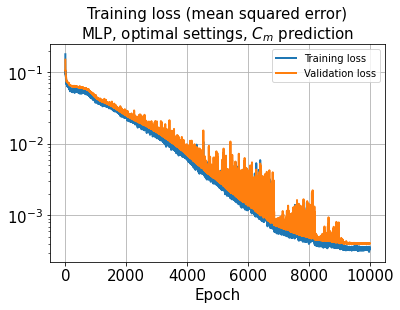

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

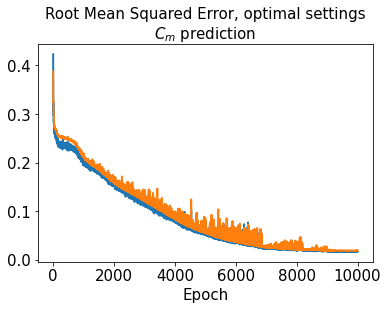

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

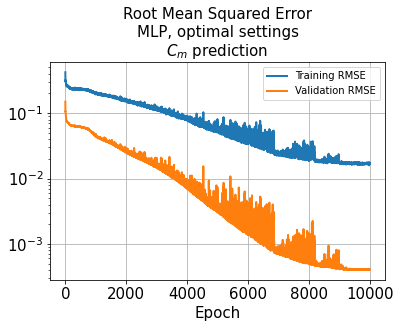

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 3.4417e-04 - rmse: 0.0170


In [37]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 4.0650e-04 - rmse: 0.0187


In [38]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 4.0211e-04 - rmse: 0.0186


In [39]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [40]:
decoded_train_

array([[0.96878505],
       [0.01283749],
       [0.0015845 ],
       ...,
       [0.19479597],
       [0.04229549],
       [0.99566245]], dtype=float32)

In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [46]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [47]:
model_directory = "D:\\TrainedModels\\20221226"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221226unsteadyValidation_MLP_Flap1_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [48]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [49]:
os.chdir(storage_dir)

In [50]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [51]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.04988031389215348
2.4637264081891384


In [52]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.0533556514978453
2.7321405144049624


In [53]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.05484865457303691
2.6534259506418456


In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

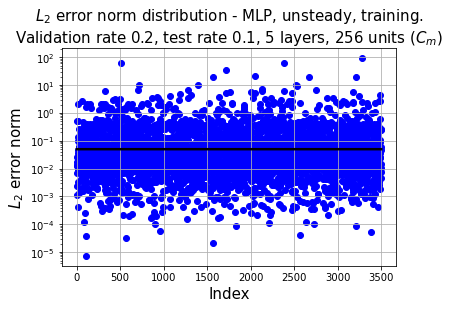

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

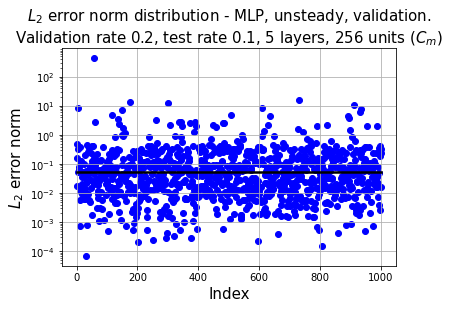

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

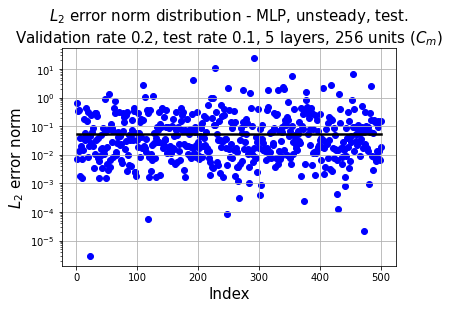

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

157/157 [==============================] - 0s 2ms/step


In [65]:
predicted.shape

(5000, 1)

In [77]:
iTrain

array([], dtype=float64)

In [119]:
x=x-10
t_train = x[index_train]+10
t_val = x[index_val]+10
t_test = x[index_test]+10

In [110]:
t_train

array([[0.000e+00],
       [1.000e-03],
       [3.000e-03],
       ...,
       [4.994e+00],
       [4.995e+00],
       [4.997e+00]])

In [111]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [112]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [121]:
x

array([[0.000e+00],
       [1.000e-03],
       [2.000e-03],
       ...,
       [4.997e+00],
       [4.998e+00],
       [4.999e+00]])

In [122]:
x += 10

In [123]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0405


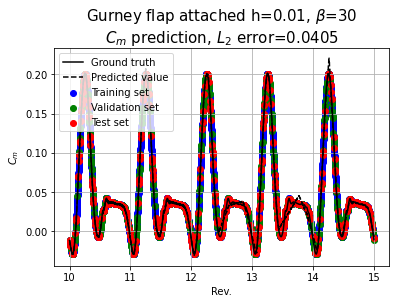

In [124]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(1, 2):
    # Index from each dataset
#     iTrain = []
#     iVal = []
#     iTest = []
    
#     # Index from input data (alpha, in this case)
#     t_train = []
#     t_val = []
#     t_test = []
    
    predictedValue = predicted#[t_len*i:t_len*(i+1),:]
    y_corres = y
    #[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
#     for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
#         iTrain.append(predicted[index])
#     for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
#         iVal.append(predicted[index])    
#     for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
#         iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

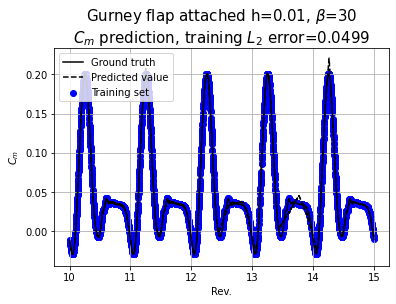

In [126]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_train)
title_Cm = title_n_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
# plt.scatter(tVal, iVal, color='g', label='Validation set')
# plt.scatter(tTest,iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

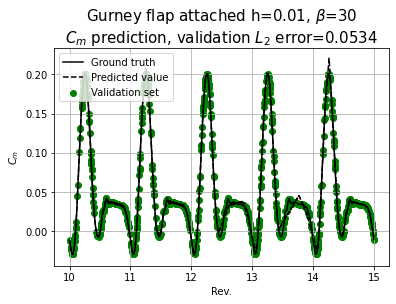

In [130]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_val)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

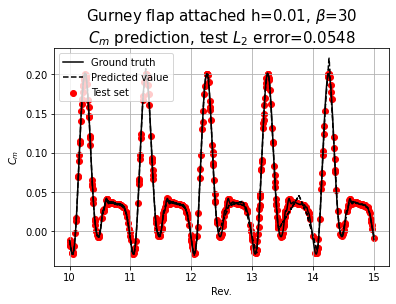

In [129]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_test)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()